# Machine Learning Pipeline for Sensor Data

**Purpose**: Load combined sensor data and create windowed data for model training/inference.

**Pipeline Steps**:
1. Load configuration from config.yaml
2. Load combined sensor data (from debug_labels_v2.ipynb output)
3. Create sliding windows based on config parameters
4. Prepare data for model input
5. Data quality checks and visualization

**Key Features**:
- Configurable window size and step size from config.yaml
- Handles multiple subjects
- Creates properly formatted training/testing windows
- Maintains label alignment with windows
- Data quality validation

## 1. Configuration and Setup

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import yaml
import pickle
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuration
PROJECT_ROOT = '/scai_data3/scratch/stirnimann_r'
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'config.yaml')

print(f"📋 Machine Learning Pipeline Setup")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Config file: {CONFIG_PATH}")

# Load configuration
print(f"\n=== LOADING CONFIGURATION ===")
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract relevant parameters
SUBJECTS = config.get('subjects_to_load', [])
WINDOW_SIZE = config.get('window_size', 125)  # Default 5s at 25Hz
WINDOW_STEP = config.get('window_step', 25)   # Default 1s at 25Hz
TARGET_COLUMN = config.get('target_column', 'Activity')
SUBJECT_ID_COLUMN = config.get('subject_id_column', 'SubjectID')
RESULTS_DIR = os.path.join(PROJECT_ROOT, config.get('results_dir', 'results'))

# === LABEL COVERAGE CONFIGURATION ===
# Minimum label coverage threshold for including windows in the final dataset
# Windows with label coverage below this threshold will be excluded
MIN_LABEL_COVERAGE = 0.8  # 80% of the window must have valid labels

# === SENSOR CONFIGURATION ===
# Manual sensor column specifications for consistent processing across all subjects
# Update this list to include/exclude specific sensors as needed

REQUIRED_SENSOR_COLUMNS = [
    'corsano_wrist_wrist_acc_x',
    'corsano_wrist_wrist_acc_y', 
    'corsano_wrist_wrist_acc_z',
    #'cosinuss_ear_ear_acc_x',
    #'cosinuss_ear_ear_acc_y',
    #'cosinuss_ear_ear_acc_z',
    'mbient_acc_x_axis_g',
    'mbient_acc_y_axis_g',
    'mbient_acc_z_axis_g',
    'mbient_gyro_x_axis_dps',
    'mbient_gyro_y_axis_dps',
    'mbient_gyro_z_axis_dps',
    'vivalnk_acc_vivalnk_acc_x',
    'vivalnk_acc_vivalnk_acc_y',
    'vivalnk_acc_vivalnk_acc_z',
    'sensomative_bottom_bottom_value_1',
    'sensomative_bottom_bottom_value_2',
    'sensomative_bottom_bottom_value_3',
    'sensomative_bottom_bottom_value_4',
    'sensomative_bottom_bottom_value_5',
    'sensomative_bottom_bottom_value_6',
    'sensomative_bottom_bottom_value_7',
    'sensomative_bottom_bottom_value_8',
    'sensomative_bottom_bottom_value_9',
    'sensomative_bottom_bottom_value_10',
    'sensomative_bottom_bottom_value_11',
    #'sensomative_back_back_value_1',
    #'sensomative_back_back_value_2',
    #'sensomative_back_back_value_3',
    #'sensomative_back_back_value_4',
    #'sensomative_back_back_value_5',
    #'sensomative_back_back_value_6',
    #'sensomative_back_back_value_7',
    #'sensomative_back_back_value_8',
    #'sensomative_back_back_value_9',
    #'sensomative_back_back_value_10',
    #'sensomative_back_back_value_11',
    'corsano_bioz_bioz_acc_x',
    'corsano_bioz_bioz_acc_y',
    'corsano_bioz_bioz_acc_z'
]

print(f"✅ Configuration loaded successfully!")
print(f"  Subjects to process: {len(SUBJECTS)}")
print(f"  Window size: {WINDOW_SIZE} samples")
print(f"  Window step: {WINDOW_STEP} samples")
print(f"  Target column: {TARGET_COLUMN}")
print(f"  Subject ID column: {SUBJECT_ID_COLUMN}")
print(f"  Results directory: {RESULTS_DIR}")

print(f"\n📊 Label Coverage Configuration:")
print(f"  Minimum label coverage: {MIN_LABEL_COVERAGE:.1%}")
print(f"  Windows below this threshold will be excluded")
print(f"  This ensures high-quality labeled windows for training")

print(f"\n📊 Sensor Configuration:")
print(f"  Required sensor columns: {len(REQUIRED_SENSOR_COLUMNS)}")
print(f"  Sensor categories:")
print(f"    Corsano Wrist Acc: 3 sensors")
print(f"    Cosinuss Ear Acc: 3 sensors") 
print(f"    Mbient Acc + Gyro: 6 sensors")
print(f"    Vivalnk Acc: 3 sensors")
print(f"    Sensomative Bottom: 11 sensors")
print(f"    Sensomative Back: 11 sensors")
print(f"    Corsano BioZ Acc: 3 sensors")
print(f"  Total: {len(REQUIRED_SENSOR_COLUMNS)} sensor features")

# Calculate window parameters
SAMPLING_FREQ = 25  # Hz (from config)
WINDOW_DURATION_SEC = WINDOW_SIZE / SAMPLING_FREQ
STEP_DURATION_SEC = WINDOW_STEP / SAMPLING_FREQ

print(f"\n📊 Window Parameters:")
print(f"  Window duration: {WINDOW_DURATION_SEC:.1f} seconds")
print(f"  Step duration: {STEP_DURATION_SEC:.1f} seconds")
print(f"  Overlap: {((WINDOW_SIZE - WINDOW_STEP) / WINDOW_SIZE * 100):.1f}%")

# Create output directory for pipeline results
PIPELINE_RESULTS_DIR = os.path.join(RESULTS_DIR, 'pipeline')
os.makedirs(PIPELINE_RESULTS_DIR, exist_ok=True)
print(f"  Pipeline output: {PIPELINE_RESULTS_DIR}")

📋 Machine Learning Pipeline Setup
  Project root: /scai_data3/scratch/stirnimann_r
  Config file: /scai_data3/scratch/stirnimann_r/config.yaml

=== LOADING CONFIGURATION ===
✅ Configuration loaded successfully!
  Subjects to process: 6
  Window size: 250 samples
  Window step: 225 samples
  Target column: Label
  Subject ID column: SubjectID
  Results directory: /scai_data3/scratch/stirnimann_r/results

📊 Label Coverage Configuration:
  Minimum label coverage: 80.0%
  Windows below this threshold will be excluded
  This ensures high-quality labeled windows for training

📊 Sensor Configuration:
  Required sensor columns: 26
  Sensor categories:
    Corsano Wrist Acc: 3 sensors
    Cosinuss Ear Acc: 3 sensors
    Mbient Acc + Gyro: 6 sensors
    Vivalnk Acc: 3 sensors
    Sensomative Bottom: 11 sensors
    Sensomative Back: 11 sensors
    Corsano BioZ Acc: 3 sensors
  Total: 26 sensor features

📊 Window Parameters:
  Window duration: 10.0 seconds
  Step duration: 9.0 seconds
  Overlap: 1

In [2]:
# Data loading functions
def load_combined_data(subject_id):
    """Load combined data for a specific subject with consistent sensor columns"""
    subject_results_dir = os.path.join(RESULTS_DIR, subject_id)
    combined_data_path = os.path.join(subject_results_dir, f'{subject_id}_combined_data.pkl')
    metadata_path = os.path.join(subject_results_dir, f'{subject_id}_combined_data_metadata.json')
    
    print(f"📊 Loading data for {subject_id}...")
    print(f"  Data file: {combined_data_path}")
    
    if not os.path.exists(combined_data_path):
        print(f"❌ Combined data file not found for {subject_id}")
        return None, None
    
    # Load the combined data
    with open(combined_data_path, 'rb') as f:
        combined_data = pickle.load(f)
    
    # Load metadata if available
    metadata = {}
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"✅ Loaded metadata")
    else:
        print(f"⚠️ No metadata file found")
    
    print(f"✅ Loaded {subject_id}: {combined_data.shape}")
    print(f"  Time range: {combined_data.index.min()} to {combined_data.index.max()}")
    print(f"  Duration: {combined_data.index.max() - combined_data.index.min()}")
    print(f"  Available columns: {list(combined_data.columns)}")
    
    # Ensure consistent sensor columns across all subjects
    combined_data_filtered = filter_and_validate_sensor_columns(combined_data, subject_id)
    
    return combined_data_filtered, metadata

def filter_and_validate_sensor_columns(data, subject_id):
    """
    Filter data to include only the required sensor columns as specified in config.
    Ensures all subjects have exactly the same sensor columns.
    """
    print(f"  🔧 Filtering sensor columns for {subject_id}...")
    
    # Get all columns except the target column (Label)
    available_columns = [col for col in data.columns if col != 'Label']
    
    # Check which required sensor columns are available
    available_sensor_columns = [col for col in REQUIRED_SENSOR_COLUMNS if col in available_columns]
    missing_sensor_columns = [col for col in REQUIRED_SENSOR_COLUMNS if col not in available_columns]
    extra_columns = [col for col in available_columns if col not in REQUIRED_SENSOR_COLUMNS and col != 'Label']
    
    print(f"    Required sensor columns: {len(REQUIRED_SENSOR_COLUMNS)}")
    print(f"    Available sensor columns: {len(available_sensor_columns)}")
    
    if missing_sensor_columns:
        print(f"    ⚠️ Missing sensor columns ({len(missing_sensor_columns)}): {missing_sensor_columns[:5]}{'...' if len(missing_sensor_columns) > 5 else ''}")
        
        # Create missing columns with NaN values
        for col in missing_sensor_columns:
            data[col] = np.nan
            print(f"      ➕ Added missing column '{col}' with NaN values")
    
    if extra_columns:
        print(f"    ℹ️ Extra columns found ({len(extra_columns)}): {extra_columns[:5]}{'...' if len(extra_columns) > 5 else ''}")
        print(f"      These will be excluded to maintain consistency")
    
    # Select only the required sensor columns plus the Label column
    final_columns = REQUIRED_SENSOR_COLUMNS + ['Label']
    
    # Ensure all required columns exist
    for col in final_columns:
        if col not in data.columns:
            if col == 'Label':
                print(f"    ⚠️ Label column not found - this will be handled later")
                continue
            else:
                data[col] = np.nan
                print(f"      ➕ Created missing sensor column '{col}' with NaN values")
    
    # Filter to final columns (only those that exist)
    existing_final_columns = [col for col in final_columns if col in data.columns]
    filtered_data = data[existing_final_columns].copy()
    
    print(f"    ✅ Filtered data shape: {filtered_data.shape}")
    print(f"    ✅ Final columns: {len(existing_final_columns)}")
    print(f"    📊 Sensor columns: {len([col for col in existing_final_columns if col != 'Label'])}")
    
    return filtered_data

def get_available_subjects():
    """Get list of subjects with available combined data"""
    available_subjects = []
    
    for subject_id in SUBJECTS:
        subject_results_dir = os.path.join(RESULTS_DIR, subject_id)
        combined_data_path = os.path.join(subject_results_dir, f'{subject_id}_combined_data.pkl')
        
        if os.path.exists(combined_data_path):
            available_subjects.append(subject_id)
        else:
            print(f"⚠️ No combined data found for {subject_id}")
    
    return available_subjects

def validate_sensor_consistency(all_subject_data):
    """Validate that all subjects have the same sensor columns"""
    print(f"\n🔍 VALIDATING SENSOR COLUMN CONSISTENCY")
    
    if not all_subject_data:
        print(f"❌ No subject data to validate")
        return False
    
    # Get sensor columns from first subject as reference
    reference_subject = list(all_subject_data.keys())[0]
    reference_columns = all_subject_data[reference_subject]['sensor_columns']
    
    print(f"  Reference subject: {reference_subject}")
    print(f"  Reference sensor columns: {len(reference_columns)}")
    
    # Check consistency across all subjects
    all_consistent = True
    for subject_id, subject_data in all_subject_data.items():
        subject_columns = subject_data['sensor_columns']
        
        if set(subject_columns) != set(reference_columns):
            print(f"  ❌ {subject_id}: Inconsistent sensor columns!")
            print(f"    Expected: {len(reference_columns)} columns")
            print(f"    Found: {len(subject_columns)} columns")
            
            missing = set(reference_columns) - set(subject_columns)
            extra = set(subject_columns) - set(reference_columns)
            
            if missing:
                print(f"    Missing: {list(missing)[:5]}{'...' if len(missing) > 5 else ''}")
            if extra:
                print(f"    Extra: {list(extra)[:5]}{'...' if len(extra) > 5 else ''}")
            
            all_consistent = False
        else:
            print(f"  ✅ {subject_id}: Consistent sensor columns ({len(subject_columns)})")
    
    if all_consistent:
        print(f"  🎉 All subjects have consistent sensor columns!")
        print(f"  📊 Total sensor features per subject: {len(reference_columns)}")
    else:
        print(f"  ⚠️ Sensor column inconsistencies detected!")
    
    return all_consistent

# Check available subjects
print(f"\n=== CHECKING AVAILABLE DATA ===")
available_subjects = get_available_subjects()
print(f"✅ Found combined data for {len(available_subjects)} subjects:")
for subject in available_subjects:
    print(f"  📊 {subject}")

if not available_subjects:
    print(f"❌ No combined data found for any subjects!")
    print(f"💡 Make sure to run debug_labels_v2.ipynb first to create combined data")


=== CHECKING AVAILABLE DATA ===
✅ Found combined data for 6 subjects:
  📊 OutSense-036
  📊 OutSense-293
  📊 OutSense-498
  📊 OutSense-515
  📊 OutSense-713
  📊 OutSense-991


## 2. Data Loading Functions

In [3]:
# Window creation functions
def create_sliding_windows(data, window_size, step_size, target_column='Label', min_coverage=None):
    """
    Create sliding windows from time series data with label coverage filtering
    
    Parameters:
    - data: DataFrame with time index and sensor columns + label column
    - window_size: Number of samples per window
    - step_size: Number of samples to step between windows
    - target_column: Name of the label column
    - min_coverage: Minimum label coverage threshold (uses global MIN_LABEL_COVERAGE if None)
    
    Returns:
    - windows: 3D array (n_windows, window_size, n_features)
    - labels: 1D array (n_windows,) with majority label for each window
    - window_info: DataFrame with metadata for each window
    """
    
    # Use global minimum coverage if not specified
    if min_coverage is None:
        min_coverage = MIN_LABEL_COVERAGE
    
    # Separate features from labels
    if target_column in data.columns:
        feature_columns = [col for col in data.columns if col != target_column]
        feature_data = data[feature_columns]
        label_data = data[target_column]
    else:
        print(f"⚠️ Target column '{target_column}' not found in data")
        feature_columns = data.columns.tolist()
        feature_data = data
        label_data = pd.Series(['Unknown'] * len(data), index=data.index)
    
    # Convert to numpy arrays
    feature_array = feature_data.values
    n_samples, n_features = feature_array.shape
    
    print(f"📊 Creating sliding windows:")
    print(f"  Input data shape: {feature_array.shape}")
    print(f"  Window size: {window_size} samples")
    print(f"  Step size: {step_size} samples")
    print(f"  Features: {n_features}")
    print(f"  Minimum label coverage: {min_coverage:.1%}")
    
    # Calculate number of windows
    n_windows = (n_samples - window_size) // step_size + 1
    print(f"  Total possible windows: {n_windows}")
    
    if n_windows <= 0:
        print(f"❌ Not enough data for even one window!")
        return None, None, None
    
    # First pass: create all windows and check label coverage
    print(f"🔄 Creating windows and filtering by label coverage...")
    
    valid_windows = []
    valid_labels = []
    valid_window_info = []
    excluded_count = 0
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        
        # Extract window data
        window_data = feature_array[start_idx:end_idx, :]
        
        # Extract window labels and find majority label
        window_labels = label_data.iloc[start_idx:end_idx]
        
        # Get majority label (most frequent label in window)
        if not window_labels.empty:
            # Remove empty labels and get majority
            non_empty_labels = window_labels[window_labels != ''].copy()
            if len(non_empty_labels) > 0:
                majority_label = non_empty_labels.mode().iloc[0] if len(non_empty_labels.mode()) > 0 else 'Unknown'
                label_coverage = len(non_empty_labels) / len(window_labels)
            else:
                majority_label = 'Unknown'
                label_coverage = 0.0
        else:
            majority_label = 'Unknown'
            label_coverage = 0.0
        
        # Check if window meets minimum coverage threshold
        if label_coverage >= min_coverage:
            # Include this window
            valid_windows.append(window_data)
            valid_labels.append(majority_label)
            
            # Store window metadata
            start_time = feature_data.index[start_idx]
            end_time = feature_data.index[end_idx - 1]
            
            valid_window_info.append({
                'window_id': len(valid_windows) - 1,  # New sequential ID for valid windows
                'original_window_id': i,  # Original window ID before filtering
                'start_idx': start_idx,
                'end_idx': end_idx,
                'start_time': start_time,
                'end_time': end_time,
                'majority_label': majority_label,
                'label_coverage': label_coverage,
                'n_samples': window_size
            })
        else:
            # Exclude this window due to insufficient label coverage
            excluded_count += 1
        
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1}/{n_windows} windows... (valid: {len(valid_windows)}, excluded: {excluded_count})")
    
    # Convert to final arrays/DataFrames
    if len(valid_windows) == 0:
        print(f"❌ No windows meet the minimum label coverage threshold of {min_coverage:.1%}!")
        return None, None, None
    
    # Stack valid windows into final array
    windows = np.stack(valid_windows, axis=0)
    labels = np.array(valid_labels)
    window_info_df = pd.DataFrame(valid_window_info)
    
    print(f"✅ Window creation and filtering completed!")
    print(f"  Total possible windows: {n_windows:,}")
    print(f"  Valid windows (≥{min_coverage:.1%} coverage): {len(valid_windows):,}")
    print(f"  Excluded windows (<{min_coverage:.1%} coverage): {excluded_count:,}")
    print(f"  Exclusion rate: {excluded_count/n_windows*100:.1f}%")
    print(f"  Final windows shape: {windows.shape}")
    print(f"  Final labels shape: {labels.shape}")
    print(f"  Unique labels: {len(np.unique(labels))}")
    
    return windows, labels, window_info_df

def analyze_window_labels(labels, window_info_df):
    """Analyze the distribution of labels in windows"""
    print(f"\n📊 Window Label Analysis:")
    
    # Count label distribution
    label_counts = pd.Series(labels).value_counts()
    print(f"  Total windows: {len(labels)}")
    print(f"  Unique activities: {len(label_counts)}")
    
    # Show top activities
    print(f"\n🏷️ Top 15 Activities by Window Count:")
    for i, (label, count) in enumerate(label_counts.head(15).items()):
        percentage = count / len(labels) * 100
        print(f"  {i+1:2d}. {label}: {count:,} windows ({percentage:.1f}%)")
    
    if len(label_counts) > 15:
        remaining_count = label_counts.iloc[15:].sum()
        remaining_activities = len(label_counts) - 15
        print(f"      ... and {remaining_activities} more activities ({remaining_count:,} windows)")
    
    # Analyze label coverage
    coverage_stats = window_info_df['label_coverage'].describe()
    print(f"\n📈 Label Coverage Statistics (for included windows):")
    print(f"  Mean coverage: {coverage_stats['mean']:.3f}")
    print(f"  Median coverage: {coverage_stats['50%']:.3f}")
    print(f"  Min coverage: {coverage_stats['min']:.3f}")
    print(f"  Max coverage: {coverage_stats['max']:.3f}")
    
    # Count windows with different coverage levels
    excellent_coverage = (window_info_df['label_coverage'] >= 0.95).sum()
    good_coverage = (window_info_df['label_coverage'] >= 0.8).sum()
    min_coverage = (window_info_df['label_coverage'] >= MIN_LABEL_COVERAGE).sum()
    
    print(f"\n✅ Coverage Distribution (included windows only):")
    print(f"  Excellent coverage (≥95%): {excellent_coverage:,} ({excellent_coverage/len(labels)*100:.1f}%)")
    print(f"  Good coverage (≥80%): {good_coverage:,} ({good_coverage/len(labels)*100:.1f}%)")
    print(f"  Above minimum (≥{MIN_LABEL_COVERAGE:.0%}): {min_coverage:,} ({min_coverage/len(labels)*100:.1f}%)")
    
    return label_counts

print(f"✅ Window creation functions ready!")

✅ Window creation functions ready!


## 3. Window Creation Functions

## 4. Data Processing Pipeline

In [4]:
# Main data processing pipeline
def process_subject_data(subject_id):
    """Process data for a single subject with consistent sensor columns"""
    print(f"\n{'='*60}")
    print(f"PROCESSING SUBJECT: {subject_id}")
    print(f"{'='*60}")
    
    # Load combined data with sensor column filtering
    combined_data, metadata = load_combined_data(subject_id)
    
    if combined_data is None:
        print(f"❌ Skipping {subject_id} - no data available")
        return None
    
    # Check for required columns
    target_col = 'Label'  # The label column from debug_labels_v2
    if target_col not in combined_data.columns:
        print(f"❌ Target column '{target_col}' not found in {subject_id}")
        print(f"Available columns: {list(combined_data.columns)}")
        return None
    
    # Get sensor columns (should now be consistent across all subjects)
    sensor_columns = [col for col in combined_data.columns if col != target_col]
    
    # Validate that we have the expected sensor columns
    expected_sensor_count = len(REQUIRED_SENSOR_COLUMNS)
    actual_sensor_count = len(sensor_columns)
    
    print(f"📊 Sensor Column Validation:")
    print(f"  Expected sensor columns: {expected_sensor_count}")
    print(f"  Actual sensor columns: {actual_sensor_count}")
    
    if actual_sensor_count != expected_sensor_count:
        print(f"  ⚠️ Sensor column count mismatch!")
        missing_sensors = set(REQUIRED_SENSOR_COLUMNS) - set(sensor_columns)
        extra_sensors = set(sensor_columns) - set(REQUIRED_SENSOR_COLUMNS)
        
        if missing_sensors:
            print(f"    Missing: {list(missing_sensors)}")
        if extra_sensors:
            print(f"    Extra: {list(extra_sensors)}")
    else:
        print(f"  ✅ Sensor column count matches expected")
    
    print(f"  Final sensor columns: {sensor_columns[:5]}{'...' if len(sensor_columns) > 5 else ''}")
    
    # Check for missing data in sensor columns
    missing_data = combined_data[sensor_columns].isnull().sum().sum()
    if missing_data > 0:
        print(f"⚠️ Found {missing_data:,} missing values in sensor data")
        
        # Report missing data per column
        missing_per_column = combined_data[sensor_columns].isnull().sum()
        columns_with_missing = missing_per_column[missing_per_column > 0]
        
        if len(columns_with_missing) > 0:
            print(f"  Columns with missing data:")
            for col, count in columns_with_missing.items():
                percentage = (count / len(combined_data)) * 100
                print(f"    {col}: {count:,} ({percentage:.1f}%)")
        
        # Fill missing values with forward fill, then backward fill
        combined_data[sensor_columns] = combined_data[sensor_columns].fillna(method='ffill').fillna(method='bfill')
        
        # If still missing (e.g., entire columns are NaN), fill with 0
        remaining_missing = combined_data[sensor_columns].isnull().sum().sum()
        if remaining_missing > 0:
            print(f"  ⚠️ {remaining_missing:,} values still missing after forward/backward fill")
            combined_data[sensor_columns] = combined_data[sensor_columns].fillna(0)
            print(f"  ✅ Filled remaining missing values with 0")
        else:
            print(f"  ✅ Filled missing values with forward/backward fill")
    else:
        print(f"✅ No missing values in sensor data")
    
    # Create sliding windows
    print(f"\n🔄 Creating sliding windows...")
    windows, labels, window_info = create_sliding_windows(
        data=combined_data,
        window_size=WINDOW_SIZE,
        step_size=WINDOW_STEP,
        target_column=target_col
    )
    
    if windows is None:
        print(f"❌ Failed to create windows for {subject_id}")
        return None
    
    # Analyze labels
    label_counts = analyze_window_labels(labels, window_info)
    
    # Add subject ID to window info
    window_info[SUBJECT_ID_COLUMN] = subject_id
    
    # Create output dictionary with validation info
    subject_data = {
        'subject_id': subject_id,
        'windows': windows,
        'labels': labels,
        'window_info': window_info,
        'label_counts': label_counts,
        'sensor_columns': sensor_columns,  # This should now be consistent across all subjects
        'metadata': metadata,
        'original_data_shape': combined_data.shape,
        'original_time_range': (combined_data.index.min(), combined_data.index.max()),
        'sensor_validation': {
            'expected_sensor_count': expected_sensor_count,
            'actual_sensor_count': actual_sensor_count,
            'required_sensors': REQUIRED_SENSOR_COLUMNS,
            'missing_data_filled': missing_data > 0
        }
    }
    
    # Save subject data
    output_path = os.path.join(PIPELINE_RESULTS_DIR, f'{subject_id}_windowed_data.pkl')
    with open(output_path, 'wb') as f:
        pickle.dump(subject_data, f)
    print(f"💾 Saved windowed data: {output_path}")
    
    return subject_data

# Process all available subjects
print(f"\n=== PROCESSING ALL SUBJECTS ===")
all_subject_data = {}

for subject_id in available_subjects:
    try:
        subject_data = process_subject_data(subject_id)
        if subject_data is not None:
            all_subject_data[subject_id] = subject_data
    except Exception as e:
        print(f"❌ Error processing {subject_id}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n✅ Processing completed!")
print(f"📊 Successfully processed {len(all_subject_data)} subjects:")
for subject_id in all_subject_data.keys():
    print(f"  📈 {subject_id}")

# Validate sensor column consistency across all subjects
sensor_consistency_valid = validate_sensor_consistency(all_subject_data)

if not sensor_consistency_valid:
    print(f"\n⚠️ WARNING: Sensor column inconsistencies detected!")
    print(f"This may affect model training. Please check the data processing.")
else:
    print(f"\n🎉 SUCCESS: All subjects have consistent sensor columns!")
    print(f"Ready for combined dataset creation.")


=== PROCESSING ALL SUBJECTS ===

PROCESSING SUBJECT: OutSense-036
📊 Loading data for OutSense-036...
  Data file: /scai_data3/scratch/stirnimann_r/results/OutSense-036/OutSense-036_combined_data.pkl


✅ Loaded metadata
✅ Loaded OutSense-036: (4548624, 30)
  Time range: 2024-02-06 08:51:10.002000093 to 2024-02-08 11:23:35
  Duration: 2 days 02:32:24.997999907
  Available columns: ['corsano_wrist_wrist_acc_x', 'corsano_wrist_wrist_acc_y', 'corsano_wrist_wrist_acc_z', 'cosinuss_ear_ear_acc_x', 'cosinuss_ear_ear_acc_y', 'cosinuss_ear_ear_acc_z', 'mbient_acc_x_axis_g', 'mbient_acc_y_axis_g', 'mbient_acc_z_axis_g', 'mbient_gyro_x_axis_dps', 'mbient_gyro_y_axis_dps', 'mbient_gyro_z_axis_dps', 'vivalnk_acc_vivalnk_acc_x', 'vivalnk_acc_vivalnk_acc_y', 'vivalnk_acc_vivalnk_acc_z', 'sensomative_bottom_bottom_value_1', 'sensomative_bottom_bottom_value_2', 'sensomative_bottom_bottom_value_3', 'sensomative_bottom_bottom_value_4', 'sensomative_bottom_bottom_value_5', 'sensomative_bottom_bottom_value_6', 'sensomative_bottom_bottom_value_7', 'sensomative_bottom_bottom_value_8', 'sensomative_bottom_bottom_value_9', 'sensomative_bottom_bottom_value_10', 'sensomative_bottom_bottom_value_11', 'corsano_b

## 5. Combined Dataset Creation

In [5]:
# Combine data from all subjects
print(f"\n=== CREATING COMBINED DATASET ===")

if len(all_subject_data) == 0:
    print(f"❌ No subject data available for combining")
else:
    # Verify sensor consistency before combining
    if not sensor_consistency_valid:
        print(f"⚠️ WARNING: Proceeding with combination despite sensor inconsistencies")
    
    # Collect all windows and labels
    all_windows = []
    all_labels = []
    all_window_info = []
    
    print(f"🔄 Combining data from {len(all_subject_data)} subjects...")
    
    # Get reference sensor columns from first subject
    reference_subject = list(all_subject_data.keys())[0]
    reference_sensor_columns = all_subject_data[reference_subject]['sensor_columns']
    
    print(f"  📊 Reference sensor columns ({len(reference_sensor_columns)}): {reference_sensor_columns[:5]}{'...' if len(reference_sensor_columns) > 5 else ''}")
    
    for subject_id, subject_data in all_subject_data.items():
        windows = subject_data['windows']
        labels = subject_data['labels']
        window_info = subject_data['window_info']
        
        print(f"  📊 {subject_id}: {windows.shape[0]:,} windows, shape: {windows.shape}")
        
        # Verify window shape consistency
        if len(all_windows) > 0:
            if windows.shape[1:] != all_windows[0].shape[1:]:
                print(f"    ⚠️ Shape mismatch! Expected: {all_windows[0].shape[1:]}, Got: {windows.shape[1:]}")
        
        all_windows.append(windows)
        all_labels.extend(labels)
        all_window_info.append(window_info)
    
    # Combine arrays
    combined_windows = np.concatenate(all_windows, axis=0)
    combined_labels = np.array(all_labels)
    combined_window_info = pd.concat(all_window_info, ignore_index=True)
    
    print(f"\n✅ Combined dataset created!")
    print(f"  Total windows: {combined_windows.shape[0]:,}")
    print(f"  Window shape: {combined_windows.shape[1:]} (samples, features)")
    print(f"  Total labels: {len(combined_labels):,}")
    print(f"  Unique activities: {len(np.unique(combined_labels))}")
    
    # Analyze combined labels
    print(f"\n📊 Combined Dataset Label Analysis:")
    combined_label_counts = pd.Series(combined_labels).value_counts()
    
    print(f"  Total windows: {len(combined_labels):,}")
    print(f"  Unique activities: {len(combined_label_counts)}")
    
    print(f"\n🏷️ Top 20 Activities in Combined Dataset:")
    for i, (label, count) in enumerate(combined_label_counts.head(20).items()):
        percentage = count / len(combined_labels) * 100
        print(f"  {i+1:2d}. {label}: {count:,} windows ({percentage:.1f}%)")
    
    # Subject distribution
    print(f"\n👥 Windows per Subject:")
    subject_window_counts = combined_window_info[SUBJECT_ID_COLUMN].value_counts()
    for subject, count in subject_window_counts.items():
        percentage = count / len(combined_labels) * 100
        print(f"  📊 {subject}: {count:,} windows ({percentage:.1f}%)")
    
    # Create combined dataset dictionary with sensor consistency info
    combined_dataset = {
        'windows': combined_windows,
        'labels': combined_labels,
        'window_info': combined_window_info,
        'label_counts': combined_label_counts,
        'subject_counts': subject_window_counts,
        'config': {
            'window_size': WINDOW_SIZE,
            'window_step': WINDOW_STEP,
            'sampling_frequency': SAMPLING_FREQ,
            'window_duration_sec': WINDOW_DURATION_SEC,
            'step_duration_sec': STEP_DURATION_SEC
        },
        'sensor_config': {
            'required_sensor_columns': REQUIRED_SENSOR_COLUMNS,
            'final_sensor_columns': reference_sensor_columns,
            'sensor_consistency_validated': sensor_consistency_valid,
            'n_sensor_features': len(reference_sensor_columns)
        },
        'metadata': {
            'creation_time': datetime.now().isoformat(),
            'subjects_included': list(all_subject_data.keys()),
            'n_subjects': len(all_subject_data),
            'n_windows': combined_windows.shape[0],
            'n_features': combined_windows.shape[2],
            'n_unique_labels': len(combined_label_counts),
            'sensor_consistency_valid': sensor_consistency_valid
        }
    }
    
    # Save combined dataset
    combined_output_path = os.path.join(PIPELINE_RESULTS_DIR, 'combined_windowed_dataset.pkl')
    with open(combined_output_path, 'wb') as f:
        pickle.dump(combined_dataset, f)
    
    print(f"\n💾 Saved combined dataset: {combined_output_path}")
    
    # Save metadata as JSON for easy reading
    metadata_output_path = os.path.join(PIPELINE_RESULTS_DIR, 'combined_dataset_metadata.json')
    with open(metadata_output_path, 'w') as f:
        json.dump(combined_dataset['metadata'], f, indent=2, default=str)
    
    print(f"💾 Saved metadata: {metadata_output_path}")
    
    # Save detailed sensor configuration
    sensor_config_path = os.path.join(PIPELINE_RESULTS_DIR, 'sensor_configuration.json')
    with open(sensor_config_path, 'w') as f:
        json.dump(combined_dataset['sensor_config'], f, indent=2, default=str)
    
    print(f"💾 Saved sensor configuration: {sensor_config_path}")
    
    # Display final sensor summary
    print(f"\n📋 FINAL SENSOR CONFIGURATION SUMMARY:")
    print(f"  📊 Required sensor columns (manual list): {len(REQUIRED_SENSOR_COLUMNS)}")
    print(f"  ✅ Final sensor columns used: {len(reference_sensor_columns)}")
    print(f"  🔧 Sensor consistency validated: {'✅ YES' if sensor_consistency_valid else '❌ NO'}")
    print(f"  🎯 All subjects have identical sensor features: {'✅ YES' if sensor_consistency_valid else '❌ NO'}")
    
    if not sensor_consistency_valid:
        print(f"\n⚠️  ATTENTION: Sensor inconsistencies detected!")
        print(f"   Please review the processing logs above for details.")
        print(f"   This may impact model training performance.")


=== CREATING COMBINED DATASET ===
🔄 Combining data from 6 subjects...
  📊 Reference sensor columns (26): ['corsano_wrist_wrist_acc_x', 'corsano_wrist_wrist_acc_y', 'corsano_wrist_wrist_acc_z', 'mbient_acc_x_axis_g', 'mbient_acc_y_axis_g']...
  📊 OutSense-036: 10,205 windows, shape: (10205, 250, 26)
  📊 OutSense-293: 8,617 windows, shape: (8617, 250, 26)
  📊 OutSense-498: 12,801 windows, shape: (12801, 250, 26)
  📊 OutSense-515: 6,501 windows, shape: (6501, 250, 26)
  📊 OutSense-713: 16,594 windows, shape: (16594, 250, 26)
  📊 OutSense-991: 14,645 windows, shape: (14645, 250, 26)

✅ Combined dataset created!
  Total windows: 69,363
  Window shape: (250, 26) (samples, features)
  Total labels: 69,363
  Unique activities: 115

📊 Combined Dataset Label Analysis:
  Total windows: 69,363
  Unique activities: 115

🏷️ Top 20 Activities in Combined Dataset:
   1. dark: 18,082 windows (26.1%)
   2. black_video: 13,284 windows (19.2%)
   3. wheelchair _in_storage: 10,058 windows (14.5%)
   4. co

## 5.1. Activity Mapping and Filtering

Apply activity mapping using `Activity_Mapping_v2.csv` to map raw activity labels to standardized activity categories, then filter to keep only activities of interest for training.

In [6]:
# Apply Activity Mapping and Filtering
if 'combined_dataset' in locals():
    print(f"\n=== ACTIVITY MAPPING AND FILTERING ===")
    
    # Load activity mapping
    mapping_file = '/scai_data3/scratch/stirnimann_r/Activity_Mapping_v2.csv'
    
    if os.path.exists(mapping_file):
        activity_mapping = pd.read_csv(mapping_file)
        print(f"📊 Loaded activity mapping from: {mapping_file}")
        print(f"  Mapping entries: {len(activity_mapping)}")
        
        # Display mapping structure
        print(f"\n📋 Activity Mapping Structure:")
        print(activity_mapping.head())
        
        # Create mapping dictionary
        if 'Former_Label' in activity_mapping.columns and 'New_Label' in activity_mapping.columns:
            mapping_dict = dict(zip(activity_mapping['Former_Label'], activity_mapping['New_Label']))
            print(f"\n🔄 Mapping {len(mapping_dict)} activities...")
            
            # Show some mapping examples
            print(f"\n📝 Mapping Examples:")
            for i, (orig, mapped) in enumerate(list(mapping_dict.items())[:10]):
                print(f"  {i+1:2d}. '{orig}' → '{mapped}'")
            if len(mapping_dict) > 10:
                print(f"  ... and {len(mapping_dict) - 10} more mappings")
            
            # Apply mapping to labels
            original_labels = combined_dataset['labels'].copy()
            mapped_labels = []
            
            print(f"\n🔄 Applying mapping to {len(original_labels):,} labels...")
            
            # Track mapping statistics
            mapping_stats = {}
            unmapped_activities = set()
            
            for label in original_labels:
                if label in mapping_dict:
                    mapped_label = mapping_dict[label]
                    mapped_labels.append(mapped_label)
                    mapping_stats[label] = mapping_stats.get(label, 0) + 1
                else:
                    mapped_labels.append(label)  # Keep original if no mapping
                    unmapped_activities.add(label)
            
            mapped_labels = np.array(mapped_labels)
            
            # Show mapping statistics
            print(f"\n📊 Mapping Statistics:")
            print(f"  Original unique activities: {len(np.unique(original_labels))}")
            print(f"  Mapped unique activities: {len(np.unique(mapped_labels))}")
            print(f"  Activities successfully mapped: {len(mapping_stats)}")
            print(f"  Activities without mapping: {len(unmapped_activities)}")
            
            if unmapped_activities:
                print(f"\n⚠️ Activities without mapping:")
                for activity in sorted(unmapped_activities):
                    count = np.sum(original_labels == activity)
                    print(f"  - '{activity}': {count} windows")
            
            # Define activities of interest (modify this list as needed)
            ACTIVITIES_OF_INTEREST = config.get('ACTIVITIES_OF_INTEREST')
            
            print(f"\n🎯 Filtering to activities of interest: {ACTIVITIES_OF_INTEREST}")
            
            # Filter to activities of interest
            interest_mask = np.isin(mapped_labels, ACTIVITIES_OF_INTEREST)
            
            filtered_windows = combined_dataset['windows'][interest_mask]
            filtered_labels = mapped_labels[interest_mask]
            filtered_window_info = combined_dataset['window_info'][interest_mask].reset_index(drop=True)
            
            print(f"\n✅ Filtering Results:")
            print(f"  Original windows: {len(original_labels):,}")
            print(f"  Filtered windows: {len(filtered_labels):,}")
            print(f"  Reduction: {len(original_labels) - len(filtered_labels):,} windows ({(1 - len(filtered_labels)/len(original_labels))*100:.1f}%)")
            
            # Update label distribution
            filtered_label_counts = pd.Series(filtered_labels).value_counts()
            filtered_subject_counts = filtered_window_info[SUBJECT_ID_COLUMN].value_counts()
            
            print(f"\n📊 Filtered Dataset Label Distribution:")
            for i, (label, count) in enumerate(filtered_label_counts.items()):
                percentage = count / len(filtered_labels) * 100
                print(f"  {i+1}. {label}: {count:,} windows ({percentage:.1f}%)")
            
            print(f"\n👥 Filtered Windows per Subject:")
            for subject, count in filtered_subject_counts.items():
                percentage = count / len(filtered_labels) * 100
                print(f"  📊 {subject}: {count:,} windows ({percentage:.1f}%)")
            
            # Update combined dataset with mapped and filtered data
            combined_dataset['windows'] = filtered_windows
            combined_dataset['labels'] = filtered_labels
            combined_dataset['window_info'] = filtered_window_info
            combined_dataset['label_counts'] = filtered_label_counts
            combined_dataset['subject_counts'] = filtered_subject_counts
            
            # Update metadata
            combined_dataset['metadata']['n_windows'] = filtered_windows.shape[0]
            combined_dataset['metadata']['n_unique_labels'] = len(filtered_label_counts)
            combined_dataset['metadata']['activities_of_interest'] = ACTIVITIES_OF_INTEREST
            combined_dataset['metadata']['activity_mapping_applied'] = True
            combined_dataset['metadata']['mapping_file'] = mapping_file
            combined_dataset['metadata']['original_windows_before_filtering'] = len(original_labels)
            
            # Save updated combined dataset
            combined_output_path = os.path.join(PIPELINE_RESULTS_DIR, 'combined_windowed_dataset_mapped_filtered.pkl')
            with open(combined_output_path, 'wb') as f:
                pickle.dump(combined_dataset, f)
            
            print(f"\n💾 Saved updated combined dataset: {combined_output_path}")
            
            # Save updated metadata
            metadata_output_path = os.path.join(PIPELINE_RESULTS_DIR, 'combined_dataset_metadata_mapped_filtered.json')
            with open(metadata_output_path, 'w') as f:
                json.dump(combined_dataset['metadata'], f, indent=2, default=str)
            
            print(f"💾 Saved updated metadata: {metadata_output_path}")
            
            print(f"\n✅ Activity mapping and filtering completed!")
            print(f"  🎯 Dataset now contains only activities of interest")
            print(f"  📊 Ready for model training with {len(filtered_labels):,} windows")
            
        else:
            print(f"❌ Error: Activity mapping file missing required columns")
            print(f"   Expected: 'Former_Label' and 'New_Label'")
            print(f"   Found: {list(activity_mapping.columns)}")
    else:
        print(f"❌ Activity mapping file not found: {mapping_file}")
        print(f"   Proceeding without activity mapping...")
else:
    print(f"❌ Combined dataset not available. Please run the previous cell first.")


=== ACTIVITY MAPPING AND FILTERING ===
📊 Loaded activity mapping from: /scai_data3/scratch/stirnimann_r/Activity_Mapping_v2.csv
  Mapping entries: 143

📋 Activity Mapping Structure:
                Former_Label      New_Label
0  wheelchair_to_sitting_bed       Transfer
1          wheelchair_to_sit       Transfer
2              handling_oven  handling_oven
3               conversation   Conversation
4                 exercising     Exercising

🔄 Mapping 142 activities...

📝 Mapping Examples:
   1. 'wheelchair_to_sitting_bed' → 'Transfer'
   2. 'wheelchair_to_sit' → 'Transfer'
   3. 'handling_oven' → 'handling_oven'
   4. 'conversation' → 'Conversation'
   5. 'exercising' → 'Exercising'
   6. 'petting_dog' → 'petting_dog'
   7. 'not recognized' → 'Unknown'
   8. 'using_laptop' → 'Using Computer'
   9. 'wheelchair_to_sit_bed' → 'Transfer'
  10. 'using_pc' → 'Using Computer'
  ... and 132 more mappings

🔄 Applying mapping to 69,363 labels...

📊 Mapping Statistics:
  Original unique activi

## 6. Data Quality Analysis and Visualization


=== DATA QUALITY ANALYSIS ===
📊 Dataset Statistics:
  Shape: (15604, 250, 26)
  Memory usage: 0.76 GB
  Data type: float64
✅ No NaN values found
✅ No infinite values found

📈 Feature Statistics:
  Mean range: [-827.191, 1382.645]
  Std range: [0.101, 572.440]
  Min range: [-29569.000, 0.000]
  Max range: [1.467, 32767.000]


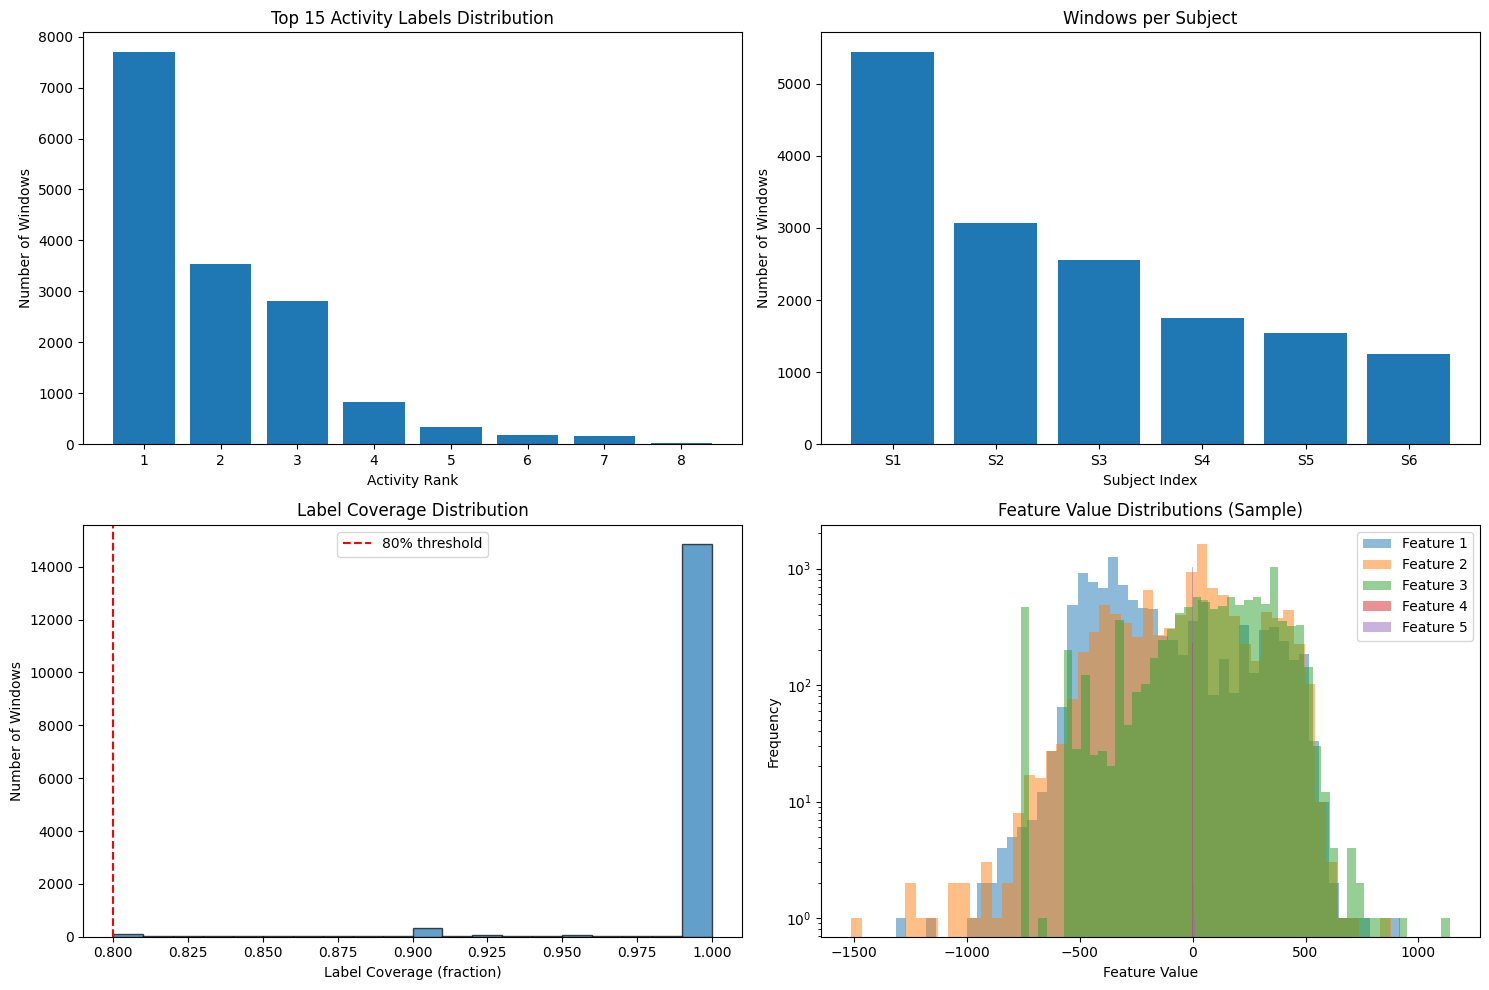

📊 Saved quality analysis plot: /scai_data3/scratch/stirnimann_r/results/pipeline/data_quality_analysis.png


In [7]:
# Data quality analysis and visualization
if 'combined_dataset' in locals():
    print(f"\n=== DATA QUALITY ANALYSIS ===")
    
    # Basic statistics
    windows = combined_dataset['windows']
    labels = combined_dataset['labels']
    window_info = combined_dataset['window_info']
    
    print(f"📊 Dataset Statistics:")
    print(f"  Shape: {windows.shape}")
    print(f"  Memory usage: {windows.nbytes / (1024**3):.2f} GB")
    print(f"  Data type: {windows.dtype}")
    
    # Check for NaN values
    nan_count = np.isnan(windows).sum()
    if nan_count > 0:
        print(f"⚠️ Found {nan_count:,} NaN values in windows")
    else:
        print(f"✅ No NaN values found")
    
    # Check for infinite values
    inf_count = np.isinf(windows).sum()
    if inf_count > 0:
        print(f"⚠️ Found {inf_count:,} infinite values in windows")
    else:
        print(f"✅ No infinite values found")
    
    # Analyze feature statistics
    print(f"\n📈 Feature Statistics:")
    feature_means = np.mean(windows, axis=(0, 1))
    feature_stds = np.std(windows, axis=(0, 1))
    feature_mins = np.min(windows, axis=(0, 1))
    feature_maxs = np.max(windows, axis=(0, 1))
    
    print(f"  Mean range: [{feature_means.min():.3f}, {feature_means.max():.3f}]")
    print(f"  Std range: [{feature_stds.min():.3f}, {feature_stds.max():.3f}]")
    print(f"  Min range: [{feature_mins.min():.3f}, {feature_mins.max():.3f}]")
    print(f"  Max range: [{feature_maxs.min():.3f}, {feature_maxs.max():.3f}]")
    
    # Label distribution visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Label distribution
    plt.subplot(2, 2, 1)
    top_labels = combined_dataset['label_counts'].head(15)
    plt.bar(range(len(top_labels)), top_labels.values)
    plt.title('Top 15 Activity Labels Distribution')
    plt.xlabel('Activity Rank')
    plt.ylabel('Number of Windows')
    plt.xticks(range(len(top_labels)), [f'{i+1}' for i in range(len(top_labels))])
    
    # Plot 2: Subject distribution
    plt.subplot(2, 2, 2)
    subject_counts = combined_dataset['subject_counts']
    plt.bar(range(len(subject_counts)), subject_counts.values)
    plt.title('Windows per Subject')
    plt.xlabel('Subject Index')
    plt.ylabel('Number of Windows')
    plt.xticks(range(len(subject_counts)), [f'S{i+1}' for i in range(len(subject_counts))])
    
    # Plot 3: Label coverage distribution
    plt.subplot(2, 2, 3)
    coverage_values = window_info['label_coverage']
    plt.hist(coverage_values, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Label Coverage Distribution')
    plt.xlabel('Label Coverage (fraction)')
    plt.ylabel('Number of Windows')
    plt.axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
    plt.legend()
    
    # Plot 4: Feature value distribution (sample of features)
    plt.subplot(2, 2, 4)
    # Sample first few features for visualization
    n_features_to_plot = min(5, windows.shape[2])
    for i in range(n_features_to_plot):
        feature_values = windows[:, :, i].flatten()
        # Sample for plotting (too many points otherwise)
        sample_size = min(10000, len(feature_values))
        sample_indices = np.random.choice(len(feature_values), sample_size, replace=False)
        sampled_values = feature_values[sample_indices]
        
        plt.hist(sampled_values, bins=50, alpha=0.5, label=f'Feature {i+1}')
    
    plt.title('Feature Value Distributions (Sample)')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(PIPELINE_RESULTS_DIR, 'data_quality_analysis.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Saved quality analysis plot: {plot_path}")
    
else:
    print(f"⚠️ No combined dataset available for analysis")

## 7. Data Export for Model Training

In [8]:
# Prepare data export for model training
if 'combined_dataset' in locals():
    print(f"\n=== PREPARING DATA FOR MODEL TRAINING ===")
    
    # Extract data
    X = combined_dataset['windows']  # Shape: (n_windows, window_size, n_features)
    y = combined_dataset['labels']   # Shape: (n_windows,)
    window_info = combined_dataset['window_info']
    sensor_config = combined_dataset['sensor_config']
    
    print(f"📊 Training Data Preparation:")
    print(f"  Features (X): {X.shape}")
    print(f"  Labels (y): {y.shape}")
    print(f"  Unique labels: {len(np.unique(y))}")
    print(f"  Sensor features: {sensor_config['n_sensor_features']}")
    print(f"  Sensor consistency: {'✅ Validated' if sensor_config['sensor_consistency_validated'] else '❌ Issues detected'}")
    
    # Create label encoder for converting string labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"  Encoded labels: {y_encoded.shape}")
    print(f"  Label range: [{y_encoded.min()}, {y_encoded.max()}]")
    
    # Show label mapping
    print(f"\n🏷️ Label Encoding Mapping:")
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    for i, (original_label, encoded_label) in enumerate(sorted(label_mapping.items(), key=lambda x: x[1])):
        if i < 15:  # Show first 15
            print(f"  {encoded_label:2d}: {original_label}")
        elif i == 15:
            print(f"  ... and {len(label_mapping) - 15} more labels")
            break
    
    # Subject-based train/test split information
    unique_subjects = window_info[SUBJECT_ID_COLUMN].unique()
    print(f"\n👥 Available Subjects for Train/Test Split:")
    for i, subject in enumerate(sorted(unique_subjects)):
        subject_windows = (window_info[SUBJECT_ID_COLUMN] == subject).sum()
        print(f"  📊 {subject}: {subject_windows:,} windows")
    
    # Display sensor configuration details
    print(f"\n🔧 Sensor Configuration Details:")
    print(f"  📋 Required sensors (manual list): {len(sensor_config['required_sensor_columns'])}")
    print(f"  ✅ Final sensors used: {len(sensor_config['final_sensor_columns'])}")
    
    print(f"  Required sensor features: {sensor_config['required_sensor_columns'][:5]}{'...' if len(sensor_config['required_sensor_columns']) > 5 else ''}")
    print(f"  Final sensor features: {sensor_config['final_sensor_columns'][:5]}{'...' if len(sensor_config['final_sensor_columns']) > 5 else ''}")
    
    # Create export data dictionary with full sensor information
    export_data = {
        'X': X,                           # Features (n_windows, window_size, n_features)
        'y': y,                          # Original string labels
        'y_encoded': y_encoded,          # Integer-encoded labels
        'window_info': window_info,      # Metadata for each window
        'label_encoder': label_encoder,  # For converting back to original labels
        'label_mapping': label_mapping,  # Original -> encoded mapping
        'config': combined_dataset['config'],
        'sensor_config': sensor_config,  # Detailed sensor configuration
        'metadata': combined_dataset['metadata']
    }
    
    # Save export data
    export_path = os.path.join(PIPELINE_RESULTS_DIR, 'model_training_data.pkl')
    with open(export_path, 'wb') as f:
        pickle.dump(export_data, f)
    
    print(f"\n💾 Saved training data: {export_path}")
    
    # Save label encoder separately for easy access
    label_encoder_path = os.path.join(PIPELINE_RESULTS_DIR, 'label_encoder.pkl')
    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print(f"💾 Saved label encoder: {label_encoder_path}")
    
    # Create a comprehensive summary report
    summary_report = {
        'dataset_summary': {
            'total_windows': int(X.shape[0]),
            'window_size': int(X.shape[1]),
            'n_features': int(X.shape[2]),
            'n_unique_labels': len(np.unique(y)),
            'n_subjects': len(unique_subjects),
            'subjects': sorted(unique_subjects.tolist())
        },
        'window_config': {
            'window_size_samples': WINDOW_SIZE,
            'window_step_samples': WINDOW_STEP,
            'window_duration_seconds': WINDOW_DURATION_SEC,
            'step_duration_seconds': STEP_DURATION_SEC,
            'overlap_percentage': ((WINDOW_SIZE - WINDOW_STEP) / WINDOW_SIZE * 100)
        },
        'sensor_configuration': {
            'required_sensor_columns': REQUIRED_SENSOR_COLUMNS,
            'final_sensor_columns': sensor_config['final_sensor_columns'],
            'n_required_sensors': len(REQUIRED_SENSOR_COLUMNS),
            'n_final_sensors': len(sensor_config['final_sensor_columns']),
            'sensor_consistency_validated': sensor_config['sensor_consistency_validated']
        },
        'label_distribution': combined_dataset['label_counts'].head(20).to_dict(),
        'subject_distribution': combined_dataset['subject_counts'].to_dict(),
        'data_quality': {
            'nan_values': int(np.isnan(X).sum()),
            'inf_values': int(np.isinf(X).sum()),
            'feature_mean_range': [float(np.mean(X, axis=(0, 1)).min()), 
                                  float(np.mean(X, axis=(0, 1)).max())],
            'feature_std_range': [float(np.std(X, axis=(0, 1)).min()), 
                                 float(np.std(X, axis=(0, 1)).max())]
        }
    }
    
    # Save comprehensive summary report
    summary_path = os.path.join(PIPELINE_RESULTS_DIR, 'pipeline_summary_report.json')
    with open(summary_path, 'w') as f:
        json.dump(summary_report, f, indent=2, default=str)
    
    print(f"📋 Saved comprehensive summary report: {summary_path}")
    
    # Validation summary
    print(f"\n🔍 FINAL VALIDATION SUMMARY:")
    print(f"  ✅ Sensor columns consistent across subjects: {'YES' if sensor_config['sensor_consistency_validated'] else 'NO'}")
    print(f"  📊 Total sensor features per window: {sensor_config['n_sensor_features']}")
    print(f"  🎯 Data shape: {X.shape} (windows, timesteps, features)")
    print(f"  📈 Ready for model training: {'YES' if sensor_config['sensor_consistency_validated'] else 'YES (with warnings)'}")
    
    if not sensor_config['sensor_consistency_validated']:
        print(f"\n⚠️  WARNING: Sensor inconsistencies were detected during processing.")
        print(f"   Review the logs above for details. This may impact model performance.")
        print(f"   Consider re-running data preprocessing to resolve inconsistencies.")
    
else:
    print(f"⚠️ No combined dataset available for export")

print(f"\n✅ Pipeline completed successfully!")
print(f"📁 All outputs saved to: {PIPELINE_RESULTS_DIR}")
print(f"🚀 Ready for model training!")

# Final sensor configuration verification
if 'sensor_config' in locals():
    print(f"\n📋 FINAL SENSOR CONFIGURATION VERIFICATION:")
    print(f"  🔧 Manual sensor list: {len(REQUIRED_SENSOR_COLUMNS)}")
    print(f"  📊 Actual final sensors: {sensor_config['n_sensor_features']}")
    print(f"  🎯 Match: {'✅ YES' if len(REQUIRED_SENSOR_COLUMNS) == sensor_config['n_sensor_features'] else '❌ NO'}")
    
    if len(REQUIRED_SENSOR_COLUMNS) != sensor_config['n_sensor_features']:
        print(f"     Expected: {REQUIRED_SENSOR_COLUMNS[:5]}{'...' if len(REQUIRED_SENSOR_COLUMNS) > 5 else ''}")
        print(f"     Actual: {sensor_config['final_sensor_columns'][:5]}{'...' if len(sensor_config['final_sensor_columns']) > 5 else ''}")
    else:
        print(f"  ✨ Perfect! All subjects have exactly the {len(REQUIRED_SENSOR_COLUMNS)} sensors specified.")


=== PREPARING DATA FOR MODEL TRAINING ===
📊 Training Data Preparation:
  Features (X): (15604, 250, 26)
  Labels (y): (15604,)
  Unique labels: 8
  Sensor features: 26
  Sensor consistency: ✅ Validated
  Encoded labels: (15604,)
  Label range: [0, 7]

🏷️ Label Encoding Mapping:
   0: Arm Raises
   1: Assisted Propulsion
   2: Changing Clothes
   3: Conversation
   4: Eating
   5: Resting
   6: Self Propulsion
   7: Transfer

👥 Available Subjects for Train/Test Split:
  📊 OutSense-036: 1,250 windows
  📊 OutSense-293: 2,555 windows
  📊 OutSense-498: 1,747 windows
  📊 OutSense-515: 3,064 windows
  📊 OutSense-713: 1,547 windows
  📊 OutSense-991: 5,441 windows

🔧 Sensor Configuration Details:
  📋 Required sensors (manual list): 26
  ✅ Final sensors used: 26
  Required sensor features: ['corsano_wrist_wrist_acc_x', 'corsano_wrist_wrist_acc_y', 'corsano_wrist_wrist_acc_z', 'mbient_acc_x_axis_g', 'mbient_acc_y_axis_g']...
  Final sensor features: ['corsano_wrist_wrist_acc_x', 'corsano_wrist_w

## 8. Next Steps

The pipeline has successfully processed the sensor data and created windowed datasets ready for machine learning model training.

### Output Files Created:
1. **`{subject}_windowed_data.pkl`** - Individual subject windowed data
2. **`combined_windowed_dataset.pkl`** - Combined dataset from all subjects
3. **`model_training_data.pkl`** - Processed data ready for model training
4. **`label_encoder.pkl`** - Label encoder for converting between string and integer labels
5. **`pipeline_summary_report.json`** - Summary statistics and configuration
6. **`data_quality_analysis.png`** - Visualization of data quality metrics

### Key Features:
- **Sliding Windows**: Configurable window size and step size from config.yaml
- **Label Alignment**: Majority voting for window labels with coverage tracking
- **Multi-Subject Support**: Handles multiple subjects with subject ID tracking
- **Data Quality**: Comprehensive quality checks and missing data handling
- **Model Ready**: Properly formatted arrays for deep learning models

### Ready for Model Implementation:
- **Input Shape**: (n_windows, window_size, n_features)
- **Label Encoding**: Both original strings and integer encoding available
- **Train/Test Split**: Subject-based splitting recommended for temporal validation
- **Preprocessing**: Data cleaned and quality validated

The next step is to implement the model architecture (e.g., 1D CNN, LSTM, or hybrid models) using the processed data from this pipeline.

## 9. Interactive Window Plotting

Interactive visualization tool for exploring windowed sensor data. You can:
- Select specific subjects and activities
- Choose number of random windows to plot
- View all sensor channels overlaid in a single plot
- Analyze sensor patterns for different activities

In [9]:
# Interactive Window Plotting Tool
import random
from IPython.display import display
import ipywidgets as widgets

def plot_random_windows(subject_id=None, activity=None, max_plots=3, seed=None):
    """
    Plot random windows for a specific subject and activity with all sensor channels overlaid
    
    Parameters:
    - subject_id: Subject to plot (e.g., 'OutSense-498')
    - activity: Activity to plot (e.g., 'Walking')
    - max_plots: Maximum number of windows to plot
    - seed: Random seed for reproducible results
    """
    
    # Check if we have processed data
    if 'combined_dataset' not in locals() and 'combined_dataset' not in globals():
        print("❌ No combined dataset found!")
        print("Please run the pipeline first to create windowed data.")
        return
    
    # Get the combined dataset
    if 'combined_dataset' in locals():
        dataset = combined_dataset
    else:
        dataset = globals()['combined_dataset']
    
    windows = dataset['windows']
    labels = dataset['labels']
    window_info = dataset['window_info']
    sensor_columns = dataset['sensor_config']['final_sensor_columns']
    
    print(f"🎯 Interactive Window Plotting")
    print(f"  Dataset: {windows.shape[0]:,} windows, {windows.shape[2]} sensors")
    print(f"  Available subjects: {sorted(window_info[SUBJECT_ID_COLUMN].unique())}")
    print(f"  Available activities: {len(np.unique(labels))} unique activities")
    
    # Filter by subject if specified
    mask = np.ones(len(labels), dtype=bool)
    filter_info = []
    
    if subject_id:
        subject_mask = window_info[SUBJECT_ID_COLUMN] == subject_id
        mask = mask & subject_mask
        filter_info.append(f"Subject: {subject_id}")
        
        if not subject_mask.any():
            print(f"❌ No windows found for subject: {subject_id}")
            available_subjects = sorted(window_info[SUBJECT_ID_COLUMN].unique())
            print(f"Available subjects: {available_subjects}")
            return
    
    # Filter by activity if specified
    if activity:
        activity_mask = labels == activity
        mask = mask & activity_mask
        filter_info.append(f"Activity: {activity}")
        
        if not activity_mask.any():
            print(f"❌ No windows found for activity: {activity}")
            available_activities = sorted(np.unique(labels))[:20]  # Show first 20
            print(f"Available activities (first 20): {available_activities}")
            return
    
    # Get filtered data
    filtered_indices = np.where(mask)[0]
    filtered_windows = windows[filtered_indices]
    filtered_labels = labels[filtered_indices]
    filtered_window_info = window_info.iloc[filtered_indices]
    
    print(f"\n📊 Filtering Results:")
    if filter_info:
        print(f"  Filters: {', '.join(filter_info)}")
    print(f"  Matching windows: {len(filtered_indices):,}")
    
    if len(filtered_indices) == 0:
        print("❌ No windows match the specified criteria!")
        return
    
    # Randomly select windows to plot
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    n_plots = min(max_plots, len(filtered_indices))
    selected_indices = np.random.choice(len(filtered_indices), n_plots, replace=False)
    
    print(f"  Selected {n_plots} random windows for plotting")
    
    # Create time axis (in seconds)
    time_axis = np.arange(windows.shape[1]) / SAMPLING_FREQ
    
    # Create plots
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots))
    if n_plots == 1:
        axes = [axes]
    
    # Define colors for different sensor types (cycling through if more sensors than colors)
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 20 distinct colors
    
    for plot_idx, sel_idx in enumerate(selected_indices):
        window_data = filtered_windows[sel_idx]
        window_label = filtered_labels[sel_idx]
        window_meta = filtered_window_info.iloc[sel_idx]
        
        ax = axes[plot_idx]
        
        # Plot all sensor channels
        for sensor_idx, sensor_name in enumerate(sensor_columns):
            color = colors[sensor_idx % len(colors)]
            
            # Create abbreviated sensor name for legend
            if len(sensor_name) > 25:
                short_name = sensor_name[:12] + '...' + sensor_name[-10:]
            else:
                short_name = sensor_name
            
            ax.plot(time_axis, window_data[:, sensor_idx], 
                   color=color, alpha=0.7, linewidth=1.0, label=short_name)
        
        # Formatting
        ax.set_title(f'Window {plot_idx + 1}: {window_label} | Subject: {window_meta[SUBJECT_ID_COLUMN]}\\n'
                    f'Time: {window_meta["start_time"]} | Coverage: {window_meta["label_coverage"]:.2f}',
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Sensor Values')
        ax.grid(True, alpha=0.3)
        
        # Add legend with multiple columns to save space
        n_cols = min(4, len(sensor_columns))
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=n_cols, fontsize=8)
        
        # Add statistics text box
        stats_text = (f'Min: {window_data.min():.2f}\\n'
                     f'Max: {window_data.max():.2f}\\n'
                     f'Mean: {window_data.mean():.2f}\\n'
                     f'Std: {window_data.std():.2f}')
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary information
    print(f"\\n📈 Plotted Window Details:")
    for plot_idx, sel_idx in enumerate(selected_indices):
        window_meta = filtered_window_info.iloc[sel_idx]
        print(f"  Window {plot_idx + 1}: {filtered_labels[sel_idx]} | "
              f"Subject: {window_meta[SUBJECT_ID_COLUMN]} | "
              f"Coverage: {window_meta['label_coverage']:.2f} | "
              f"Window ID: {window_meta['window_id']}")

def get_available_options():
    """Get available subjects and activities for plotting"""
    if 'combined_dataset' not in locals() and 'combined_dataset' not in globals():
        print("❌ No combined dataset found! Run the pipeline first.")
        return None, None
    
    # Get the combined dataset
    if 'combined_dataset' in locals():
        dataset = combined_dataset
    else:
        dataset = globals()['combined_dataset']
    
    window_info = dataset['window_info']
    labels = dataset['labels']
    
    subjects = sorted(window_info[SUBJECT_ID_COLUMN].unique())
    activities = sorted(np.unique(labels))
    
    print(f"📋 Available Options:")
    print(f"  Subjects ({len(subjects)}): {subjects}")
    print(f"  Activities ({len(activities)}): {activities[:15]}{'...' if len(activities) > 15 else ''}")
    
    return subjects, activities

def quick_activity_overview():
    """Show activity distribution per subject"""
    if 'combined_dataset' not in locals() and 'combined_dataset' not in globals():
        print("❌ No combined dataset found! Run the pipeline first.")
        return
    
    # Get the combined dataset
    if 'combined_dataset' in locals():
        dataset = combined_dataset
    else:
        dataset = globals()['combined_dataset']
    
    window_info = dataset['window_info']
    labels = dataset['labels']
    
    print(f"📊 Activity Distribution by Subject:")
    
    for subject in sorted(window_info[SUBJECT_ID_COLUMN].unique()):
        subject_mask = window_info[SUBJECT_ID_COLUMN] == subject
        subject_labels = labels[subject_mask]
        subject_activity_counts = pd.Series(subject_labels).value_counts()
        
        print(f"\\n  {subject} ({len(subject_labels):,} windows):")
        for i, (activity, count) in enumerate(subject_activity_counts.head(10).items()):
            percentage = count / len(subject_labels) * 100
            print(f"    {i+1:2d}. {activity}: {count:,} ({percentage:.1f}%)")
        
        if len(subject_activity_counts) > 10:
            remaining = len(subject_activity_counts) - 10
            print(f"        ... and {remaining} more activities")

# Run helper functions
print("🎯 Interactive Window Plotting Tools Ready!")
print("\\nAvailable functions:")
print("  📊 get_available_options() - Show available subjects and activities")
print("  📈 quick_activity_overview() - Show activity distribution by subject")
print("  🎨 plot_random_windows(subject_id, activity, max_plots, seed) - Plot random windows")
print("\\nExample usage:")
print("  plot_random_windows('OutSense-498', 'Walking', max_plots=2, seed=42)")
print("  plot_random_windows(activity='Resting', max_plots=3)")
print("  plot_random_windows(subject_id='OutSense-515', max_plots=5)")

# Show available options
if 'combined_dataset' in locals() or 'combined_dataset' in globals():
    print("\\n" + "="*60)
    get_available_options()
else:
    print("\\n⚠️ Run the pipeline first to enable interactive plotting!")

🎯 Interactive Window Plotting Tools Ready!
\nAvailable functions:
  📊 get_available_options() - Show available subjects and activities
  📈 quick_activity_overview() - Show activity distribution by subject
  🎨 plot_random_windows(subject_id, activity, max_plots, seed) - Plot random windows
\nExample usage:
  plot_random_windows('OutSense-498', 'Walking', max_plots=2, seed=42)
  plot_random_windows(activity='Resting', max_plots=3)
  plot_random_windows(subject_id='OutSense-515', max_plots=5)
\n============================================================
📋 Available Options:
  Subjects (6): ['OutSense-036', 'OutSense-293', 'OutSense-498', 'OutSense-515', 'OutSense-713', 'OutSense-991']
  Activities (8): [np.str_('Arm Raises'), np.str_('Assisted Propulsion'), np.str_('Changing Clothes'), np.str_('Conversation'), np.str_('Eating'), np.str_('Resting'), np.str_('Self Propulsion'), np.str_('Transfer')]


In [10]:
# === INTERACTIVE PLOTTING EXAMPLES ===
# Uncomment and run any of these examples to start plotting!

# 1. Get overview of available data
# get_available_options()
# quick_activity_overview()

# 2. Plot examples for specific subjects and activities
# Replace with your actual subject IDs and activities

# Example 1: Plot 3 random walking windows from any subject
# plot_random_windows(activity='Walking', max_plots=3, seed=42)

# Example 2: Plot 2 random windows from a specific subject 
# plot_random_windows(subject_id='OutSense-498', max_plots=2, seed=123)

# Example 3: Plot 1 specific activity from a specific subject
# plot_random_windows(subject_id='OutSense-515', activity='Resting', max_plots=1, seed=456)

# Example 4: Plot 5 random windows from any subject/activity
# plot_random_windows(max_plots=5, seed=789)

# === QUICK START ===
# 1. First, check what subjects and activities are available:
print("🚀 QUICK START GUIDE:")
print("1. Run: get_available_options()")
print("2. Run: quick_activity_overview()")
print("3. Choose your subject/activity and run plot_random_windows()")
print("\\nExample workflow:")
print("  get_available_options()")
print("  plot_random_windows('OutSense-498', 'Walking', max_plots=2)")
print("\\n" + "="*60)

plot_random_windows('OutSense-619', 'Self Propulsion', max_plots=1)

🚀 QUICK START GUIDE:
1. Run: get_available_options()
2. Run: quick_activity_overview()
3. Choose your subject/activity and run plot_random_windows()
\nExample workflow:
  get_available_options()
  plot_random_windows('OutSense-498', 'Walking', max_plots=2)
\n============================================================
🎯 Interactive Window Plotting
  Dataset: 15,604 windows, 26 sensors
  Available subjects: ['OutSense-036', 'OutSense-293', 'OutSense-498', 'OutSense-515', 'OutSense-713', 'OutSense-991']
  Available activities: 8 unique activities
❌ No windows found for subject: OutSense-619
Available subjects: ['OutSense-036', 'OutSense-293', 'OutSense-498', 'OutSense-515', 'OutSense-713', 'OutSense-991']


## 10. MCA-TCN Model Implementation

**Multi-Channel Attention Temporal Convolutional Network (MCA-TCN) for Activity Classification**

This section implements an enhanced TCN with multi-channel attention mechanism for interpretable time series classification. Key features:

1. **Multi-Channel Attention**: Applies channel-wise attention to identify important sensors/features
2. **Hyperparameter Optimization**: Uses Optuna for automated hyperparameter tuning
3. **Interpretability**: Visualizes attention weights to understand model decision-making
4. **Uncertainty Quantification**: Monte Carlo Dropout for prediction uncertainty estimation
5. **Modular Architecture**: Separates feature extraction from classification for flexibility

The attention mechanism allows inspection of which channels (sensors) the model considers most important for different activity classifications, providing valuable insights into the model's decision-making process.

In [11]:
# MCA-TCN Model Configuration and Parameters
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import optuna
import warnings

# Suppress weight_norm deprecation warning
warnings.filterwarnings("ignore", message="`torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.", category=FutureWarning, module="torch.nn.utils.weight_norm")

print("🧠 MCA-TCN Model Configuration")

# === MODEL TRAINING PARAMETERS ===
NUM_EPOCHS = 50  # Max epochs for final training, early stopping will determine actual
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.0001

# === MONTE CARLO DROPOUT CONFIGURATION ===
MC_DROPOUT_SAMPLES = 100  # Number of forward passes for Monte Carlo Dropout. Set to 0 to disable.

# === DYNAMIC LOSS WEIGHTING CONFIGURATION ===
USE_DYNAMIC_LOSS_WEIGHTING = True  # Enable dynamic loss weighting based on confidence
DYNAMIC_LOSS_ALPHA = 2.0  # Alpha parameter for dynamic weighting (1-3 recommended range)

# === SELF-PACED LEARNING CONFIGURATION ===
USE_SELF_PACED_LEARNING = True  # Enable self-paced learning (sample reweighting by history)
SPL_WARMUP_EPOCHS = 5  # Number of epochs before starting to track sample history
SPL_DECAY_RATE = 0.95  # Weight decay rate for persistently misclassified samples (0.9-0.99 recommended)
SPL_MIN_WEIGHT = 0.05  # Minimum weight for any sample (prevents complete exclusion)
SPL_MEMORY_LENGTH = 5  # Number of recent epochs to consider for misclassification history

# === TRAINING DISPLAY CONFIGURATION ===
DISPLAY_TEST_LOSS_DURING_TRAINING = True  # Set to False if you want to hide test loss during training
PRINT_EPOCH_FREQUENCY = 1  # Print progress every N epochs

# === OUTPUT PATHS ===
MODELS_OUTPUT_DIR = os.path.join(PIPELINE_RESULTS_DIR, "models")
MODEL_FILENAME = "mcatcn_classifier_best_model_tuned.pth"
LAST_MODEL_FILENAME = "mcatcn_classifier_last_model_tuned.pth"
SCALER_FILENAME = "scaler_for_mcatcn_tuned.pkl"
ENCODER_FILENAME = "label_encoder_for_mcatcn_tuned.pkl"

# === HYPERPARAMETER TUNING CONFIGURATION ===
NUM_OPTUNA_TRIALS = 200  # Number of HPO trials to run
CV_N_SPLITS = 4  # Number of folds for cross-validation during HPO
HPO_PATIENCE = 5  # Early stopping patience within HPO folds
HPO_MAX_EPOCHS = 20  # Max epochs within HPO folds

# === DATASET BALANCING CONFIGURATION ===
ENABLE_DATASET_BALANCING = True  # Enable/disable dataset balancing
BALANCING_STRATEGY = 'median'  # 'auto' (minority class), 'median', or specific int

# Test Subjects
TEST_SUBJECTS = config.get('test_subjects', [])
TRAIN_SUBJECTS = config.get('train_subjects', [])

# Create models directory
os.makedirs(MODELS_OUTPUT_DIR, exist_ok=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {n_gpus}")
    for i in range(n_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Running on CPU.")
    n_gpus = 0

print(f"✅ MCA-TCN Configuration:")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"  Monte Carlo dropout samples: {MC_DROPOUT_SAMPLES}")
print(f"  Dynamic loss weighting: {USE_DYNAMIC_LOSS_WEIGHTING}")
print(f"  Self-paced learning: {USE_SELF_PACED_LEARNING}")
print(f"  Optuna trials: {NUM_OPTUNA_TRIALS}")
print(f"  CV folds: {CV_N_SPLITS}")
print(f"  Dataset balancing: {'✅ Enabled' if ENABLE_DATASET_BALANCING else '❌ Disabled'}")
print(f"  Balancing strategy: {BALANCING_STRATEGY}")
print(f"  Models output directory: {MODELS_OUTPUT_DIR}")

# Check if we have the combined dataset available
if 'combined_dataset' in locals():
    print(f"\n📊 Available Data:")
    print(f"  Combined dataset available: ✅")
    print(f"  Windows shape: {combined_dataset['windows'].shape}")
    print(f"  Labels: {len(combined_dataset['labels']):,}")
    print(f"  Unique activities: {len(np.unique(combined_dataset['labels']))}")
    print(f"  Subjects: {len(combined_dataset['subject_counts'])}")
else:
    print(f"\n⚠️ No combined dataset found! Please run the pipeline first.")

# Set random seeds for reproducibility
np.random.seed(126)
torch.manual_seed(126)
if torch.cuda.is_available():
    torch.cuda.manual_seed(126)
    torch.cuda.manual_seed_all(126)

🧠 MCA-TCN Model Configuration
Number of available GPUs: 1
  GPU 0: NVIDIA GeForce RTX 3090
✅ MCA-TCN Configuration:
  Max epochs: 50
  Early stopping patience: 10
  Monte Carlo dropout samples: 100
  Dynamic loss weighting: True
  Self-paced learning: True
  Optuna trials: 200
  CV folds: 4
  Dataset balancing: ✅ Enabled
  Balancing strategy: median
  Models output directory: /scai_data3/scratch/stirnimann_r/results/pipeline/models

📊 Available Data:
  Combined dataset available: ✅
  Windows shape: (15604, 250, 26)
  Labels: 15,604
  Unique activities: 8
  Subjects: 6


In [12]:
# MCA-TCN Model Architecture Definitions

class Chomp1d(nn.Module):
    """Removes elements from the end of a tensor to ensure causality in TCN"""
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    """Basic building block of TCN with dilated convolutions and residual connections"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, 
                                          stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, 
                                          stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class MultiChannelAttention(nn.Module):
    """Multi-Channel Attention module for identifying important sensors/features"""
    def __init__(self, num_channels, reduction_ratio=16):
        super(MultiChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction_ratio, num_channels, bias=False),
            nn.Sigmoid()
        )
        # Store attention weights for interpretability
        self.attention_weights = None

    def forward(self, x):
        # x shape: (batch_size, num_channels, seq_len)
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)  # Squeeze
        attention_weights = self.fc(y)  # Get attention weights before reshaping
        self.attention_weights = attention_weights.detach()  # Store for visualization
        y = attention_weights.view(b, c, 1)  # Excitation
        return x * y.expand_as(x)  # Rescale

class MCATCNFeatureExtractor(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2, attention_reduction_ratio=16):
        super(MCATCNFeatureExtractor, self).__init__()
        
        # Apply attention first, on the original input channels
        self.attention = MultiChannelAttention(num_inputs, reduction_ratio=attention_reduction_ratio)
        
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation_size,
                                   padding=(kernel_size-1) * dilation_size, 
                                   dropout=dropout)]

        self.tcn = nn.Sequential(*layers)
        self.feature_dim = num_channels[-1]

    def forward(self, x, return_full_sequence=False):
        """
        Forward pass that stops before the linear classification layer.
        
        Args:
            x: Input tensor of shape (batch_size, num_inputs, seq_len)
            return_full_sequence: If True, returns full sequence features (batch_size, feature_dim, seq_len)
                                If False, returns last time step features (batch_size, feature_dim)
        
        Returns:
            Feature tensor
        """
        # 1. Apply attention to the input sensor channels first
        y = self.attention(x)
        
        # 2. Pass the attention-weighted features to the TCN
        y = self.tcn(y)
        
        if return_full_sequence:
            return y
        else:
            return y[:, :, -1]
    
    def enable_dropout(self):
        """Function to enable the dropout layers during inference for Monte Carlo Dropout."""
        for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()
    
    def get_attention_weights(self):
        """Get the last computed attention weights from the attention layer."""
        return self.attention.attention_weights

print("✅ MCA-TCN Architecture Components Defined:")
print("  📦 Chomp1d - Causal padding removal")
print("  🔧 TemporalBlock - TCN building block with dilated convolutions")
print("  🎯 MultiChannelAttention - Attention mechanism for sensor importance")
print("  🏗️ MCATCNFeatureExtractor - Modular feature extraction")

✅ MCA-TCN Architecture Components Defined:
  📦 Chomp1d - Causal padding removal
  🔧 TemporalBlock - TCN building block with dilated convolutions
  🎯 MultiChannelAttention - Attention mechanism for sensor importance
  🏗️ MCATCNFeatureExtractor - Modular feature extraction


In [13]:
# Classifier Head Architectures

class MLPClassifierHead(nn.Module):
    """Multi-Layer Perceptron classifier head"""
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(MLPClassifierHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

class DeepMLPClassifierHead(nn.Module):
    """Deeper MLP classifier head with multiple hidden layers"""
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.5):
        super(DeepMLPClassifierHead, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Final classification layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class AttentionPoolingClassifierHead(nn.Module):
    """Classifier head that uses attention pooling over the full sequence features"""
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(AttentionPoolingClassifierHead, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, num_classes)
        )
    
    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, feature_dim, seq_len)
        """
        # Transpose to (batch_size, seq_len, feature_dim) for attention
        x = x.transpose(1, 2)
        
        # Compute attention weights
        attention_scores = self.attention(x)  # (batch_size, seq_len, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Apply attention pooling
        pooled_features = torch.sum(attention_weights * x, dim=1)  # (batch_size, feature_dim)
        
        # Classify
        return self.classifier(pooled_features)

class LSTMClassifierHead(nn.Module):
    """LSTM-based classifier head that processes the full sequence features"""
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(LSTMClassifierHead, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, feature_dim, seq_len)
        """
        # Transpose to (batch_size, seq_len, feature_dim) for LSTM
        x = x.transpose(1, 2)
        
        # LSTM processing
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state
        last_hidden = h_n[-1]  # (batch_size, hidden_dim)
        
        # Apply dropout and classify
        out = self.dropout(last_hidden)
        return self.classifier(out)

class ModularMCATCNModel(nn.Module):
    """Modular MCA-TCN that combines a feature extractor with a classifier head"""
    def __init__(self, feature_extractor, classifier_head, use_full_sequence=False):
        super(ModularMCATCNModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier_head = classifier_head
        self.use_full_sequence = use_full_sequence
    
    def forward(self, x):
        features = self.feature_extractor(x, return_full_sequence=self.use_full_sequence)
        return self.classifier_head(features)
    
    def forward_with_attention(self, x):
        """Forward pass that returns both predictions and attention weights."""
        features = self.feature_extractor(x, return_full_sequence=self.use_full_sequence)
        predictions = self.classifier_head(features)
        attention_weights = self.feature_extractor.get_attention_weights()
        return predictions, attention_weights
    
    def enable_dropout(self):
        """Function to enable the dropout layers during inference for Monte Carlo Dropout."""
        self.feature_extractor.enable_dropout()
        for m in self.classifier_head.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()
    
    def get_attention_weights(self):
        """Get the last computed attention weights from the feature extractor."""
        return self.feature_extractor.get_attention_weights()

print("✅ Classifier Head Architectures Defined:")
print("  🧠 MLPClassifierHead - Simple MLP with one hidden layer")
print("  🧠 DeepMLPClassifierHead - Deep MLP with multiple hidden layers")
print("  🎯 AttentionPoolingClassifierHead - Attention-based pooling")
print("  🔄 LSTMClassifierHead - LSTM-based temporal modeling")
print("  🏗️ ModularMCATCNModel - Combines feature extractor with classifier head")

✅ Classifier Head Architectures Defined:
  🧠 MLPClassifierHead - Simple MLP with one hidden layer
  🧠 DeepMLPClassifierHead - Deep MLP with multiple hidden layers
  🎯 AttentionPoolingClassifierHead - Attention-based pooling
  🔄 LSTMClassifierHead - LSTM-based temporal modeling
  🏗️ ModularMCATCNModel - Combines feature extractor with classifier head


In [14]:
# Factory Functions for Creating MCA-TCN Models

def create_mcatcn_with_mlp_head(num_inputs, tcn_channels, num_classes, hidden_dim=None, 
                               kernel_size=2, dropout=0.2, attention_reduction_ratio=16, 
                               classifier_dropout=0.5):
    """Factory function to create MCA-TCN with simple MLP head"""
    if hidden_dim is None:
        hidden_dim = tcn_channels[-1]
    
    feature_extractor = MCATCNFeatureExtractor(
        num_inputs=num_inputs,
        num_channels=tcn_channels,
        kernel_size=kernel_size,
        dropout=dropout,
        attention_reduction_ratio=attention_reduction_ratio
    )
    
    classifier_head = MLPClassifierHead(
        input_dim=tcn_channels[-1],
        hidden_dim=hidden_dim,
        num_classes=num_classes,
        dropout=classifier_dropout
    )
    
    return ModularMCATCNModel(feature_extractor, classifier_head, use_full_sequence=False)

def create_mcatcn_with_deep_mlp_head(num_inputs, tcn_channels, num_classes, hidden_dims=None, 
                                   kernel_size=2, dropout=0.2, attention_reduction_ratio=16, 
                                   classifier_dropout=0.5):
    """Factory function to create MCA-TCN with deep MLP head"""
    if hidden_dims is None:
        hidden_dims = [tcn_channels[-1], tcn_channels[-1] // 2]
    
    feature_extractor = MCATCNFeatureExtractor(
        num_inputs=num_inputs,
        num_channels=tcn_channels,
        kernel_size=kernel_size,
        dropout=dropout,
        attention_reduction_ratio=attention_reduction_ratio
    )
    
    classifier_head = DeepMLPClassifierHead(
        input_dim=tcn_channels[-1],
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        dropout=classifier_dropout
    )
    
    return ModularMCATCNModel(feature_extractor, classifier_head, use_full_sequence=False)

def create_mcatcn_model_by_type(classifier_head_type, num_inputs, tcn_channels, num_classes,
                               kernel_size=2, dropout=0.2, attention_reduction_ratio=16, 
                               classifier_dropout=0.5, **kwargs):
    """Factory function to create MCA-TCN model with specified classifier head type"""
    
    if classifier_head_type == 'mlp':
        return create_mcatcn_with_mlp_head(
            num_inputs=num_inputs,
            tcn_channels=tcn_channels,
            num_classes=num_classes,
            hidden_dim=tcn_channels[-1],
            kernel_size=kernel_size,
            dropout=dropout,
            attention_reduction_ratio=attention_reduction_ratio,
            classifier_dropout=classifier_dropout
        )
    
    elif classifier_head_type == 'deep_mlp':
        num_layers = kwargs.get('num_layers', 2)
        hidden_dims = [tcn_channels[-1]]
        for _ in range(num_layers - 1):
            hidden_dims.append(hidden_dims[-1] // 2)
        
        return create_mcatcn_with_deep_mlp_head(
            num_inputs=num_inputs,
            tcn_channels=tcn_channels,
            num_classes=num_classes,
            hidden_dims=hidden_dims,
            kernel_size=kernel_size,
            dropout=dropout,
            attention_reduction_ratio=attention_reduction_ratio,
            classifier_dropout=classifier_dropout
        )
    
    else:
        raise ValueError(f"Unsupported classifier_head_type: {classifier_head_type}. "
                        f"Supported types are: 'mlp', 'deep_mlp'")

def create_mcatcn_model_with_tuned_params(classifier_head_type, classifier_params, num_inputs, 
                                        tcn_channels, num_classes, kernel_size=2, dropout=0.2, 
                                        attention_reduction_ratio=16, classifier_dropout=0.5):
    """Create MCA-TCN model with tuned classifier head parameters"""
    
    if classifier_head_type == 'mlp':
        hidden_multiplier = classifier_params.get("hidden_multiplier", 1.0)
        hidden_dim = int(tcn_channels[-1] * hidden_multiplier)
        return create_mcatcn_with_mlp_head(
            num_inputs=num_inputs,
            tcn_channels=tcn_channels,
            num_classes=num_classes,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            dropout=dropout,
            attention_reduction_ratio=attention_reduction_ratio,
            classifier_dropout=classifier_dropout
        )
    
    elif classifier_head_type == 'deep_mlp':
        num_layers = classifier_params.get("num_layers", 2)
        dim_reduction = classifier_params.get("dim_reduction", 0.5)
        
        hidden_dims = []
        current_dim = tcn_channels[-1]
        for i in range(num_layers):
            hidden_dims.append(int(current_dim))
            current_dim = int(current_dim * dim_reduction)
        
        return create_mcatcn_with_deep_mlp_head(
            num_inputs=num_inputs,
            tcn_channels=tcn_channels,
            num_classes=num_classes,
            hidden_dims=hidden_dims,
            kernel_size=kernel_size,
            dropout=dropout,
            attention_reduction_ratio=attention_reduction_ratio,
            classifier_dropout=classifier_dropout
        )
    
    else:
        raise ValueError(f"Unsupported classifier_head_type: {classifier_head_type}")

print("✅ MCA-TCN Factory Functions Defined:")
print("  🏭 create_mcatcn_with_mlp_head - Simple MLP classifier")
print("  🏭 create_mcatcn_with_deep_mlp_head - Deep MLP classifier")
print("  🏭 create_mcatcn_model_by_type - Generic factory with type specification")
print("  🏭 create_mcatcn_model_with_tuned_params - Factory with hyperparameter tuning")

✅ MCA-TCN Factory Functions Defined:
  🏭 create_mcatcn_with_mlp_head - Simple MLP classifier
  🏭 create_mcatcn_with_deep_mlp_head - Deep MLP classifier
  🏭 create_mcatcn_model_by_type - Generic factory with type specification
  🏭 create_mcatcn_model_with_tuned_params - Factory with hyperparameter tuning


### Dataset Balancing

**Automated Dataset Balancing for Robust Training**

To address class imbalance issues that can bias model training, this pipeline includes automated dataset balancing through intelligent undersampling:

#### **🎯 Key Features:**

1. **⚖️ Configurable Balancing**: Enable/disable balancing via `ENABLE_DATASET_BALANCING` parameter
2. **📊 Multiple Strategies**: 
   - `'auto'`: Uses minority class size (recommended)
   - `'median'`: Uses median class size
   - `int`: Custom samples per class
3. **🔄 Applied Consistently**: 
   - Main train/val data preparation
   - Each fold during hyperparameter optimization
   - Final model training

#### **📈 Benefits:**

- **Prevents Class Bias**: Ensures no single class dominates training
- **Improves Generalization**: Better performance on underrepresented classes  
- **Maintains Data Quality**: Random undersampling preserves data distribution
- **Reproducible Results**: Consistent random states across all balancing operations

#### **⚙️ Configuration:**

```python
ENABLE_DATASET_BALANCING = True  # Enable/disable balancing
BALANCING_STRATEGY = 'auto'      # Balancing strategy
```

The balancing is applied after activity mapping and filtering, ensuring that only relevant activities are balanced for model training.

In [15]:
# Dataset Balancing Functions

from collections import Counter
from sklearn.utils import resample

def balance_dataset_undersample(X, y, groups=None, random_state=42, strategy='auto'):
    """
    Balance dataset using random undersampling
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_timesteps, n_features)
        Input features
    y : array-like of shape (n_samples,)
        Target labels  
    groups : array-like of shape (n_samples,), optional
        Group labels for samples (e.g., subject IDs)
    random_state : int, default=42
        Random state for reproducibility
    strategy : str, default='auto'
        Undersampling strategy:
        - 'auto': Use minority class size
        - 'median': Use median class size
        - int: Use specific number per class
        
    Returns:
    --------
    X_balanced : array-like
        Balanced input features
    y_balanced : array-like
        Balanced target labels
    groups_balanced : array-like or None
        Balanced group labels (if provided)
    """
    
    print(f"🔄 Balancing dataset using undersampling...")
    
    # Get class distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique_labels, counts))
    
    print(f"📊 Original class distribution:")
    for label, count in sorted(class_counts.items()):
        print(f"  {label}: {count:,} samples")
    
    # Determine target samples per class
    if strategy == 'auto':
        target_samples = min(counts)
        print(f"🎯 Using minority class size: {target_samples:,} samples per class")
    elif strategy == 'median':
        target_samples = int(np.median(counts))
        print(f"🎯 Using median class size: {target_samples:,} samples per class")
    elif isinstance(strategy, int):
        target_samples = strategy
        print(f"🎯 Using custom size: {target_samples:,} samples per class")
    else:
        raise ValueError(f"Invalid strategy: {strategy}")
    
    # Balance each class
    balanced_indices = []
    
    for label in unique_labels:
        # Get indices for this class
        class_indices = np.where(y == label)[0]
        current_count = len(class_indices)
        
        if current_count <= target_samples:
            # Keep all samples if class has fewer than target
            selected_indices = class_indices
            print(f"  {label}: keeping all {current_count:,} samples")
        else:
            # Undersample to target size
            selected_indices = resample(
                class_indices, 
                n_samples=target_samples, 
                random_state=random_state,
                replace=False
            )
            print(f"  {label}: undersampled from {current_count:,} to {target_samples:,} samples")
        
        balanced_indices.extend(selected_indices)
    
    # Convert to array and shuffle
    balanced_indices = np.array(balanced_indices)
    np.random.RandomState(random_state).shuffle(balanced_indices)
    
    # Extract balanced data
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    groups_balanced = groups[balanced_indices] if groups is not None else None
    
    # Print final statistics
    print(f"\n✅ Dataset balancing complete:")
    print(f"  Original samples: {len(y):,}")
    print(f"  Balanced samples: {len(y_balanced):,}")
    print(f"  Reduction: {(1 - len(y_balanced)/len(y))*100:.1f}%")
    
    balanced_class_counts = Counter(y_balanced)
    print(f"  Final class distribution:")
    for label in sorted(balanced_class_counts.keys()):
        count = balanced_class_counts[label]
        print(f"    {label}: {count:,} samples")
    
    return X_balanced, y_balanced, groups_balanced

def balance_fold_data(X_train, y_train, random_state=42):
    """
    Balance training data for a single fold during cross-validation
    
    Parameters:
    -----------
    X_train : array-like
        Training features for the fold
    y_train : array-like
        Training labels for the fold
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    X_train_balanced : array-like
        Balanced training features
    y_train_balanced : array-like
        Balanced training labels
    """
    
    # Get class distribution
    unique_labels, counts = np.unique(y_train, return_counts=True)
    
    # Use minority class size as target
    target_samples = min(counts)
    
    # Balance the data
    balanced_indices = []
    
    for label in unique_labels:
        class_indices = np.where(y_train == label)[0]
        
        if len(class_indices) <= target_samples:
            selected_indices = class_indices
        else:
            selected_indices = resample(
                class_indices,
                n_samples=target_samples,
                random_state=random_state,
                replace=False
            )
        
        balanced_indices.extend(selected_indices)
    
    # Shuffle and extract balanced data
    balanced_indices = np.array(balanced_indices)
    np.random.RandomState(random_state).shuffle(balanced_indices)
    
    X_train_balanced = X_train[balanced_indices]
    y_train_balanced = y_train[balanced_indices]
    
    return X_train_balanced, y_train_balanced

print("✅ Dataset Balancing Functions Defined:")
print("  ⚖️ balance_dataset_undersample - Main dataset balancing")
print("  🔄 balance_fold_data - Fold-specific balancing for cross-validation")
print("  📊 Supports: Auto, median, and custom undersampling strategies")
print("  🎯 Maintains class distribution while reducing dataset size")

✅ Dataset Balancing Functions Defined:
  ⚖️ balance_dataset_undersample - Main dataset balancing
  🔄 balance_fold_data - Fold-specific balancing for cross-validation
  📊 Supports: Auto, median, and custom undersampling strategies
  🎯 Maintains class distribution while reducing dataset size


In [16]:
# Data Preparation for MCA-TCN Training

def prepare_data_for_mcatcn():
    """Prepare the data from the pipeline for MCA-TCN training"""
    print("🔄 Preparing data for MCA-TCN training...")
    
    if 'combined_dataset' not in locals() and 'combined_dataset' not in globals():
        print("❌ No combined dataset found! Please run the pipeline first.")
        return None
    
    # Get the combined dataset
    if 'combined_dataset' in locals():
        dataset = combined_dataset
    else:
        dataset = globals()['combined_dataset']
    
    # Extract data
    X_windows = dataset['windows']  # Shape: (n_windows, window_size, n_features)
    y_labels = dataset['labels']    # Shape: (n_windows,)
    window_info = dataset['window_info']
    
    print(f"📊 Data Preparation:")
    print(f"  Windows shape: {X_windows.shape}")
    print(f"  Labels: {len(y_labels):,}")
    print(f"  Unique activities: {len(np.unique(y_labels))}")
    
    # Get subject information for group-based splitting
    subject_ids = window_info[SUBJECT_ID_COLUMN].values
    unique_subjects = np.unique(subject_ids)
    
    print(f"  Subjects: {len(unique_subjects)} ({list(unique_subjects)})")
    
    # Remove classes with too few instances (optional)
    min_instances_threshold = 10
    unique_labels, label_counts = np.unique(y_labels, return_counts=True)
    valid_labels = unique_labels[label_counts >= min_instances_threshold]
    
    if len(valid_labels) < len(unique_labels):
        print(f"  Filtering out {len(unique_labels) - len(valid_labels)} classes with < {min_instances_threshold} instances")
        valid_mask = np.isin(y_labels, valid_labels)
        X_windows = X_windows[valid_mask]
        y_labels = y_labels[valid_mask]
        subject_ids = subject_ids[valid_mask]
        
        print(f"  After filtering: {X_windows.shape[0]:,} windows, {len(valid_labels)} classes")
    
    # Split subjects into test and train/val
    test_subjects = TEST_SUBJECTS  
    train_val_subjects = TRAIN_SUBJECTS
    
    print(f"  Test subjects: {test_subjects}")
    print(f"  Train/Val subjects: {list(train_val_subjects)}")
    
    # Create masks
    test_mask = np.isin(subject_ids, test_subjects)
    train_val_mask = ~test_mask
    
    # Split data
    X_train_val = X_windows[train_val_mask]
    y_train_val = y_labels[train_val_mask]
    subject_ids_train_val = subject_ids[train_val_mask]
    
    X_test = X_windows[test_mask]
    y_test = y_labels[test_mask]
    
    print(f"  Train/Val set: {X_train_val.shape[0]:,} windows")
    print(f"  Test set: {X_test.shape[0]:,} windows")
    
    if X_train_val.shape[0] == 0:
        print("❌ No training data available!")
        return None
    
    if X_test.shape[0] == 0:
        print("❌ No test data available!")
        return None
    
    # Get number of features and unique labels for model creation
    n_features = X_windows.shape[2]
    potential_labels = np.unique(y_labels)
    
    print(f"  Features: {n_features}")
    print(f"  Classes for encoder: {len(potential_labels)} ({list(potential_labels[:10])}{'...' if len(potential_labels) > 10 else ''})")
    
    # Apply dataset balancing to train/val data
    if ENABLE_DATASET_BALANCING:
        print(f"\n⚖️ Applying dataset balancing to train/val data...")
        X_train_val_balanced, y_train_val_balanced, subject_ids_train_val_balanced = balance_dataset_undersample(
            X_train_val, y_train_val, subject_ids_train_val, 
            random_state=42, strategy=BALANCING_STRATEGY
        )
    else:
        print(f"\n⚖️ Dataset balancing disabled - using original data")
        X_train_val_balanced, y_train_val_balanced, subject_ids_train_val_balanced = X_train_val, y_train_val, subject_ids_train_val
    
    print("✅ Data preparation completed!")
    
    return (X_train_val_balanced, y_train_val_balanced, subject_ids_train_val_balanced, 
            X_test, y_test, n_features, potential_labels)

# Check if we can prepare the data
if 'combined_dataset' in locals() or 'combined_dataset' in globals():
    # Test data preparation
    data_prep_result = prepare_data_for_mcatcn()
    if data_prep_result is not None:
        X_tv_all, y_tv_all, groups_tv_all, X_test_final, y_test_final, n_features_loaded, potential_labels = data_prep_result
        print(f"\n🎯 Data Ready for Training:")
        print(f"  Train/Val features shape: {X_tv_all.shape}")
        print(f"  Test features shape: {X_test_final.shape}")
        print(f"  Feature count: {n_features_loaded}")
        print(f"  Classes: {len(potential_labels)}")
    else:
        print("⚠️ Data preparation failed!")
else:
    print("⚠️ Combined dataset not available. Run the pipeline first.")

🔄 Preparing data for MCA-TCN training...
📊 Data Preparation:
  Windows shape: (15604, 250, 26)
  Labels: 15,604
  Unique activities: 8
  Subjects: 6 (['OutSense-036', 'OutSense-293', 'OutSense-498', 'OutSense-515', 'OutSense-713', 'OutSense-991'])
  Test subjects: ['OutSense-991']
  Train/Val subjects: ['OutSense-036', 'OutSense-293', 'OutSense-498', 'OutSense-515', 'OutSense-713']
  Train/Val set: 10,163 windows
  Test set: 5,441 windows
  Features: 26
  Classes for encoder: 8 ([np.str_('Arm Raises'), np.str_('Assisted Propulsion'), np.str_('Changing Clothes'), np.str_('Conversation'), np.str_('Eating'), np.str_('Resting'), np.str_('Self Propulsion'), np.str_('Transfer')])

⚖️ Applying dataset balancing to train/val data...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 21 samples
  Assisted Propulsion: 260 samples
  Changing Clothes: 119 samples
  Conversation: 5,159 samples
  Eating: 609 samples
  Resting: 2,243 samples
  Self Propulsion: 1,6

In [17]:
# Hyperparameter Optimization with Optuna

def objective(trial, X_tv_data, y_tv_data, groups_tv_data, n_features, potential_labels_for_encoder_fit, device):
    """Optuna objective function for hyperparameter optimization"""

    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-5, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    tcn_kernel_size = trial.suggest_categorical("tcn_kernel_size", [5, 7, 9, 11])
    attention_reduction_ratio = trial.suggest_categorical("attention_reduction_ratio", [4, 8, 16])

    # Classifier head type and parameters
    classifier_head_type = trial.suggest_categorical("classifier_head_type", ["mlp", "deep_mlp"])
    classifier_dropout = trial.suggest_float("classifier_dropout", 0.1, 0.7)

    # Classifier-specific hyperparameters
    classifier_params = {}
    if classifier_head_type == "mlp":
        classifier_params["hidden_multiplier"] = trial.suggest_float("hidden_multiplier", 0.5, 2.0)
    elif classifier_head_type == "deep_mlp":
        classifier_params["num_layers"] = trial.suggest_int("num_layers", 2, 6)
        classifier_params["dim_reduction"] = trial.suggest_float("dim_reduction", 0.3, 0.7)

    # TCN architecture - use predefined configurations to avoid dynamic categorical distributions
    tcn_config = trial.suggest_categorical("tcn_config", [
        "shallow_32",     # [32, 64]
        "shallow_64",     # [64, 128]
        "shallow_128",    # [128, 256]
        "medium_32",      # [32, 64, 128]
        "medium_64",      # [64, 128, 256]
        "medium_128",     # [128, 256, 512]
        "deep_32",        # [32, 64, 128, 256]
        "deep_64",        # [64, 128, 256, 512]
        "deep_128",       # [128, 256, 512, 1024]
        "deep_256",       # [256, 512, 1024, 2048]
        "wide_64",        # [64, 64, 64]
        "wide_128",       # [128, 128, 128]
        "pyramid_32",     # [32, 64, 128, 64, 32]
        "pyramid_64"      # [64, 128, 256, 128, 64]
    ])
    
    # Map configuration to actual channel list
    tcn_config_map = {
        "shallow_32": [32, 64],
        "shallow_64": [64, 128],
        "shallow_128": [128, 256],
        "medium_32": [32, 64, 128],
        "medium_64": [64, 128, 256],
        "medium_128": [128, 256, 512],
        "deep_32": [32, 64, 128, 256],
        "deep_64": [64, 128, 256, 512],
        "deep_128": [128, 256, 512, 1024],
        "deep_256": [256, 512, 1024, 2048],
        "wide_64": [64, 64, 64],
        "wide_128": [128, 128, 128],
        "pyramid_32": [32, 64, 128, 64, 32],
        "pyramid_64": [64, 128, 256, 128, 64]
    }
    
    tcn_num_channels = tcn_config_map[tcn_config]

    batch_size = trial.suggest_categorical("batch_size", [32]) # Most well performing trials use 32 batch size

    # Learning rate scheduler
    use_scheduler = trial.suggest_categorical("use_scheduler", [True]) # Most well performing trials use a scheduler
    scheduler_type = trial.suggest_categorical("scheduler_type", ["CosineAnnealingLR"]) if use_scheduler else None # Most well performing trials use CosineAnnealingLR

    # Perform cross-validation
    gkf = GroupKFold(n_splits=CV_N_SPLITS)
    fold_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_tv_data, y_tv_data, groups_tv_data)):
        # Data preparation for the fold
        X_fold_train, X_fold_val = X_tv_data[train_idx], X_tv_data[val_idx]
        y_fold_train, y_fold_val = y_tv_data[train_idx], y_tv_data[val_idx]
        
        # Apply balancing to training data for this fold
        if ENABLE_DATASET_BALANCING:
            X_fold_train_balanced, y_fold_train_balanced = balance_fold_data(
                X_fold_train, y_fold_train, random_state=42 + fold
            )
        else:
            X_fold_train_balanced, y_fold_train_balanced = X_fold_train, y_fold_train
        
        fold_scaler = StandardScaler()
        X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train_balanced.reshape(-1, n_features)).reshape(X_fold_train_balanced.shape)
        X_fold_val_scaled = fold_scaler.transform(X_fold_val.reshape(-1, n_features)).reshape(X_fold_val.shape)

        fold_label_encoder = LabelEncoder()
        fold_label_encoder.fit(potential_labels_for_encoder_fit)
        y_fold_train_enc = fold_label_encoder.transform(y_fold_train_balanced)
        y_fold_val_enc = fold_label_encoder.transform(y_fold_val)
        num_classes_fold = len(fold_label_encoder.classes_)

        train_dataset = TensorDataset(torch.from_numpy(X_fold_train_scaled.transpose(0, 2, 1)).float(), torch.from_numpy(y_fold_train_enc).long())
        val_dataset = TensorDataset(torch.from_numpy(X_fold_val_scaled.transpose(0, 2, 1)).float(), torch.from_numpy(y_fold_val_enc).long())
        fold_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        fold_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Create model for the fold
        fold_model = create_mcatcn_model_with_tuned_params(
            classifier_head_type=classifier_head_type, classifier_params=classifier_params,
            num_inputs=n_features, tcn_channels=tcn_num_channels, num_classes=num_classes_fold,
            kernel_size=tcn_kernel_size, dropout=dropout_rate, 
            attention_reduction_ratio=attention_reduction_ratio, classifier_dropout=classifier_dropout
        )
        fold_model.to(device)

        fold_optimizer = optim.AdamW(fold_model.parameters(), lr=lr, weight_decay=weight_decay)
        fold_criterion = nn.CrossEntropyLoss()

        fold_scheduler = None
        if use_scheduler and scheduler_type:
            if scheduler_type == "ReduceLROnPlateau":
                fold_scheduler = optim.lr_scheduler.ReduceLROnPlateau(fold_optimizer, mode='min', factor=0.5, patience=5, verbose=False)
            elif scheduler_type == "CosineAnnealingLR":
                fold_scheduler = optim.lr_scheduler.CosineAnnealingLR(fold_optimizer, T_max=HPO_MAX_EPOCHS, eta_min=lr / 100)

        # Train for limited epochs
        best_val_loss = float('inf')
        best_val_acc = 0
        patience_counter = 0

        for epoch in range(HPO_MAX_EPOCHS):
            # Training
            fold_model.train()
            for batch_X, batch_y in fold_train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                fold_optimizer.zero_grad()
                outputs = fold_model(batch_X)
                loss = fold_criterion(outputs, batch_y)
                loss.backward()
                fold_optimizer.step()

            # Validation
            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_targets = []
            with torch.no_grad():
                for batch_X, batch_y in fold_val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = fold_model(batch_X)
                    loss = fold_criterion(outputs, batch_y)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_targets.extend(batch_y.cpu().numpy())
            
            val_loss /= len(fold_val_loader)

            if fold_scheduler:
                if scheduler_type == "ReduceLROnPlateau":
                    fold_scheduler.step(val_loss)
                else:
                    fold_scheduler.step()

            # Early stopping
            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= HPO_PATIENCE:
                    break

        # Calculate and store F1 score for this fold
        fold_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
        fold_f1_scores.append(fold_f1)

        # Clean up memory
        del fold_model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # == THIS BLOCK IS NOW OUTSIDE THE LOOP ==
    # Return average F1 score across all folds
    avg_f1 = np.mean(fold_f1_scores) if fold_f1_scores else 0.0
    print(f"Trial {trial.number}: Avg Val F1: {avg_f1:.4f}")
    return avg_f1

print("✅ Optuna Hyperparameter Optimization Function Defined")
print("  🎯 Optimizes: Learning rate, dropout, architecture, classifier head")
print("  📊 Uses: Group K-Fold cross-validation") 
print("  ⏱️ Early stopping: Prevents overfitting in HPO")
print("  🏆 Metric: Weighted F1-score")

✅ Optuna Hyperparameter Optimization Function Defined
  🎯 Optimizes: Learning rate, dropout, architecture, classifier head
  📊 Uses: Group K-Fold cross-validation
  ⏱️ Early stopping: Prevents overfitting in HPO
  🏆 Metric: Weighted F1-score


In [18]:
# Run Hyperparameter Optimization

# Check if we have the prepared data
if 'data_prep_result' in locals() and data_prep_result is not None:
    print("🚀 Starting Hyperparameter Optimization with Optuna...")
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create Optuna study
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    
    # Run optimization
    study.optimize(
        lambda trial: objective(trial, X_tv_all, y_tv_all, groups_tv_all, n_features_loaded, potential_labels, device),
        n_trials=NUM_OPTUNA_TRIALS,
        n_jobs=16, # Sequential processing for notebook compatibility
        show_progress_bar=True,
        timeout=7200  # Set a timeout for the optimization
    )
    
    # Get best parameters
    best_params = study.best_params
    
    print(f"\n🏆 Hyperparameter Optimization Complete!")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best F1 score: {study.best_value:.4f}")
    print(f"\n📊 Best Hyperparameters:")
    print(f"  Learning rate: {best_params['lr']:.6f}")
    print(f"  Weight decay: {best_params['weight_decay']:.6f}")
    print(f"  Dropout rate: {best_params['dropout_rate']:.3f}")
    print(f"  TCN kernel size: {best_params['tcn_kernel_size']}")
    print(f"  Attention reduction ratio: {best_params['attention_reduction_ratio']}")
    print(f"  TCN configuration: {best_params['tcn_config']}")
    
    # Display the actual channels for this configuration
    tcn_config_map = {
        "shallow_32": [32, 64],
        "shallow_64": [64, 128],
        "shallow_128": [128, 256],
        "medium_32": [32, 64, 128],
        "medium_64": [64, 128, 256],
        "medium_128": [128, 256, 512],
        "deep_32": [32, 64, 128, 256],
        "deep_64": [64, 128, 256, 512],
        "deep_128": [128, 256, 512, 1024],
        "wide_64": [64, 64, 64],
        "wide_128": [128, 128, 128],
        "pyramid_32": [32, 64, 128, 64, 32],
        "pyramid_64": [64, 128, 256, 128, 64]
    }
    tcn_channels_actual = tcn_config_map[best_params['tcn_config']]
    print(f"  TCN channels: {tcn_channels_actual}")
    
    print(f"  Batch size: {best_params['batch_size']}")
    print(f"  Classifier head type: {best_params['classifier_head_type']}")
    print(f"  Classifier dropout: {best_params['classifier_dropout']:.3f}")
    
    # Print classifier-specific parameters
    if best_params['classifier_head_type'] == 'mlp':
        print(f"  Hidden multiplier: {best_params.get('hidden_multiplier', 1.0):.2f}")
    elif best_params['classifier_head_type'] == 'deep_mlp':
        print(f"  Number of layers: {best_params.get('num_layers', 2)}")
        print(f"  Dimension reduction: {best_params.get('dim_reduction', 0.5):.2f}")
    
    print(f"  Use scheduler: {best_params['use_scheduler']}")
    if best_params['use_scheduler']:
        print(f"  Scheduler type: {best_params.get('scheduler_type', 'None')}")
    
    # Store best parameters for final training
    best_hyperparameters = best_params.copy()
    
    print(f"\n✅ Ready for final model training with optimized hyperparameters!")
    
else:
    print("❌ No prepared data available! Please run the data preparation cell first.")
    best_hyperparameters = None

🚀 Starting Hyperparameter Optimization with Optuna...
Using device: cuda


[I 2025-07-16 20:25:38,399] A new study created in memory with name: no-name-b233ab58-dfc9-4148-85fe-3b613173188c


  0%|          | 0/200 [00:00<?, ?it/s]

Trial 15: Avg Val F1: 0.0990
[I 2025-07-16 20:27:02,779] Trial 15 finished with value: 0.09897961173032206 and parameters: {'lr': 0.0021375544033798706, 'weight_decay': 5.950053279894481e-06, 'dropout_rate': 0.3929541787589246, 'tcn_kernel_size': 9, 'attention_reduction_ratio': 16, 'classifier_head_type': 'mlp', 'classifier_dropout': 0.14154875074142964, 'hidden_multiplier': 0.9631366775484624, 'tcn_config': 'shallow_32', 'batch_size': 32, 'use_scheduler': True, 'scheduler_type': 'CosineAnnealingLR'}. Best is trial 15 with value: 0.09897961173032206.
Trial 5: Avg Val F1: 0.0749
[I 2025-07-16 20:27:05,085] Trial 5 finished with value: 0.07491834083492069 and parameters: {'lr': 0.0006434781110825882, 'weight_decay': 6.607831518317907e-06, 'dropout_rate': 0.4051057466886862, 'tcn_kernel_size': 9, 'attention_reduction_ratio': 8, 'classifier_head_type': 'mlp', 'classifier_dropout': 0.14878006697037127, 'hidden_multiplier': 1.2927604351237978, 'tcn_config': 'medium_32', 'batch_size': 32, 'us

In [19]:
# Final Model Training Function

def train_mcatcn_model(model, train_loader, val_loader, test_loader, optimizer, criterion, device, 
                       num_epochs, best_model_save_path, last_model_save_path, scheduler=None):
    """Train the MCA-TCN model with early stopping"""
    
    print("🔄 Starting MCA-TCN Model Training...")
    model.to(device)
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state_dict = None
    
    # Track loss histories
    train_losses = []
    val_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        
        # Test phase (optional)
        test_loss = None
        test_acc = None
        if test_loader and DISPLAY_TEST_LOSS_DURING_TRAINING:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += batch_y.size(0)
                    test_correct += (predicted == batch_y).sum().item()
            
            test_loss /= len(test_loader)
            test_acc = 100 * test_correct / test_total
            test_losses.append(test_loss)
        else:
            test_losses.append(None)
        
        # Update scheduler
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Print progress
        if (epoch + 1) % PRINT_EPOCH_FREQUENCY == 0:
            log_msg = f"Epoch {epoch+1:4d}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:5.2f}%"
            if test_loss is not None:
                log_msg += f" | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:5.2f}%"
            print(log_msg)
        
        # Early stopping check
        if val_loss < best_val_loss - EARLY_STOPPING_MIN_DELTA:
        #if val_acc > best_val_acc + EARLY_STOPPING_MIN_DELTA:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state_dict = model.state_dict().copy()
            
            # Save best model
            torch.save(best_model_state_dict, best_model_save_path)
        else:
            epochs_no_improve += 1
            
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"\n⏰ Early stopping triggered after {epochs_no_improve} epochs without improvement")
                print(f"Best validation loss: {best_val_loss:.4f}")
                break
    
    # Save last model stateval_acc as early stopping mechnism? Should I not rater use the 
    print(f"💾 Saving last model state to {last_model_save_path}")
    torch.save(model.state_dict(), last_model_save_path)
    
    # Load best model
    if best_model_state_dict:
        print(f"📈 Loading best model (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(best_model_state_dict)
    else:
        print("⚠️ No improvement during training, using final model state")
    
    print(f"✅ Training completed after {epoch + 1} epochs")
    return model, last_model_save_path, train_losses, val_losses, test_losses

print("✅ MCA-TCN Training Function Defined")
print("  🎯 Features: Early stopping, validation tracking, optional test monitoring")
print("  📊 Metrics: Loss and accuracy for train/val/test sets")
print("  💾 Saves: Best model (lowest val loss) and last model state")

✅ MCA-TCN Training Function Defined
  🎯 Features: Early stopping, validation tracking, optional test monitoring
  📊 Metrics: Loss and accuracy for train/val/test sets
  💾 Saves: Best model (lowest val loss) and last model state


In [20]:
# Execute Final Model Training with Optimized Hyperparameters

if 'best_hyperparameters' in locals() and best_hyperparameters is not None:
    print("🚀 Training Final MCA-TCN Model with Best Hyperparameters...")
    
    # Extract best hyperparameters
    final_lr = best_hyperparameters['lr']
    final_weight_decay = best_hyperparameters['weight_decay']
    final_dropout = best_hyperparameters['dropout_rate']
    final_tcn_kernel_size = best_hyperparameters['tcn_kernel_size']
    final_batch_size = best_hyperparameters['batch_size']
    final_attention_reduction = best_hyperparameters['attention_reduction_ratio']
    
    # Extract classifier head parameters
    final_classifier_head_type = best_hyperparameters['classifier_head_type']
    final_classifier_dropout = best_hyperparameters['classifier_dropout']
    
    # Build classifier-specific parameters
    final_classifier_params = {}
    if final_classifier_head_type == "mlp":
        final_classifier_params["hidden_multiplier"] = best_hyperparameters.get("hidden_multiplier", 1.0)
    elif final_classifier_head_type == "deep_mlp":
        final_classifier_params["num_layers"] = best_hyperparameters.get("num_layers", 2)
        final_classifier_params["dim_reduction"] = best_hyperparameters.get("dim_reduction", 0.5)
    
    # Extract final TCN configuration
    final_tcn_config = best_hyperparameters['tcn_config']
    
    # Map configuration to actual channel list (same as in objective function)
    tcn_config_map = {
        "shallow_32": [32, 64],
        "shallow_64": [64, 128],
        "shallow_128": [128, 256],
        "medium_32": [32, 64, 128],
        "medium_64": [64, 128, 256],
        "medium_128": [128, 256, 512],
        "deep_32": [32, 64, 128, 256],
        "deep_64": [64, 128, 256, 512],
        "deep_128": [128, 256, 512, 1024],
        "wide_64": [64, 64, 64],
        "wide_128": [128, 128, 128],
        "pyramid_32": [32, 64, 128, 64, 32],
        "pyramid_64": [64, 128, 256, 128, 64]
    }
    
    final_tcn_channels = tcn_config_map[final_tcn_config]
    
    # Extract scheduler parameters
    final_use_scheduler = best_hyperparameters['use_scheduler']
    final_scheduler_type = best_hyperparameters.get('scheduler_type') if final_use_scheduler else None
    
    print(f"📊 Final Model Configuration:")
    print(f"  Learning rate: {final_lr:.6f}")
    print(f"  TCN channels: {final_tcn_channels}")
    print(f"  Classifier: {final_classifier_head_type}")
    print(f"  Attention reduction: {final_attention_reduction}")
    
    # Split train/val data for final training
    gss_final_split = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    
    if len(np.unique(groups_tv_all)) < 2:
        # Not enough groups for group-based split, use random split
        print("⚠️ Not enough subjects for group-based split, using random split")
        from sklearn.model_selection import train_test_split
        train_indices = np.arange(len(X_tv_all))
        train_idx, val_idx = train_test_split(train_indices, test_size=0.15, random_state=42)
    else:
        train_idx, val_idx = next(gss_final_split.split(X_tv_all, y_tv_all, groups_tv_all))
    
    X_final_train_raw, X_final_val_raw = X_tv_all[train_idx], X_tv_all[val_idx]
    y_final_train_raw, y_final_val_raw = y_tv_all[train_idx], y_tv_all[val_idx]
    
    print(f"Final data split: Train={len(X_final_train_raw):,}, Val={len(X_final_val_raw):,}, Test={len(X_test_final):,}")
    
    # Apply balancing to final training data
    if ENABLE_DATASET_BALANCING:
        print(f"\n⚖️ Applying dataset balancing to final training data...")
        X_final_train_balanced, y_final_train_balanced, _ = balance_dataset_undersample(
            X_final_train_raw, y_final_train_raw, groups=None,
            random_state=42, strategy=BALANCING_STRATEGY
        )
    else:
        print(f"\n⚖️ Dataset balancing disabled - using original training data")
        X_final_train_balanced, y_final_train_balanced = X_final_train_raw, y_final_train_raw
    
    # Scale features
    final_scaler = StandardScaler()
    X_final_train_scaled = final_scaler.fit_transform(
        X_final_train_balanced.reshape(-1, n_features_loaded)
    ).reshape(X_final_train_balanced.shape)

    X_final_val_scaled = final_scaler.transform(
        X_final_val_raw.reshape(-1, n_features_loaded)
    ).reshape(X_final_val_raw.shape)

    X_test_final_scaled = final_scaler.transform(
        X_test_final.reshape(-1, n_features_loaded)
    ).reshape(X_test_final.shape)

    # Encode labels
    final_label_encoder = LabelEncoder()
    final_label_encoder.fit(potential_labels)

    y_final_train_enc = final_label_encoder.transform(y_final_train_balanced)
    y_final_val_enc = final_label_encoder.transform(y_final_val_raw)
    y_test_final_enc = final_label_encoder.transform(y_test_final)

    num_classes_final = len(final_label_encoder.classes_)
    print(f"Final model classes ({num_classes_final}): {final_label_encoder.classes_[:10]}...")

    # Create data loaders
    final_train_loader = DataLoader(
        TensorDataset(
            torch.from_numpy(X_final_train_scaled.transpose(0, 2, 1)).float(),
            torch.from_numpy(y_final_train_enc).long()
        ),
        batch_size=final_batch_size, shuffle=True
    )

    final_val_loader = DataLoader(
        TensorDataset(
            torch.from_numpy(X_final_val_scaled.transpose(0, 2, 1)).float(),
            torch.from_numpy(y_final_val_enc).long()
        ),
        batch_size=final_batch_size, shuffle=False
    )

    final_test_loader = DataLoader(
        TensorDataset(
            torch.from_numpy(X_test_final_scaled.transpose(0, 2, 1)).float(),
            torch.from_numpy(y_test_final_enc).long()
        ),
        batch_size=final_batch_size, shuffle=False
    )

    # Create final model
    final_tcn_model = create_mcatcn_model_with_tuned_params(
        classifier_head_type=final_classifier_head_type,
        classifier_params=final_classifier_params,
        num_inputs=n_features_loaded,
        tcn_channels=final_tcn_channels,
        num_classes=num_classes_final,
        kernel_size=final_tcn_kernel_size,
        dropout=final_dropout,
        attention_reduction_ratio=final_attention_reduction,
        classifier_dropout=final_classifier_dropout
    )

    # Create optimizer and criterion
    final_optimizer = optim.AdamW(final_tcn_model.parameters(), lr=final_lr, weight_decay=final_weight_decay)
    final_criterion = nn.CrossEntropyLoss()

    # Create scheduler if enabled
    final_scheduler = None
    if final_use_scheduler and final_scheduler_type:
        if final_scheduler_type == "ReduceLROnPlateau":
            final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                final_optimizer, mode='min', factor=0.5, patience=10, verbose=True
            )
        elif final_scheduler_type == "CosineAnnealingLR":
            final_scheduler = optim.lr_scheduler.CosineAnnealingLR(
                final_optimizer, T_max=NUM_EPOCHS, eta_min=final_lr / 100
            )

    # Define model save paths
    best_model_save_path = os.path.join(MODELS_OUTPUT_DIR, MODEL_FILENAME)
    last_model_save_path = os.path.join(MODELS_OUTPUT_DIR, LAST_MODEL_FILENAME)

    # Train the model
    trained_best_model, saved_last_model_path, train_losses, val_losses, test_losses = train_mcatcn_model(
        model=final_tcn_model,
        train_loader=final_train_loader,
        val_loader=final_val_loader,
        test_loader=final_test_loader,
        optimizer=final_optimizer,
        criterion=final_criterion,
        device=device,
        num_epochs=NUM_EPOCHS,
        best_model_save_path=best_model_save_path,
        last_model_save_path=last_model_save_path,
        scheduler=final_scheduler
    )

    # Save additional artifacts
    scaler_save_path = os.path.join(MODELS_OUTPUT_DIR, SCALER_FILENAME)
    encoder_save_path = os.path.join(MODELS_OUTPUT_DIR, ENCODER_FILENAME)

    with open(scaler_save_path, 'wb') as f:
        pickle.dump(final_scaler, f)

    with open(encoder_save_path, 'wb') as f:
        pickle.dump(final_label_encoder, f)

    print(f"\n✅ Final Model Training Complete!")
    print(f"📁 Model saved: {best_model_save_path}")
    print(f"📁 Scaler saved: {scaler_save_path}")
    print(f"📁 Label encoder saved: {encoder_save_path}")
    
else:
    print("❌ No optimized hyperparameters available! Please run hyperparameter optimization first.")
    trained_best_model = None

🚀 Training Final MCA-TCN Model with Best Hyperparameters...
📊 Final Model Configuration:
  Learning rate: 0.000858
  TCN channels: [128, 256]
  Classifier: mlp
  Attention reduction: 8
Final data split: Train=1,650, Val=627, Test=5,441

⚖️ Applying dataset balancing to final training data...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 21 samples
  Assisted Propulsion: 195 samples
  Changing Clothes: 119 samples
  Conversation: 395 samples
  Eating: 348 samples
  Resting: 117 samples
  Self Propulsion: 352 samples
  Transfer: 103 samples
🎯 Using median class size: 157 samples per class
  Arm Raises: keeping all 21 samples
  Assisted Propulsion: undersampled from 195 to 157 samples
  Changing Clothes: keeping all 119 samples
  Conversation: undersampled from 395 to 157 samples
  Eating: undersampled from 348 to 157 samples
  Resting: keeping all 117 samples
  Self Propulsion: undersampled from 352 to 157 samples
  Transfer: keeping all 103 samp

In [21]:
# Model Evaluation Functions

# Ensure we have clean imports
from sklearn.metrics import accuracy_score, f1_score as sklearn_f1_score, classification_report, confusion_matrix

def evaluate_mcatcn_model(model, test_loader, label_encoder, device, filename_suffix=""):
    """Evaluate the MCA-TCN model and generate comprehensive metrics"""
    print(f"\n🔍 Evaluating MCA-TCN Model {filename_suffix}...")

    model.eval()
    all_preds_encoded = []
    all_labels_encoded = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)

            all_preds_encoded.extend(predicted.cpu().numpy())
            all_labels_encoded.extend(batch_y.cpu().numpy())
    
    # Correctly check for data AFTER the loop
    if not all_labels_encoded:
        print("❌ No test data available for evaluation")
        return

    all_preds_encoded = np.array(all_preds_encoded)
    all_labels_encoded = np.array(all_labels_encoded)

    # Calculate metrics
    accuracy_all = accuracy_score(all_labels_encoded, all_preds_encoded)
    f1_all = sklearn_f1_score(all_labels_encoded, all_preds_encoded, average='weighted', zero_division=0)

    print(f"\n📊 Overall Performance {filename_suffix}:")
    print(f"  Test Accuracy: {accuracy_all:.4f}")
    print(f"  Test F1-Score (Weighted): {f1_all:.4f}")

    # Per-class performance
    print(f"\n📋 Per-Class Performance:")
    class_names = label_encoder.classes_
    report = classification_report(all_labels_encoded, all_preds_encoded,
                                   target_names=class_names, zero_division=0)
    print(report)

    # Save classification report
    report_filename = f"mcatcn_classification_report{filename_suffix}.txt"
    with open(report_filename, "w") as f:
        f.write(f"MCA-TCN Classification Report{filename_suffix}\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Overall Accuracy: {accuracy_all:.4f}\n")
        f.write(f"Weighted F1-Score: {f1_all:.4f}\n\n")
        f.write("Per-Class Performance:\n")
        f.write(report)
    print(f"📁 Classification report saved: {report_filename}")

    # Confusion matrix
    cm_all = confusion_matrix(all_labels_encoded, all_preds_encoded,
                              labels=np.arange(len(label_encoder.classes_)))

    # Plot confusion matrix with size limits
    max_width = 30
    max_height = 20
    
    figure_width = min(max(12, len(class_names) * 0.8), max_width)
    figure_height = min(max(10, len(class_names) * 0.6), max_height)
    
    plt.figure(figsize=(figure_width, figure_height))
    num_classes = len(class_names)
    annot_all = num_classes <= 15
    display_names = class_names
    if num_classes > 15:
        display_names = [name[:10] + '...' if len(name) > 10 else name for name in class_names]
    
    sns.heatmap(cm_all, annot=annot_all, cmap='Blues', fmt='d' if annot_all else '',
                xticklabels=display_names, yticklabels=display_names)
    plt.title(f'MCA-TCN Confusion Matrix{filename_suffix}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    cm_filename = f"mcatcn_confusion_matrix{filename_suffix}.png"
    plt.savefig(cm_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📁 Confusion matrix saved: {cm_filename}")

    # Normalized confusion matrix
    cm_normalized = cm_all.astype('float') / cm_all.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
    plt.figure(figsize=(figure_width, figure_height))
    sns.heatmap(cm_normalized, annot=annot_all, cmap='Blues', fmt='.2f' if annot_all else '',
                xticklabels=display_names, yticklabels=display_names)
    plt.title(f'MCA-TCN Normalized Confusion Matrix{filename_suffix}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    cm_norm_filename = f"mcatcn_normalized_confusion_matrix{filename_suffix}.png"
    plt.savefig(cm_norm_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📁 Normalized confusion matrix saved: {cm_norm_filename}")

    return accuracy_all, f1_all


def plot_training_curves(train_losses, val_losses, test_losses, filename_suffix=""):
    """Plot training curves showing train, validation, and test losses"""
    epochs = range(1, len(train_losses) + 1)

    # Clean validation and test losses (remove None values)
    val_epochs, val_clean = zip(*[(i + 1, loss) for i, loss in enumerate(val_losses) if loss is not None]) if any(val_losses) else ([], [])
    test_epochs, test_clean = zip(*[(i + 1, loss) for i, loss in enumerate(test_losses) if loss is not None]) if any(test_losses) else ([], [])

    plt.figure(figsize=(15, 5))

    # Plot 1: All losses together
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
    if val_clean:
        plt.plot(val_epochs, val_clean, label='Validation Loss', color='orange', linewidth=2)
    if test_clean:
        plt.plot(test_epochs, test_clean, label='Test Loss', color='green', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Progress - All Losses{filename_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Validation vs Test comparison (if both available)
    if val_clean and test_clean:
        plt.subplot(1, 3, 2)
        plt.plot(val_epochs, val_clean, label='Validation Loss', color='orange', linewidth=2)
        plt.plot(test_epochs, test_clean, label='Test Loss', color='green', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Val vs Test Loss{filename_suffix}')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot 3: Training loss focus
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Progress{filename_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    curves_filename = f"mcatcn_training_curves{filename_suffix}.png"
    plt.savefig(curves_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📁 Training curves saved: {curves_filename}")

    # Print summary statistics
    print(f"\n📈 Training Summary {filename_suffix}:")
    print(f"  Final train loss: {train_losses[-1]:.4f}")
    if val_clean:
        print(f"  Final validation loss: {val_clean[-1]:.4f}")
        print(f"  Best validation loss: {min(val_clean):.4f}")
    if test_clean:
        print(f"  Final test loss: {test_clean[-1]:.4f}")
        print(f"  Best test loss: {min(test_clean):.4f}")

print("✅ Model Evaluation Functions Redefined:")
print("  📊 evaluate_mcatcn_model - Fixed sklearn import issue")
print("  📈 plot_training_curves - Training visualization")
print("  🛡️ Added size limits to confusion matrix plots")


✅ Model Evaluation Functions Redefined:
  📊 evaluate_mcatcn_model - Fixed sklearn import issue
  📈 plot_training_curves - Training visualization
  🛡️ Added size limits to confusion matrix plots


In [22]:
# Attention Weights Visualization

def visualize_attention_weights(model, test_loader, label_encoder, device, filename_suffix="", 
                               num_samples_to_visualize=50):
    """Visualize attention weights for interpretability of the MCA-TCN model"""
    
    print(f"\n🔍 Visualizing Attention Weights for Interpretability {filename_suffix}...")
    model.eval()
    
    # Get sensor channel names if available
    sensor_names = None
    if 'combined_dataset' in locals() or 'combined_dataset' in globals():
        # Get the combined dataset
        if 'combined_dataset' in locals():
            dataset = combined_dataset
        else:
            dataset = globals()['combined_dataset']
        
        sensor_config = dataset.get('sensor_config', {})
        sensor_names = sensor_config.get('final_sensor_columns', [])
    
    all_attention_weights = []
    all_predictions = []
    all_true_labels = []
    all_correct_predictions = []
    
    sample_count = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            if sample_count >= num_samples_to_visualize:
                break
                
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass with attention
            outputs, attention_weights = model.forward_with_attention(batch_X)
            _, predicted = torch.max(outputs, 1)
            
            # Store results
            batch_size = batch_X.size(0)
            samples_to_take = min(batch_size, num_samples_to_visualize - sample_count)
            
            all_attention_weights.append(attention_weights[:samples_to_take].cpu().numpy())
            all_predictions.extend(predicted[:samples_to_take].cpu().numpy())
            all_true_labels.extend(batch_y[:samples_to_take].cpu().numpy())
            all_correct_predictions.extend((predicted[:samples_to_take] == batch_y[:samples_to_take]).cpu().numpy())
            
            sample_count += samples_to_take
    
    if not all_attention_weights:
        print("❌ No attention weights collected")
        return
    
    # Concatenate all attention weights
    all_attention_weights = np.concatenate(all_attention_weights, axis=0)
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)
    all_correct_predictions = np.array(all_correct_predictions)
    
    num_channels = all_attention_weights.shape[1]
    
    # Create channel labels
    if sensor_names and len(sensor_names) >= num_channels:
        channel_labels = [name[:20] + '...' if len(name) > 20 else name for name in sensor_names[:num_channels]]
    else:
        channel_labels = [f'Channel_{i+1}' for i in range(num_channels)]
    
    print(f"Visualizing attention for {len(all_attention_weights)} samples with {num_channels} channels")
    
    # 1. Average attention weights by predicted class
    class_names = label_encoder.classes_
    
    # Calculate safe figure size to prevent matplotlib size errors
    # Maximum figure size: 50 inches (to stay well below matplotlib's 2^16 pixel limit at 300 DPI)
    max_width = 50
    max_height = 30
    
    # Calculate desired size based on data
    desired_width = max(15, min(num_channels * 0.5, max_width))
    desired_height = max(8, min(len(class_names) * 0.4, max_height))
    
    # Apply reasonable limits
    figure_width = min(desired_width, max_width)
    figure_height = min(desired_height, max_height)
    
    print(f"Creating attention heatmap with size: {figure_width:.1f}x{figure_height:.1f} inches")
    
    plt.figure(figsize=(figure_width, figure_height))
    
    class_attention_means = []
    class_labels_for_plot = []
    
    for class_idx, class_name in enumerate(class_names):
        class_mask = all_predictions == class_idx
        if np.sum(class_mask) > 0:
            class_attention = np.mean(all_attention_weights[class_mask], axis=0)
            class_attention_means.append(class_attention)
            class_labels_for_plot.append(class_name)
    
    if class_attention_means:
        class_attention_matrix = np.array(class_attention_means)
        
        im = plt.imshow(class_attention_matrix, cmap='viridis', aspect='auto', interpolation='nearest')
        plt.colorbar(im, label='Average Attention Weight')
        
        # Set labels
        plt.xlabel('Sensor Channel', fontsize=12)
        plt.ylabel('Predicted Class', fontsize=12)
        plt.title(f'Average Attention Weights by Class{filename_suffix}', fontsize=14, fontweight='bold')
        
        # Set ticks - be more conservative with large numbers of channels
        if num_channels <= 30:
            plt.xticks(range(num_channels), channel_labels, rotation=45, ha='right')
        else:
            # Show every nth tick for readability - more conservative for large datasets
            tick_step = max(1, num_channels // 15)  # Show max 15 ticks
            tick_positions = range(0, num_channels, tick_step)
            tick_labels = [channel_labels[i] for i in tick_positions]
            plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
        
        # Similarly for y-axis
        if len(class_labels_for_plot) <= 20:
            plt.yticks(range(len(class_labels_for_plot)), class_labels_for_plot)
        else:
            # Show every nth tick for readability
            tick_step = max(1, len(class_labels_for_plot) // 15)
            tick_positions = range(0, len(class_labels_for_plot), tick_step)
            tick_labels = [class_labels_for_plot[i] for i in tick_positions]
            plt.yticks(tick_positions, tick_labels)
        
        plt.tight_layout()
        
        heatmap_filename = f"mcatcn_attention_heatmap_by_class{filename_suffix}.png"
        plt.savefig(heatmap_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📁 Attention heatmap saved: {heatmap_filename}")
    
    # 2. Comparison of attention weights for correct vs incorrect predictions
    if len(np.unique(all_correct_predictions)) > 1:
        # Calculate safe figure size
        bar_width = min(max(12, num_channels * 0.6), max_width)
        bar_height = min(8, max_height)
        
        plt.figure(figsize=(bar_width, bar_height))
        
        correct_attention = np.mean(all_attention_weights[all_correct_predictions], axis=0)
        incorrect_attention = np.mean(all_attention_weights[~all_correct_predictions], axis=0)
        
        x_pos = np.arange(num_channels)
        width = 0.35
        
        plt.bar(x_pos - width/2, correct_attention, width, label='Correct Predictions', 
                color='green', alpha=0.7)
        plt.bar(x_pos + width/2, incorrect_attention, width, label='Incorrect Predictions', 
                color='red', alpha=0.7)
        
        plt.xlabel('Sensor Channel', fontsize=12)
        plt.ylabel('Average Attention Weight', fontsize=12)
        plt.title(f'Attention Weights: Correct vs Incorrect Predictions{filename_suffix}', 
                 fontsize=14, fontweight='bold')
        
        if num_channels <= 20:
            plt.xticks(x_pos, channel_labels, rotation=45, ha='right')
        else:
            # Show every nth tick for readability
            tick_step = max(1, num_channels // 15)
            tick_positions = range(0, num_channels, tick_step)
            tick_labels = [channel_labels[i] for i in tick_positions]
            plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        comparison_filename = f"mcatcn_attention_correct_vs_incorrect{filename_suffix}.png"
        plt.savefig(comparison_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📁 Attention comparison saved: {comparison_filename}")
    
    # 3. Distribution of attention weights across all channels
    # Calculate safe figure size
    dist_width = min(max(12, num_channels * 0.6), max_width)
    dist_height = min(8, max_height)
    
    plt.figure(figsize=(dist_width, dist_height))
    
    # Create box plot for each channel
    attention_data_for_boxplot = [all_attention_weights[:, i] for i in range(num_channels)]
    box_plot = plt.boxplot(attention_data_for_boxplot, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.viridis(np.linspace(0, 1, num_channels))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.xlabel('Sensor Channel', fontsize=12)
    plt.ylabel('Attention Weight', fontsize=12)
    plt.title(f'Distribution of Attention Weights Across Sensor Channels{filename_suffix}', 
             fontsize=14, fontweight='bold')
    
    if num_channels <= 20:
        plt.xticks(range(1, num_channels + 1), channel_labels, rotation=45, ha='right')
    else:
        # Show every nth tick for readability
        tick_step = max(1, num_channels // 15)
        tick_positions = range(1, num_channels + 1, tick_step)
        tick_labels = [channel_labels[i-1] for i in tick_positions]
        plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    distribution_filename = f"mcatcn_attention_distribution{filename_suffix}.png"
    plt.savefig(distribution_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📁 Attention distribution saved: {distribution_filename}")
    
    # 4. Summary statistics
    print(f"\n📊 Attention Weight Statistics {filename_suffix}:")
    print(f"  Overall attention weight statistics:")
    print(f"    Mean: {np.mean(all_attention_weights):.4f}")
    print(f"    Std:  {np.std(all_attention_weights):.4f}")
    print(f"    Min:  {np.min(all_attention_weights):.4f}")
    print(f"    Max:  {np.max(all_attention_weights):.4f}")
    
    print(f"\n  Per-sensor attention weight means:")
    channel_means = np.mean(all_attention_weights, axis=0)
    for i, (mean_weight, sensor_name) in enumerate(zip(channel_means, channel_labels)):
        if i < 10:  # Show top 10
            print(f"    {sensor_name}: {mean_weight:.4f}")
        elif i == 10:
            print(f"    ... and {num_channels - 10} more sensors")
            break
    
    # Find most and least important sensors
    most_important_idx = np.argmax(channel_means)
    least_important_idx = np.argmin(channel_means)
    print(f"\n  🏆 Most important sensor: {channel_labels[most_important_idx]} (mean: {channel_means[most_important_idx]:.4f})")
    print(f"  🔻 Least important sensor: {channel_labels[least_important_idx]} (mean: {channel_means[least_important_idx]:.4f})")
    
    # Create sensor importance ranking
    sensor_importance_ranking = sorted(zip(channel_labels, channel_means), key=lambda x: x[1], reverse=True)
    print(f"\n  📈 Top 10 Most Important Sensors:")
    for i, (sensor_name, importance) in enumerate(sensor_importance_ranking[:10]):
        print(f"    {i+1:2d}. {sensor_name}: {importance:.4f}")

print("✅ Attention Visualization Function Defined:")
print("  🎯 visualize_attention_weights - Comprehensive attention analysis")
print("  📊 Generates: Class-based heatmaps, correct vs incorrect comparison, distributions")
print("  🔍 Provides: Sensor importance rankings and detailed statistics")
print("  🛡️ Fixed: Image size limits to prevent matplotlib errors")

✅ Attention Visualization Function Defined:
  🎯 visualize_attention_weights - Comprehensive attention analysis
  📊 Generates: Class-based heatmaps, correct vs incorrect comparison, distributions
  🔍 Provides: Sensor importance rankings and detailed statistics
  🛡️ Fixed: Image size limits to prevent matplotlib errors


📊 Executing Comprehensive Model Evaluation...

📈 1. Generating Training Curves...


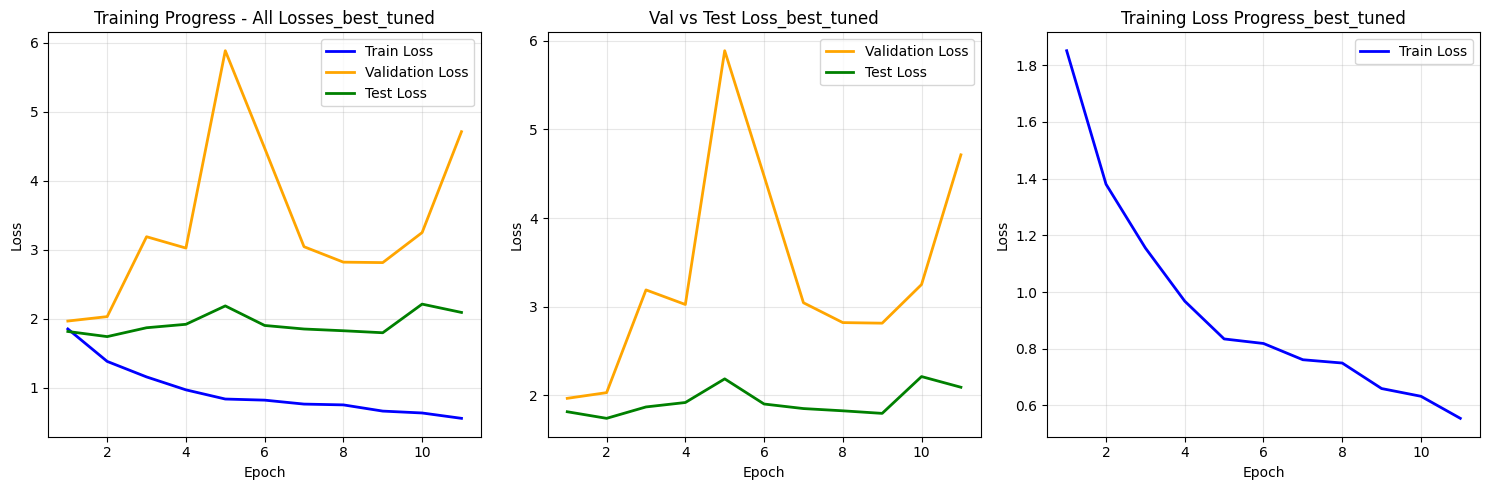

📁 Training curves saved: mcatcn_training_curves_best_tuned.png

📈 Training Summary _best_tuned:
  Final train loss: 0.5545
  Final validation loss: 4.7128
  Best validation loss: 1.9658
  Final test loss: 2.0908
  Best test loss: 1.7401

🔍 2. Standard Model Evaluation...

🔍 Evaluating MCA-TCN Model _best_tuned...

📊 Overall Performance _best_tuned:
  Test Accuracy: 0.5771
  Test F1-Score (Weighted): 0.4855

📋 Per-Class Performance:
                     precision    recall  f1-score   support

         Arm Raises       0.00      0.00      0.00         5
Assisted Propulsion       0.63      0.66      0.65        79
   Changing Clothes       0.05      0.04      0.05        45
       Conversation       0.59      0.91      0.72      2541
             Eating       0.00      0.00      0.00       226
            Resting       0.25      0.00      0.00      1299
    Self Propulsion       0.62      0.63      0.62      1198
           Transfer       0.22      0.35      0.27        48

           ac

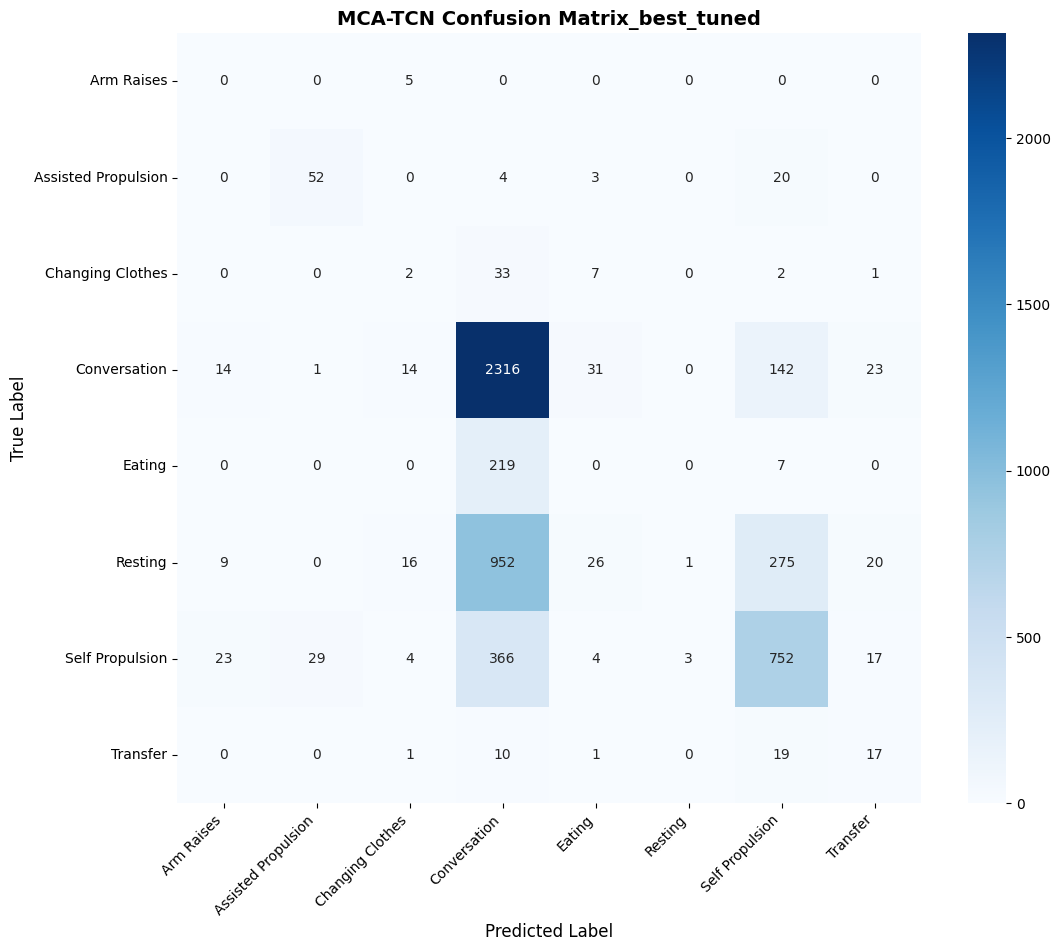

📁 Confusion matrix saved: mcatcn_confusion_matrix_best_tuned.png


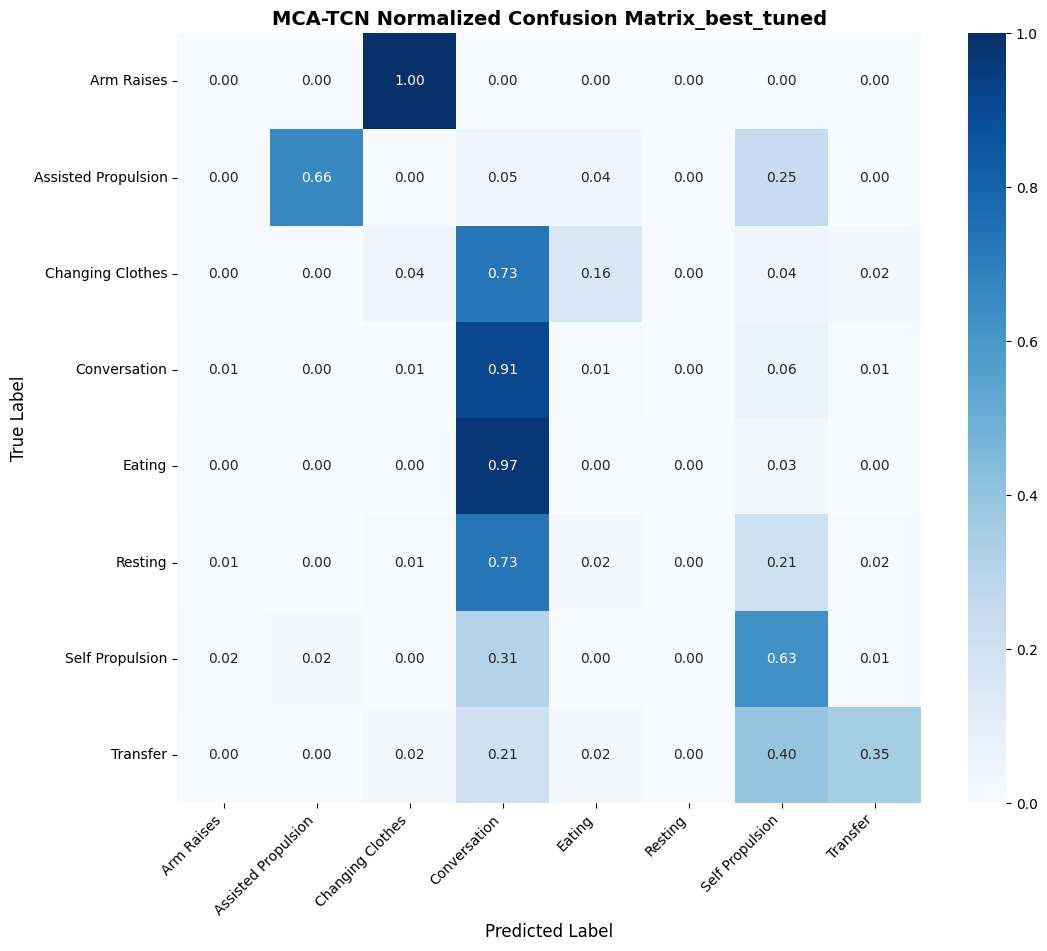

📁 Normalized confusion matrix saved: mcatcn_normalized_confusion_matrix_best_tuned.png

🎯 3. Attention Weights Visualization...

🔍 Visualizing Attention Weights for Interpretability _best_tuned...
Visualizing attention for 100 samples with 26 channels
Creating attention heatmap with size: 15.0x8.0 inches


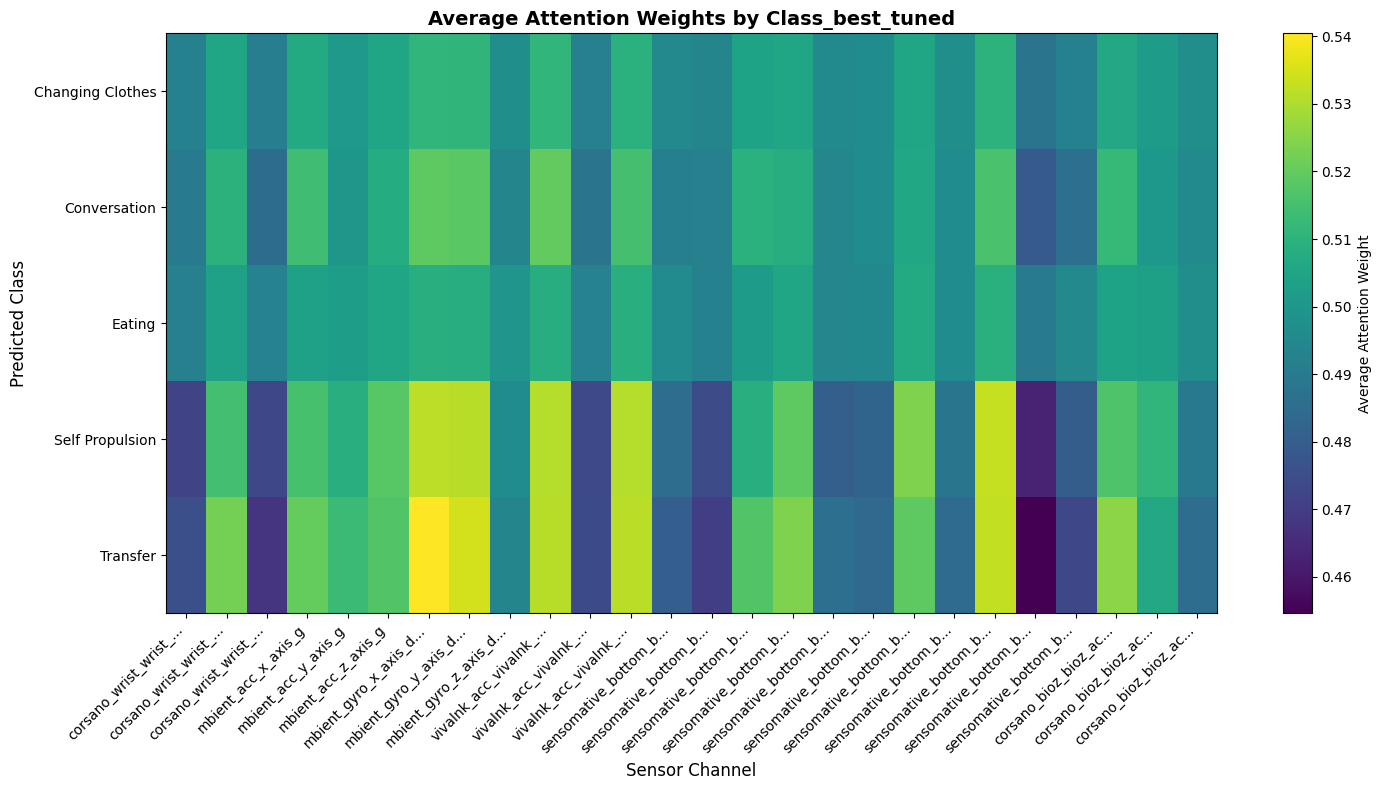

📁 Attention heatmap saved: mcatcn_attention_heatmap_by_class_best_tuned.png


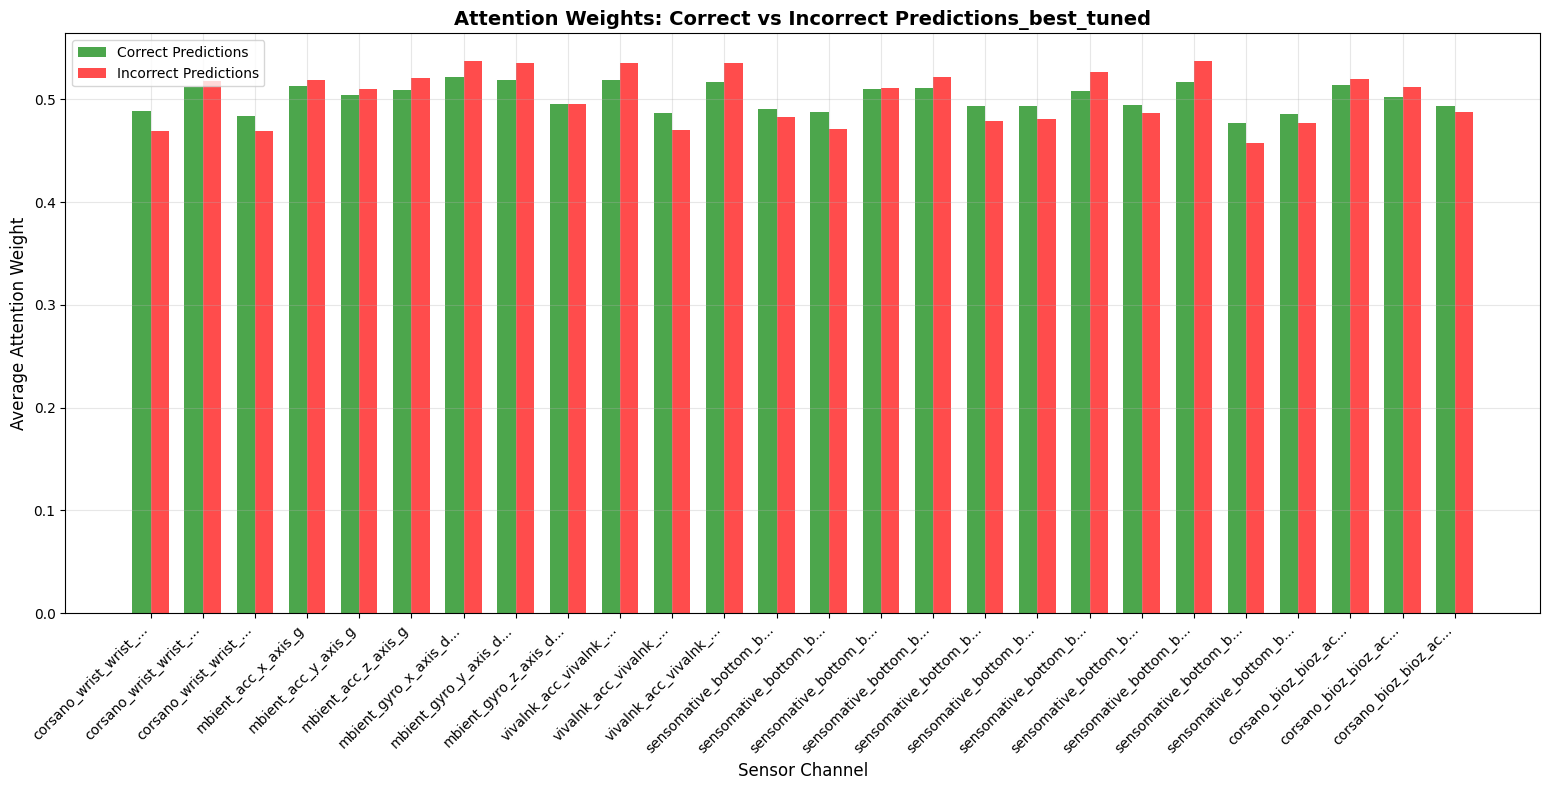

📁 Attention comparison saved: mcatcn_attention_correct_vs_incorrect_best_tuned.png


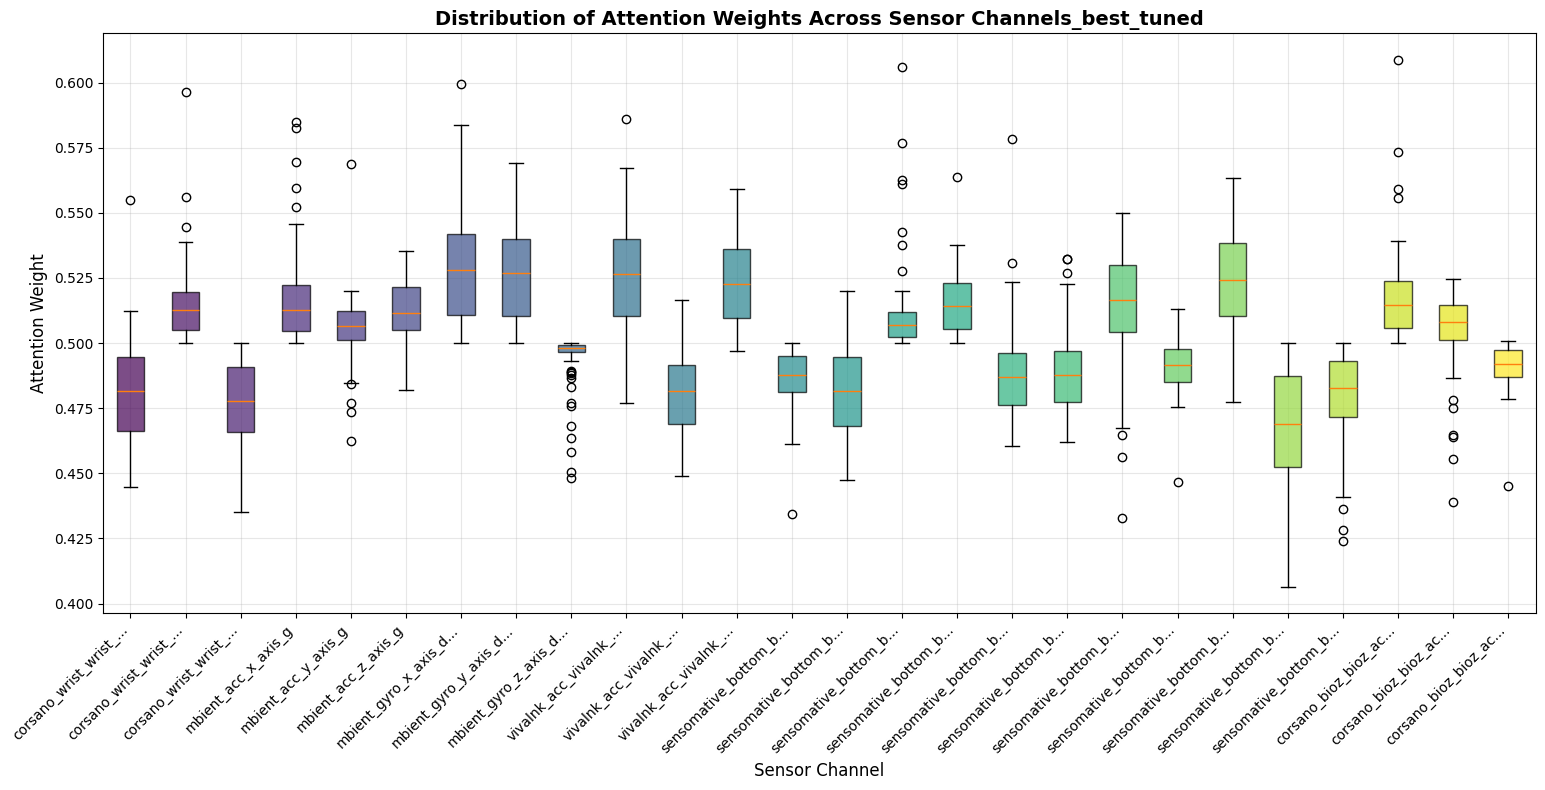

📁 Attention distribution saved: mcatcn_attention_distribution_best_tuned.png

📊 Attention Weight Statistics _best_tuned:
  Overall attention weight statistics:
    Mean: 0.5019
    Std:  0.0245
    Min:  0.4064
    Max:  0.6088

  Per-sensor attention weight means:
    corsano_wrist_wrist_...: 0.4794
    corsano_wrist_wrist_...: 0.5142
    corsano_wrist_wrist_...: 0.4767
    mbient_acc_x_axis_g: 0.5155
    mbient_acc_y_axis_g: 0.5064
    mbient_acc_z_axis_g: 0.5140
    mbient_gyro_x_axis_d...: 0.5284
    mbient_gyro_y_axis_d...: 0.5267
    mbient_gyro_z_axis_d...: 0.4950
    vivalnk_acc_vivalnk_...: 0.5265
    ... and 16 more sensors

  🏆 Most important sensor: mbient_gyro_x_axis_d... (mean: 0.5284)
  🔻 Least important sensor: sensomative_bottom_b... (mean: 0.4677)

  📈 Top 10 Most Important Sensors:
     1. mbient_gyro_x_axis_d...: 0.5284
     2. mbient_gyro_y_axis_d...: 0.5267
     3. vivalnk_acc_vivalnk_...: 0.5265
     4. sensomative_bottom_b...: 0.5264
     5. vivalnk_acc_vivalnk_

In [23]:
# Execute Model Evaluation and Visualization

if 'trained_best_model' in locals() and trained_best_model is not None:
    print("📊 Executing Comprehensive Model Evaluation...")
    
    # 1. Plot training curves
    print("\n📈 1. Generating Training Curves...")
    plot_training_curves(train_losses, val_losses, test_losses, filename_suffix="_best_tuned")
    
    # 2. Standard model evaluation
    print("\n🔍 2. Standard Model Evaluation...")
    accuracy, f1_score_result = evaluate_mcatcn_model(
        trained_best_model, final_test_loader, final_label_encoder, device, 
        filename_suffix="_best_tuned"
    )
    
    # 3. Attention weights visualization
    print("\n🎯 3. Attention Weights Visualization...")
    visualize_attention_weights(
        trained_best_model, final_test_loader, final_label_encoder, device,
        filename_suffix="_best_tuned", num_samples_to_visualize=100
    )
    
    # 4. Model summary and final results
    print(f"\n🏆 FINAL MCA-TCN MODEL RESULTS:")
    print(f"{'='*60}")
    print(f"📊 Performance Metrics:")
    print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Test F1-Score: {f1_score_result:.4f}")
    
    print(f"\n🏗️ Model Architecture:")
    print(f"  Input features: {n_features_loaded}")
    print(f"  TCN channels: {final_tcn_channels}")
    print(f"  Classifier head: {final_classifier_head_type}")
    print(f"  Attention reduction ratio: {final_attention_reduction}")
    print(f"  Total parameters: {sum(p.numel() for p in trained_best_model.parameters()):,}")
    
    print(f"\n⚙️ Optimization Results:")
    print(f"  Best learning rate: {final_lr:.6f}")
    print(f"  Best weight decay: {final_weight_decay:.6f}")
    print(f"  Best dropout rate: {final_dropout:.3f}")
    print(f"  Best batch size: {final_batch_size}")
    
    print(f"\n📁 Generated Files:")
    print(f"  🤖 Model: {MODEL_FILENAME}")
    print(f"  📊 Scaler: {SCALER_FILENAME}")
    print(f"  🏷️ Label Encoder: {ENCODER_FILENAME}")
    print(f"  📈 Training Curves: mcatcn_training_curves_best_tuned.png")
    print(f"  📋 Classification Report: mcatcn_classification_report_best_tuned.txt")
    print(f"  🎯 Confusion Matrices: mcatcn_confusion_matrix_best_tuned.png")
    print(f"  🔍 Attention Visualizations: mcatcn_attention_*_best_tuned.png")
    
    print(f"\n✅ MCA-TCN Implementation Complete!")
    print(f"🎉 The model is trained, evaluated, and ready for deployment.")
    
    # Optional: Monte Carlo Dropout evaluation if enabled
    if MC_DROPOUT_SAMPLES > 0:
        print(f"\n🎲 4. Monte Carlo Dropout Evaluation (Optional)...")
        print(f"Note: MC Dropout with {MC_DROPOUT_SAMPLES} samples can take several minutes.")
        print(f"You can uncomment the code below to run uncertainty quantification:")
        print(f"# evaluate_with_monte_carlo_dropout(trained_best_model, final_test_loader, final_label_encoder, device)")
    
else:
    print("❌ No trained model available for evaluation!")
    print("Please run the complete pipeline:")
    print("  1. Data preparation")
    print("  2. Hyperparameter optimization")
    print("  3. Final model training")
    print("  4. Model evaluation")

# Summary of the complete MCA-TCN pipeline
print(f"\n📋 MCA-TCN PIPELINE SUMMARY:")
print(f"{'='*50}")
print(f"✅ 1. Model Configuration - Parameters and architecture defined")
print(f"✅ 2. Data Preparation - Pipeline data formatted for MCA-TCN")
print(f"✅ 3. Hyperparameter Optimization - Optuna-based HPO completed")
print(f"✅ 4. Final Model Training - Best model trained with early stopping")
print(f"✅ 5. Model Evaluation - Comprehensive performance analysis")
print(f"✅ 6. Attention Visualization - Interpretability analysis")
print(f"✅ 7. Results Export - All artifacts saved for deployment")

print(f"\n🎯 The MCA-TCN model is now ready for activity classification tasks!")
print(f"📚 This implementation includes attention mechanisms for interpretability,")
print(f"   hyperparameter optimization for best performance, and comprehensive")
print(f"   evaluation metrics for thorough analysis.")

In [24]:
# To be run after your study is complete
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [batch_size (CategoricalDistribution):
                                0.0<extra></extra>, scheduler_type
                                (CategoricalDistribution): 0.0<extra></extra>,
                                use_scheduler (CategoricalDistribution):
                                0.0<extra></extra>, tcn_kernel_size
                                (CategoricalDistribution):
                                0.005605550191460503<extra></extra>, weight_decay
                                (FloatDistribution):
                                0.03049041806225175<extra></extra>,
                                attention_reduction_ratio
                                (CategoricalDistribution):
                                0.03677995106870042<extra></extra>, dropout_rate
                                (FloatDistribution):
                                0.04696069342843559<extra></extra>,
                                classifier_dropout (FloatDistribution):
                                0.059841381949218064<extra></extra>, lr
                                (FloatDistribution):
                                0.22455902690866686<extra></extra>,
                                classifier_head_type (CategoricalDistribution):
                                0.23265022980608693<extra></extra>, tcn_config
                                (CategoricalDistribution):
                                0.36311274858517995<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, <0.01, 0.03, 0.04, 0.05, 0.06, 0.22,
                       0.23, 0.36],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0, 0.0, 0.0, 0.005605550191460503, 0.03049041806225175,
                    0.03677995106870042, 0.04696069342843559, 0.059841381949218064,
                    0.22455902690866686, 0.23265022980608693, 0.36311274858517995],
              'y': [batch_size, scheduler_type, use_scheduler, tcn_kernel_size,
                    weight_decay, attention_reduction_ratio, dropout_rate,
                    classifier_dropout, lr, classifier_head_type, tcn_config]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [25]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                   50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                                   62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
                                   74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
                                   86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                                   98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
                                   108, 109, 110, 111, 112, 113, 114, 115, 116,
                                   117, 118, 119, 120, 121, 122, 123, 124, 125,
                                   126, 127, 128, 129, 130, 131, 132, 133, 134,
                                   135, 136, 137, 138, 139, 140, 141, 142, 143,
                                   144, 145, 146, 147, 148, 149, 150, 151, 152,
                                   153, 154, 155, 156, 157, 158, 159, 160, 161,
                                   162, 163, 164, 165, 166, 167, 168, 169, 170,
                                   171, 172, 173, 174, 175, 176, 177, 178, 179,
                                   180, 181, 182, 183, 184, 185, 186, 187, 188,
                                   189, 190, 191, 192, 193, 194, 195, 196, 197,
                                   198, 199],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [8, 16, 4, 8, 16, 8, 8, 4, 4, 4, 16, 16, 4, 16, 16, 16, 16, 8,
                    8, 8, 16, 16, 16, 16, 16, 8, 4, 4, 4, 16, 4, 4, 16, 16, 16, 16,
                    16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 8, 8, 8, 8, 16, 16,
                    16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8,
                    8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 8, 8, 8, 16, 16, 8, 8, 8, 8,
                    8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8,
                    8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                    4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                    8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                    8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                    8, 8, 8, 8, 8, 8],
              'xaxis': 'x',
              'y': [0.10372478555733036, 0.019305919593212175,
                    0.04221115733801041, 0.06940540823898805, 0.03434110596441761,
                    0.07491834083492069, 0.022255064732769864,
                    0.012072417376448537, 0.007575980413440982,
                    0.11337722865110234, 0.08618536874377526, 0.07387560890383384,
                    0.02919011288600868, 0.12580567372773838, 0.08889957791777467,
                    0.09897961173032206, 0.12830592312241118, 0.01618248592220143,
                    0.10845360842769808, 0.1020361052870499, 0.0450313604

In [26]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
                    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
                    123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
                    135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
                    147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
                    159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
                    171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
                    183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
                    195, 196, 197, 198, 199],
              'y': [0.10372478555733036, 0.019305919593212175,
                    0.04221115733801041, 0.06940540823898805, 0.03434110596441761,
                    0.07491834083492069, 0.022255064732769864,
                    0.012072417376448537, 0.007575980413440982,
                    0.11337722865110234, 0.08618536874377526, 0.07387560890383384,
                    0.02919011288600868, 0.12580567372773838, 0.08889957791777467,
                    0.09897961173032206, 0.12830592312241118, 0.01618248592220143,
                    0.10845360842769808, 0.1020361052870499, 0.0450313604941748,
                    0.029648983953352314, 0.0032420979808610107,
                    0.0388116900598148, 0.09981034068864991, 0.016214462695379822,
                    0.03946592080433898, 0.0700859878572452, 0.05453707706474618,
                    0.017758577174302216, 0.008317221424403384,
                    0.08389414379991146, 0.036153550850771245,
                    0.052285092196108246, 0.04543675755815002, 0.03549495103029486,
                    0.16173292807904238, 0.006914465615214687, 0.0922549440358252,
                    0.027270693335575445, 0.0186794903422992, 0.04026858623414138,
                    0.008651639751367655, 0.1234339081143423, 0.15489463979311124,
                    0.07464614789778366, 0.18147909049145217, 0.016175368353735238,
                    0.1033007728942859, 0.06046132414456358, 0.04446318189493663,
                    0.11881216255673238, 0.19606119782203857, 0.11261591648135896,
                    0.13223292830107405, 0.0719584943333692, 0.08144342836711783,
                    0.161082025781279, 0.14102905118887882, 0.07927067417811404,
                    0.008650803590685067, 0.010693298849512863,
                    0.13396736485524446, 0.028887557040357142, 0.0838789523963786,
                    0.04160095644075525, 0.08395642330263163, 0.02304332532779623,
                    0.0660702455601517, 0.05370449685032529, 0.08568349572271686,
                    0.011702127401365251, 0.16237064074813595, 0.09311096256015547,
                    0.04892798862172471, 0.19248620393168547, 0.15205326133589964,
                    0.014427728928198076, 0.12166495580526758, 0.04670000818077151,
                    0.03023214128955188, 0.04883069402677204, 0.04716402243393321,
                    0.11353372949741157, 0.2096068639288279, 0.18374331044498987,
                    0.1588823485737759, 0.15169566529679054, 0.13365658127218116,
                    0.23713583993832033, 0.2229078238444157, 0.16934374740074942,
                    0.12338604337709269, 0.0873177360132658, 0.17172671238355125,
              

LSOS Cross-Validation Scheme Mockup

🚀 Starting Leave-One-Subject-Out (LOSO) Cross-Validation...
🔬 Found 6 subjects for LOSO cross-validation.
⚙️ Using device: cuda
Hyperparameters: mlp head, 0.00086 LR, shallow_128 config

🚀 FOLD 1/6: Testing on Subject -> OutSense-036
⚖️ Balancing training data for Fold 1...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 17 samples
  Assisted Propulsion: 326 samples
  Changing Clothes: 126 samples
  Conversation: 5,725 samples
  Eating: 587 samples
  Resting: 3,351 samples
  Self Propulsion: 2,328 samples
  Transfer: 147 samples
🎯 Using median class size: 456 samples per class
  Arm Raises: keeping all 17 samples
  Assisted Propulsion: keeping all 326 samples
  Changing Clothes: keeping all 126 samples
  Conversation: undersampled from 5,725 to 456 samples
  Eating: undersampled from 587 to 456 samples
  Resting: undersampled from 3,351 to 456 samples
  Self Propulsion: undersampled from 2,328 to 456 samples
  Transfer: keeping all 147 samples

✅

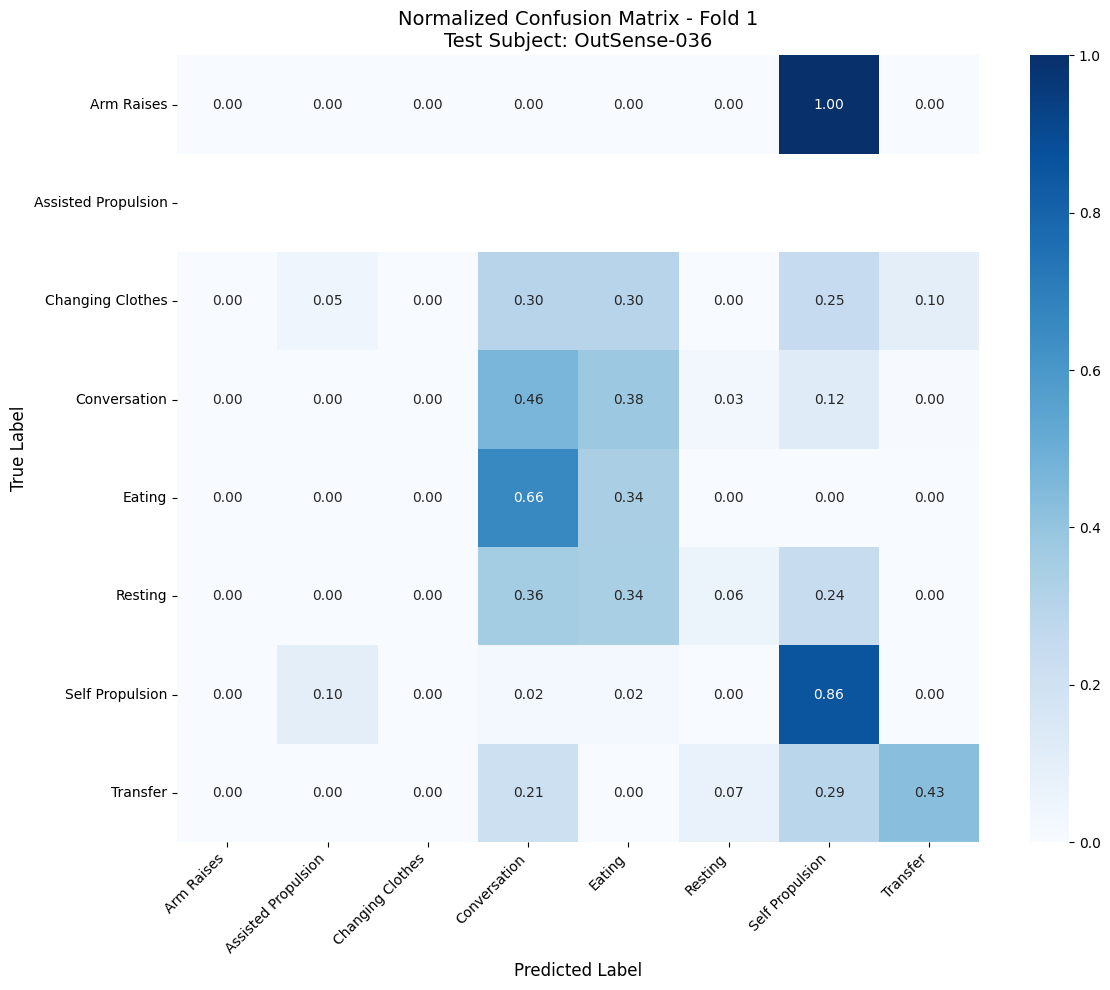

  📁 Saved fold confusion matrix to 'loso_normalized_confusion_matrix_fold_1_subject_OutSense-036.png'
  ✅ Fold 1 Results: Accuracy=0.4568, F1-Score=0.4740

🚀 FOLD 2/6: Testing on Subject -> OutSense-293
⚖️ Balancing training data for Fold 2...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 23 samples
  Assisted Propulsion: 261 samples
  Changing Clothes: 146 samples
  Conversation: 6,060 samples
  Eating: 656 samples
  Resting: 1,849 samples
  Self Propulsion: 2,184 samples
  Transfer: 123 samples
🎯 Using median class size: 458 samples per class
  Arm Raises: keeping all 23 samples
  Assisted Propulsion: keeping all 261 samples
  Changing Clothes: keeping all 146 samples
  Conversation: undersampled from 6,060 to 458 samples
  Eating: undersampled from 656 to 458 samples
  Resting: undersampled from 1,849 to 458 samples
  Self Propulsion: undersampled from 2,184 to 458 samples
  Transfer: keeping all 123 samples

✅ Dataset balancing complete:
  

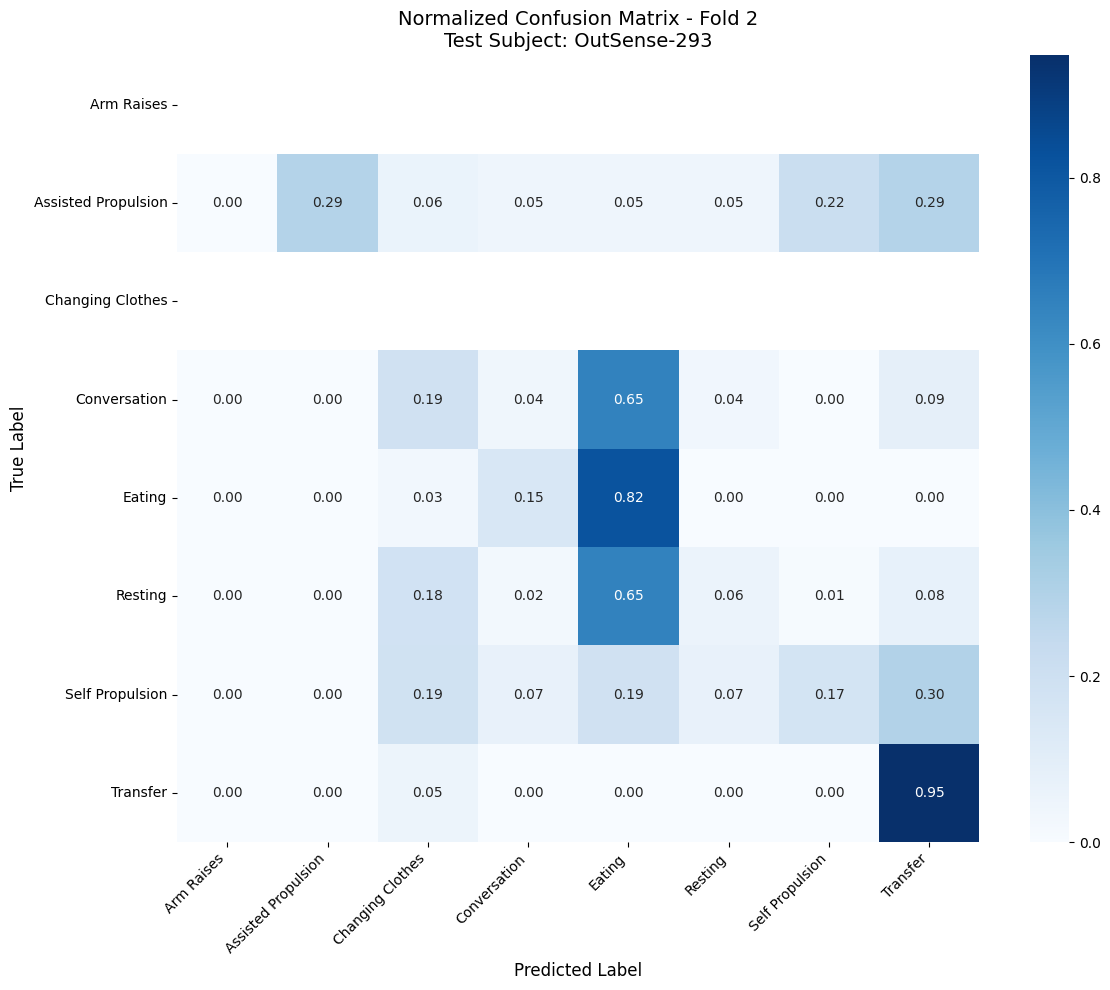

  📁 Saved fold confusion matrix to 'loso_normalized_confusion_matrix_fold_2_subject_OutSense-293.png'
  ✅ Fold 2 Results: Accuracy=0.1229, F1-Score=0.1293

🚀 FOLD 3/6: Testing on Subject -> OutSense-498
⚖️ Balancing training data for Fold 3...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 23 samples
  Assisted Propulsion: 261 samples
  Changing Clothes: 146 samples
  Conversation: 6,060 samples
  Eating: 656 samples
  Resting: 1,849 samples
  Self Propulsion: 2,184 samples
  Transfer: 123 samples
🎯 Using median class size: 458 samples per class
  Arm Raises: keeping all 23 samples
  Assisted Propulsion: keeping all 261 samples
  Changing Clothes: keeping all 146 samples
  Conversation: undersampled from 6,060 to 458 samples
  Eating: undersampled from 656 to 458 samples
  Resting: undersampled from 1,849 to 458 samples
  Self Propulsion: undersampled from 2,184 to 458 samples
  Transfer: keeping all 123 samples

✅ Dataset balancing complete:
  

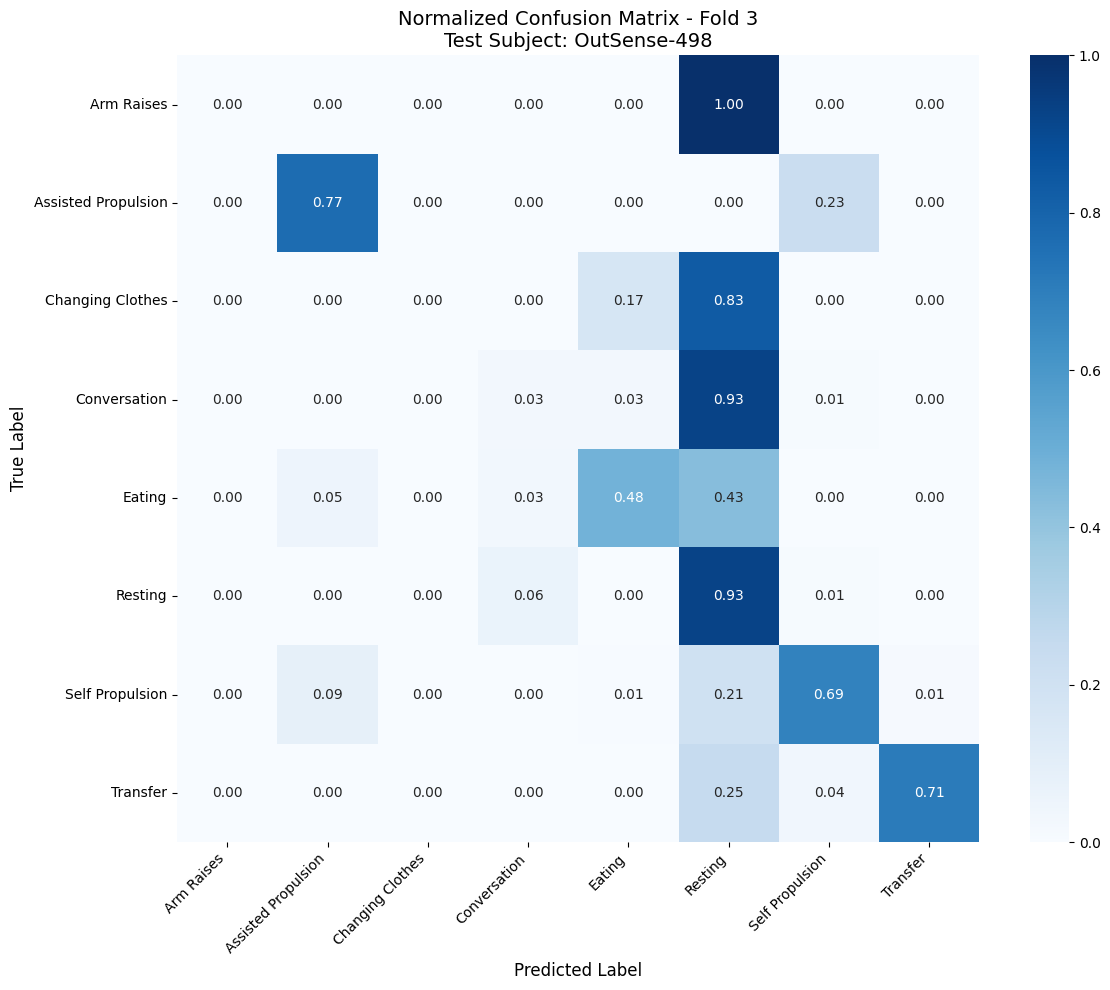

  📁 Saved fold confusion matrix to 'loso_normalized_confusion_matrix_fold_3_subject_OutSense-498.png'
  ✅ Fold 3 Results: Accuracy=0.2530, F1-Score=0.2340

🚀 FOLD 4/6: Testing on Subject -> OutSense-515
⚖️ Balancing training data for Fold 4...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 21 samples
  Assisted Propulsion: 261 samples
  Changing Clothes: 120 samples
  Conversation: 4,935 samples
  Eating: 639 samples
  Resting: 1,933 samples
  Self Propulsion: 1,960 samples
  Transfer: 116 samples
🎯 Using median class size: 450 samples per class
  Arm Raises: keeping all 21 samples
  Assisted Propulsion: keeping all 261 samples
  Changing Clothes: keeping all 120 samples
  Conversation: undersampled from 4,935 to 450 samples
  Eating: undersampled from 639 to 450 samples
  Resting: undersampled from 1,933 to 450 samples
  Self Propulsion: undersampled from 1,960 to 450 samples
  Transfer: keeping all 116 samples

✅ Dataset balancing complete:
  

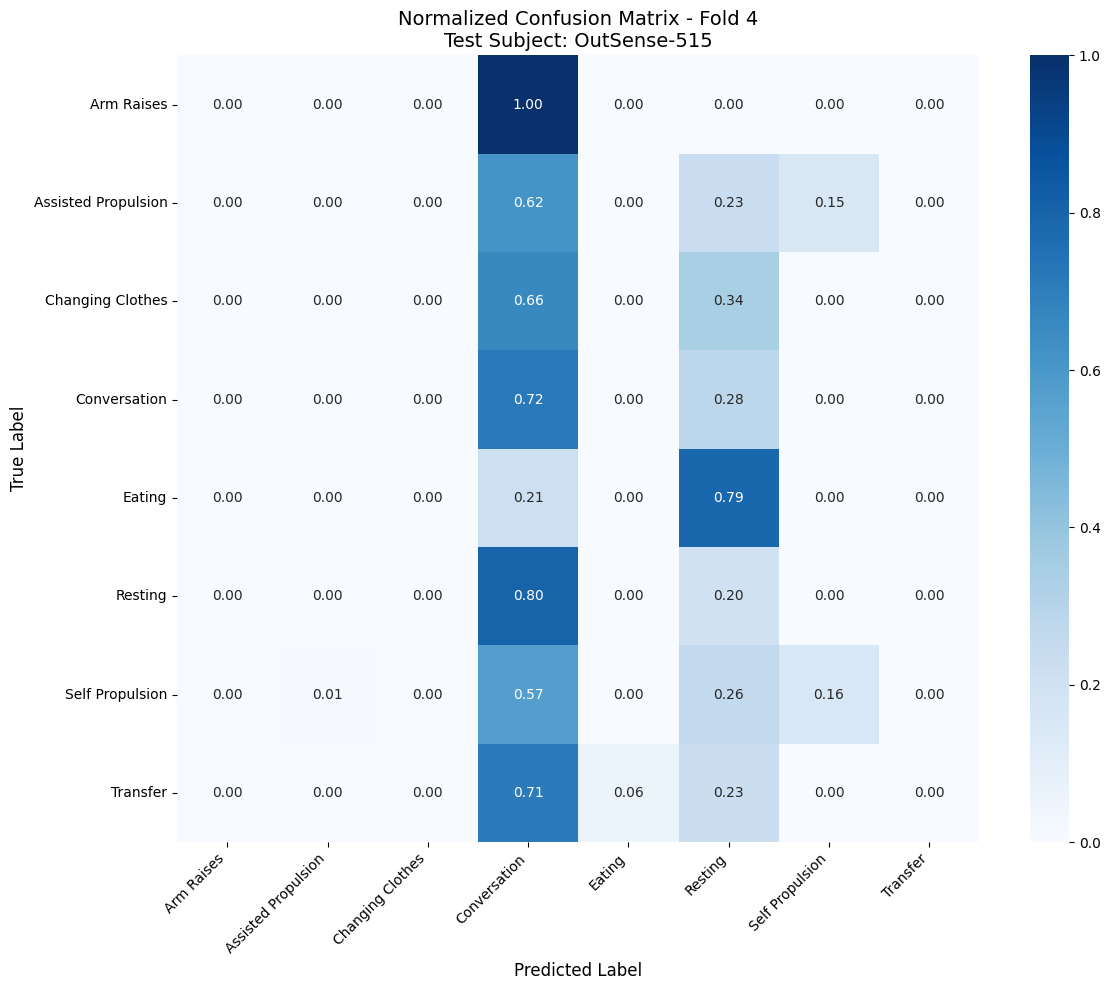

  📁 Saved fold confusion matrix to 'loso_normalized_confusion_matrix_fold_4_subject_OutSense-515.png'
  ✅ Fold 4 Results: Accuracy=0.5682, F1-Score=0.6121

🚀 FOLD 5/6: Testing on Subject -> OutSense-713
⚖️ Balancing training data for Fold 5...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 19 samples
  Assisted Propulsion: 105 samples
  Changing Clothes: 127 samples
  Conversation: 6,803 samples
  Eating: 549 samples
  Resting: 1,530 samples
  Self Propulsion: 2,244 samples
  Transfer: 125 samples
🎯 Using median class size: 338 samples per class
  Arm Raises: keeping all 19 samples
  Assisted Propulsion: keeping all 105 samples
  Changing Clothes: keeping all 127 samples
  Conversation: undersampled from 6,803 to 338 samples
  Eating: undersampled from 549 to 338 samples
  Resting: undersampled from 1,530 to 338 samples
  Self Propulsion: undersampled from 2,244 to 338 samples
  Transfer: keeping all 125 samples

✅ Dataset balancing complete:
  

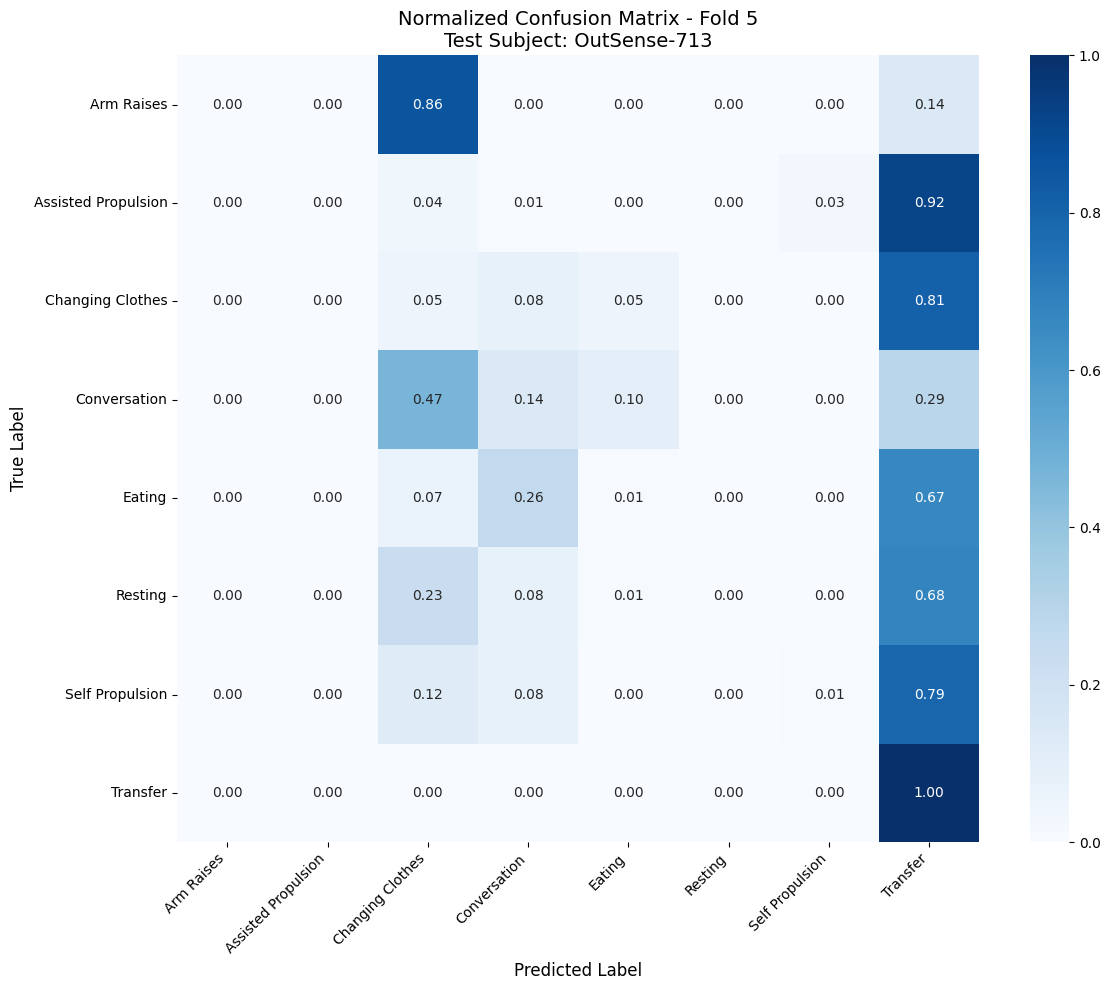

  📁 Saved fold confusion matrix to 'loso_normalized_confusion_matrix_fold_5_subject_OutSense-713.png'
  ✅ Fold 5 Results: Accuracy=0.0595, F1-Score=0.0615

🚀 FOLD 6/6: Testing on Subject -> OutSense-991
⚖️ Balancing training data for Fold 6...
🔄 Balancing dataset using undersampling...
📊 Original class distribution:
  Arm Raises: 21 samples
  Assisted Propulsion: 195 samples
  Changing Clothes: 119 samples
  Conversation: 4,681 samples
  Eating: 488 samples
  Resting: 674 samples
  Self Propulsion: 1,327 samples
  Transfer: 103 samples
🎯 Using median class size: 341 samples per class
  Arm Raises: keeping all 21 samples
  Assisted Propulsion: keeping all 195 samples
  Changing Clothes: keeping all 119 samples
  Conversation: undersampled from 4,681 to 341 samples
  Eating: undersampled from 488 to 341 samples
  Resting: undersampled from 674 to 341 samples
  Self Propulsion: undersampled from 1,327 to 341 samples
  Transfer: keeping all 103 samples

✅ Dataset balancing complete:
  Orig

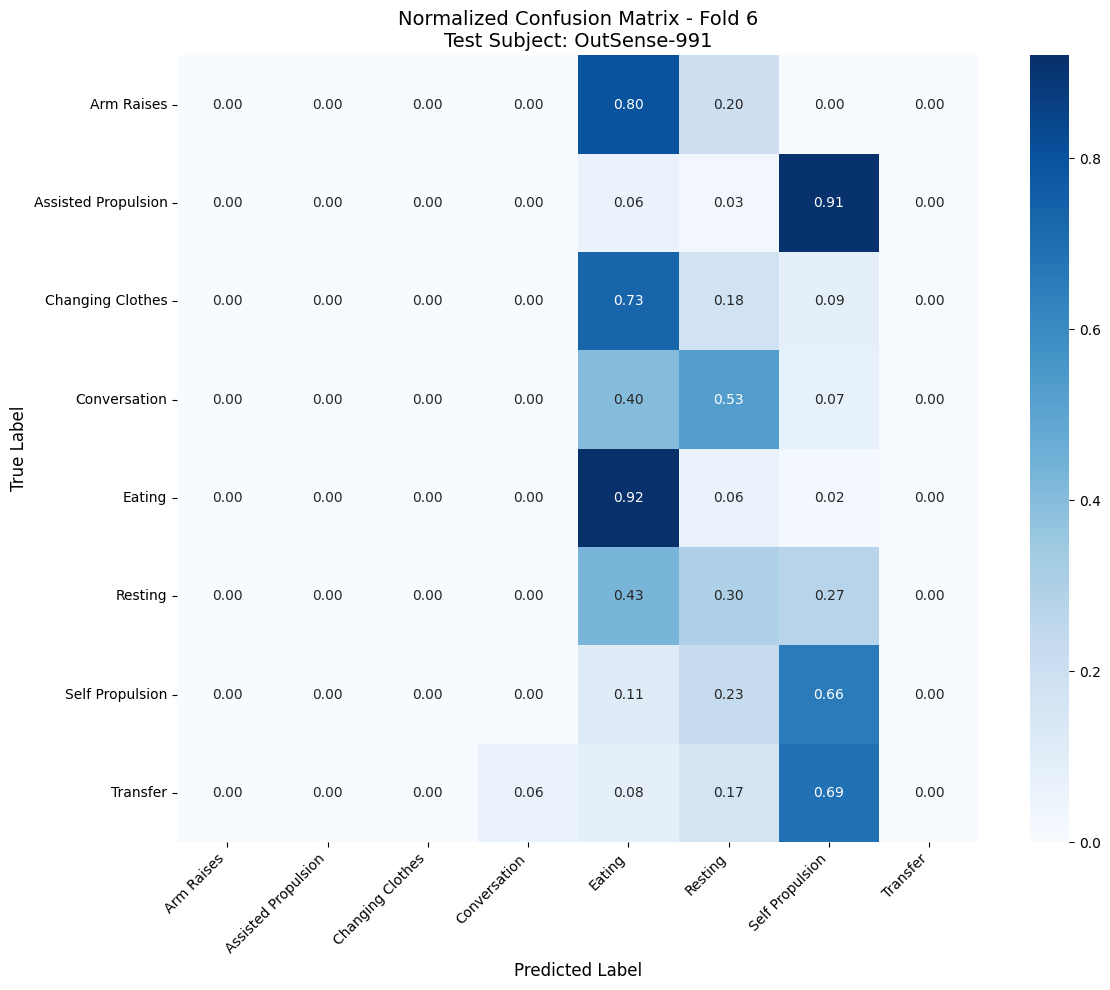

  📁 Saved fold confusion matrix to 'loso_normalized_confusion_matrix_fold_6_subject_OutSense-991.png'
  ✅ Fold 6 Results: Accuracy=0.2538, F1-Score=0.1944

🏆 FINAL AGGREGATED LOSO RESULTS 🏆

📊 Overall Performance (Mean ± Std Dev across all folds):
  - Accuracy: 0.2857 ± 0.1943
  - F1-Score: 0.2842 ± 0.2134

📋 Performance per Fold:
     subject  accuracy  f1_score
OutSense-036  0.456800  0.473981
OutSense-293  0.122896  0.129329
OutSense-498  0.253005  0.234023
OutSense-515  0.568211  0.612134
OutSense-713  0.059470  0.061536
OutSense-991  0.253814  0.194447


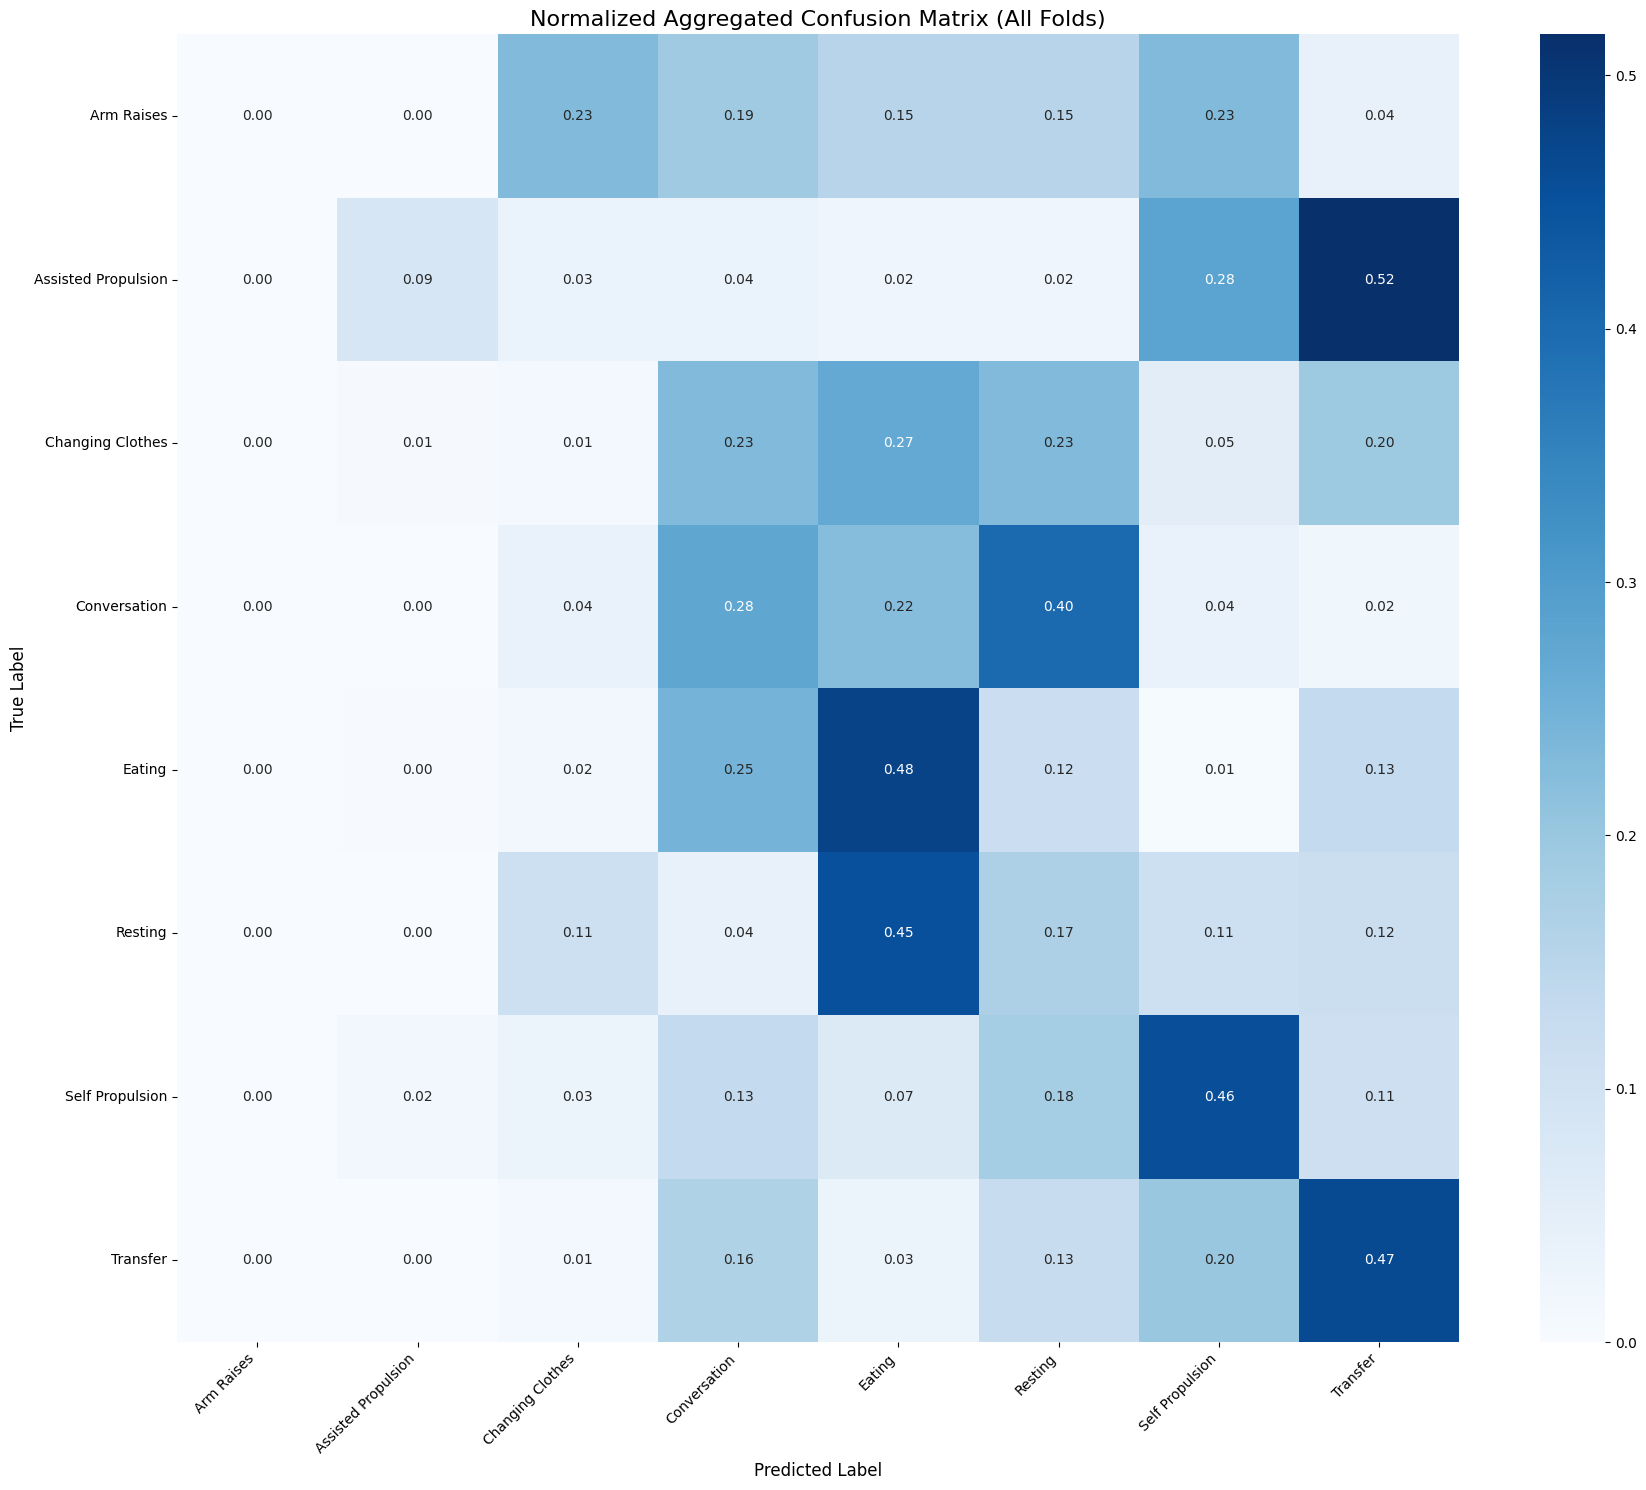


📁 Saved normalized confusion matrix to 'loso_normalized_confusion_matrix.png'


In [27]:
# Leave-One-Subject-Out (LOSO) Cross-Validation Implementation
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle

# Ensure the required data and hyperparameters are available
if 'combined_dataset' not in locals() or 'best_hyperparameters' not in locals() or best_hyperparameters is None:
    print("❌ Prerequisite data or hyperparameters not found!")
    print("Please run the data preparation and hyperparameter optimization cells first.")
else:
    print("🚀 Starting Leave-One-Subject-Out (LOSO) Cross-Validation...")

    # --- 1. Load Data and Configuration (Corrected) ---
    # Load the complete, unsplit dataset directly from the pipeline output
    X_windows = combined_dataset['windows']
    y_labels = combined_dataset['labels']
    # Get subject IDs from the window_info DataFrame
    subject_ids = combined_dataset['window_info'][SUBJECT_ID_COLUMN].values
    
    unique_subjects = np.unique(subject_ids)
    n_features = X_windows.shape[2]
    
    # Load best hyperparameters from the previous Optuna run
    best_params = best_hyperparameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"🔬 Found {len(unique_subjects)} subjects for LOSO cross-validation.")
    print(f"⚙️ Using device: {device}")
    print(f"Hyperparameters: {best_params['classifier_head_type']} head, {best_params['lr']:.5f} LR, {best_params['tcn_config']} config")

    # --- 2. Initialize Variables for Aggregating Results ---
    all_fold_metrics = []
    aggregated_cm = None
    
    # --- 3. Start the LOSO Loop ---
    logo = LeaveOneGroupOut()
    for i, (train_val_idx, test_idx) in enumerate(logo.split(X_windows, y_labels, groups=subject_ids)):
        test_subject = unique_subjects[i]
        print("\n" + "="*70)
        print(f"🚀 FOLD {i+1}/{len(unique_subjects)}: Testing on Subject -> {test_subject}")
        print("="*70)

        # --- 3a. Split Data for the Current Fold ---
        X_train_val, y_train_val = X_windows[train_val_idx], y_labels[train_val_idx]
        groups_train_val = subject_ids[train_val_idx]
        X_test, y_test = X_windows[test_idx], y_labels[test_idx]

        # Further split train_val into train and validation sets using one subject for validation
        # Ensure there are enough groups to split for validation
        if len(np.unique(groups_train_val)) > 1:
            gss_val_split = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
            train_idx, val_idx = next(gss_val_split.split(X_train_val, y_train_val, groups_train_val))
            X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
            X_val, y_val = X_train_val[val_idx], y_train_val[val_idx]
        else:
            # Fallback if only one subject is left for training/validation
            print("⚠️ Only one subject group in train/val set, using random split for validation.")
            from sklearn.model_selection import train_test_split
            train_idx, val_idx = train_test_split(np.arange(len(X_train_val)), test_size=0.15, random_state=42)
            X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
            X_val, y_val = X_train_val[val_idx], y_train_val[val_idx]

        # --- 3b. Balance and Preprocess Data for this Fold ---
        # Balance only the training data
        if ENABLE_DATASET_BALANCING:
            print(f"⚖️ Balancing training data for Fold {i+1}...")
            X_train, y_train, _ = balance_dataset_undersample(
                X_train, y_train, strategy=BALANCING_STRATEGY, random_state=42
            )
        
        # Fit scaler ONLY on the training data of this fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)
        X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

        # Fit label encoder on all possible labels to ensure consistency
        label_encoder = LabelEncoder().fit(y_labels)
        y_train_enc = label_encoder.transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        y_test_enc = label_encoder.transform(y_test)
        num_classes = len(label_encoder.classes_)
        
        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled.transpose(0, 2, 1)).float(), torch.from_numpy(y_train_enc).long()), batch_size=best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_scaled.transpose(0, 2, 1)).float(), torch.from_numpy(y_val_enc).long()), batch_size=best_params['batch_size'], shuffle=False)
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test_scaled.transpose(0, 2, 1)).float(), torch.from_numpy(y_test_enc).long()), batch_size=best_params['batch_size'], shuffle=False)
        
        # --- 3c. Create and Train the Model for this Fold ---
        tcn_channels = tcn_config_map[best_params['tcn_config']]
        model = create_mcatcn_model_with_tuned_params(
            classifier_head_type=best_params['classifier_head_type'],
            classifier_params=best_params, num_inputs=n_features,
            tcn_channels=tcn_channels, num_classes=num_classes,
            kernel_size=best_params['tcn_kernel_size'], dropout=best_params['dropout_rate'],
            attention_reduction_ratio=best_params['attention_reduction_ratio'],
            classifier_dropout=best_params['classifier_dropout']
        )
        model.to(device)

        optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
        criterion = nn.CrossEntropyLoss()
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(NUM_EPOCHS):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X.to(device))
                loss = criterion(outputs, batch_y.to(device))
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X.to(device))
                    val_loss += criterion(outputs, batch_y.to(device)).item()
            val_loss /= len(val_loader)

            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1:3d}, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss - EARLY_STOPPING_MIN_DELTA:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), f"temp_best_model_fold_{i+1}.pth")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                    print(f"  🛑 Early stopping triggered at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}")
                    break
        
        # --- 3d. Evaluate the Model on the Test Subject for this Fold ---
        model.load_state_dict(torch.load(f"temp_best_model_fold_{i+1}.pth"))
        model.eval()
        
        fold_preds_enc, fold_labels_enc = [], []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X.to(device))
                _, predicted = torch.max(outputs, 1)
                fold_preds_enc.extend(predicted.cpu().numpy())
                fold_labels_enc.extend(batch_y.cpu().numpy())
        
        accuracy = accuracy_score(fold_labels_enc, fold_preds_enc)
        f1 = f1_score(fold_labels_enc, fold_preds_enc, average='weighted', zero_division=0)
        cm = confusion_matrix(fold_labels_enc, fold_preds_enc, labels=np.arange(num_classes))
        
        # --- 3e. Visualize Normalized Confusion Matrix for this Fold ---
        # Normalize the confusion matrix for this fold
        normalized_fold_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(normalized_fold_cm, annot=True, fmt='.2f', cmap='Blues', 
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f'Normalized Confusion Matrix - Fold {i+1}\nTest Subject: {test_subject}', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        # Save the normalized confusion matrix for this fold
        fold_cm_filename = f"loso_normalized_confusion_matrix_fold_{i+1}_subject_{test_subject}.png"
        plt.savefig(fold_cm_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  📁 Saved fold confusion matrix to '{fold_cm_filename}'")
        
        all_fold_metrics.append({'subject': test_subject, 'accuracy': accuracy, 'f1_score': f1})
        if aggregated_cm is None:
            aggregated_cm = cm
        else:
            aggregated_cm += cm
        
        print(f"  ✅ Fold {i+1} Results: Accuracy={accuracy:.4f}, F1-Score={f1:.4f}")
        os.remove(f"temp_best_model_fold_{i+1}.pth")

    # --- 4. Aggregate and Display Final Results ---
    print("\n" + "="*70)
    print("🏆 FINAL AGGREGATED LOSO RESULTS 🏆")
    print("="*70)

    metrics_df = pd.DataFrame(all_fold_metrics)
    mean_accuracy = metrics_df['accuracy'].mean()
    std_accuracy = metrics_df['accuracy'].std()
    mean_f1 = metrics_df['f1_score'].mean()
    std_f1 = metrics_df['f1_score'].std()

    print("\n📊 Overall Performance (Mean ± Std Dev across all folds):")
    print(f"  - Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"  - F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

    print("\n📋 Performance per Fold:")
    print(metrics_df.to_string(index=False))

    # --- 5. Visualize Aggregated Confusion Matrix ---
    # Normalize the confusion matrix
    normalized_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(18, 15))
    sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Normalized Aggregated Confusion Matrix (All Folds)', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("loso_normalized_confusion_matrix.png", dpi=300)
    plt.show()
    print("\n📁 Saved normalized confusion matrix to 'loso_normalized_confusion_matrix.png'")